In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['targets','roi','brain']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_e_k5_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 92)
(1919620, 8)
validation
(288502, 92)
(288502, 8)
test
(221128, 92)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 785288 (3.00 MB)


Trainable params: 785288 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 1:34 - loss: 2.1367 - STD: 0.0439 - MAE: 0.2188

 2/20 [==>...........................] - ETA: 1s - loss: 2.1087 - STD: 0.0280 - MAE: 0.2187  

 3/20 [===>..........................] - ETA: 1s - loss: 2.1056 - STD: 0.0271 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 10s - loss: 2.1055 - STD: 0.0275 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 7s - loss: 2.1035 - STD: 0.0267 - MAE: 0.2187 

 6/20 [========>.....................] - ETA: 6s - loss: 2.0996 - STD: 0.0247 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.0961 - STD: 0.0221 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 4s - loss: 2.0940 - STD: 0.0209 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.0931 - STD: 0.0205 - MAE: 0.2187

10/20 [==============>...............] - ETA: 2s - loss: 2.0926 - STD: 0.0204 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.0919 - STD: 0.0201 - MAE: 0.2187

12/20 [=================>............] - ETA: 1s - loss: 2.0910 - STD: 0.0195 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.0900 - STD: 0.0186 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.0891 - STD: 0.0178 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0884 - STD: 0.0172 - MAE: 0.2187

16/20 [=======================>......] - ETA: 0s - loss: 2.0879 - STD: 0.0169 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0875 - STD: 0.0168 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0871 - STD: 0.0166 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0868 - STD: 0.0164 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0863 - STD: 0.0161 - MAE: 0.2186

20/20 [==============================] - 11s 296ms/step - loss: 2.0863 - STD: 0.0161 - MAE: 0.2186 - val_loss: 2.0758 - val_STD: 0.0072 - val_MAE: 0.2186


Epoch 2/10000


 1/20 [>.............................] - ETA: 2s - loss: 2.0772 - STD: 0.0072 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 1s - loss: 2.0773 - STD: 0.0067 - MAE: 0.2186

 3/20 [===>..........................] - ETA: 1s - loss: 2.0775 - STD: 0.0068 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 1s - loss: 2.0778 - STD: 0.0073 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 1s - loss: 2.0780 - STD: 0.0077 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 0s - loss: 2.0780 - STD: 0.0082 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 0s - loss: 2.0778 - STD: 0.0082 - MAE: 0.2186

 9/20 [============>.................] - ETA: 0s - loss: 2.0776 - STD: 0.0080 - MAE: 0.2186

10/20 [==============>...............] - ETA: 0s - loss: 2.0775 - STD: 0.0080 - MAE: 0.2186

11/20 [===============>..............] - ETA: 0s - loss: 2.0774 - STD: 0.0080 - MAE: 0.2186

12/20 [=================>............] - ETA: 0s - loss: 2.0773 - STD: 0.0080 - MAE: 0.2186

13/20 [==================>...........] - ETA: 0s - loss: 2.0773 - STD: 0.0080 - MAE: 0.2186

14/20 [====================>.........] - ETA: 0s - loss: 2.0772 - STD: 0.0081 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0771 - STD: 0.0081 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0769 - STD: 0.0080 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0768 - STD: 0.0080 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0767 - STD: 0.0079 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0765 - STD: 0.0078 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0764 - STD: 0.0078 - MAE: 0.2186

20/20 [==============================] - 2s 99ms/step - loss: 2.0764 - STD: 0.0078 - MAE: 0.2186 - val_loss: 2.0719 - val_STD: 0.0078 - val_MAE: 0.2185


Epoch 3/10000


 1/20 [>.............................] - ETA: 2s - loss: 2.0733 - STD: 0.0079 - MAE: 0.2185

 2/20 [==>...........................] - ETA: 1s - loss: 2.0730 - STD: 0.0082 - MAE: 0.2185

 3/20 [===>..........................] - ETA: 1s - loss: 2.0728 - STD: 0.0083 - MAE: 0.2185

 4/20 [=====>........................] - ETA: 1s - loss: 2.0723 - STD: 0.0081 - MAE: 0.2185

 6/20 [========>.....................] - ETA: 0s - loss: 2.0716 - STD: 0.0078 - MAE: 0.2184

 7/20 [=========>....................] - ETA: 0s - loss: 2.0710 - STD: 0.0077 - MAE: 0.2184

 8/20 [===========>..................] - ETA: 0s - loss: 2.0704 - STD: 0.0078 - MAE: 0.2184

 9/20 [============>.................] - ETA: 0s - loss: 2.0697 - STD: 0.0081 - MAE: 0.2184

10/20 [==============>...............] - ETA: 0s - loss: 2.0691 - STD: 0.0083 - MAE: 0.2184

11/20 [===============>..............] - ETA: 0s - loss: 2.0683 - STD: 0.0086 - MAE: 0.2183

12/20 [=================>............] - ETA: 0s - loss: 2.0675 - STD: 0.0088 - MAE: 0.2183

13/20 [==================>...........] - ETA: 0s - loss: 2.0666 - STD: 0.0090 - MAE: 0.2183

14/20 [====================>.........] - ETA: 0s - loss: 2.0656 - STD: 0.0092 - MAE: 0.2182

15/20 [=====================>........] - ETA: 0s - loss: 2.0645 - STD: 0.0095 - MAE: 0.2182

16/20 [=======================>......] - ETA: 0s - loss: 2.0633 - STD: 0.0099 - MAE: 0.2181

17/20 [========================>.....] - ETA: 0s - loss: 2.0620 - STD: 0.0104 - MAE: 0.2181

18/20 [==========================>...] - ETA: 0s - loss: 2.0606 - STD: 0.0110 - MAE: 0.2180

19/20 [===========================>..] - ETA: 0s - loss: 2.0591 - STD: 0.0116 - MAE: 0.2179

20/20 [==============================] - ETA: 0s - loss: 2.0575 - STD: 0.0122 - MAE: 0.2179

20/20 [==============================] - 2s 97ms/step - loss: 2.0575 - STD: 0.0122 - MAE: 0.2179 - val_loss: 2.0180 - val_STD: 0.0274 - val_MAE: 0.2159


Epoch 4/10000


 1/20 [>.............................] - ETA: 3s - loss: 2.0237 - STD: 0.0268 - MAE: 0.2161

 2/20 [==>...........................] - ETA: 1s - loss: 2.0206 - STD: 0.0283 - MAE: 0.2159

 3/20 [===>..........................] - ETA: 1s - loss: 2.0174 - STD: 0.0299 - MAE: 0.2157

 4/20 [=====>........................] - ETA: 1s - loss: 2.0145 - STD: 0.0312 - MAE: 0.2156

 5/20 [======>.......................] - ETA: 1s - loss: 2.0112 - STD: 0.0325 - MAE: 0.2154

 6/20 [========>.....................] - ETA: 1s - loss: 2.0081 - STD: 0.0337 - MAE: 0.2152

 7/20 [=========>....................] - ETA: 1s - loss: 2.0048 - STD: 0.0349 - MAE: 0.2150

 8/20 [===========>..................] - ETA: 1s - loss: 2.0013 - STD: 0.0361 - MAE: 0.2148

 9/20 [============>.................] - ETA: 0s - loss: 1.9979 - STD: 0.0372 - MAE: 0.2146

10/20 [==============>...............] - ETA: 0s - loss: 1.9942 - STD: 0.0383 - MAE: 0.2144

11/20 [===============>..............] - ETA: 0s - loss: 1.9907 - STD: 0.0394 - MAE: 0.2142

12/20 [=================>............] - ETA: 0s - loss: 1.9868 - STD: 0.0405 - MAE: 0.2139

13/20 [==================>...........] - ETA: 0s - loss: 1.9832 - STD: 0.0417 - MAE: 0.2137

14/20 [====================>.........] - ETA: 0s - loss: 1.9799 - STD: 0.0429 - MAE: 0.2135

15/20 [=====================>........] - ETA: 0s - loss: 1.9764 - STD: 0.0441 - MAE: 0.2133

16/20 [=======================>......] - ETA: 0s - loss: 1.9733 - STD: 0.0452 - MAE: 0.2131

17/20 [========================>.....] - ETA: 0s - loss: 1.9702 - STD: 0.0464 - MAE: 0.2129

18/20 [==========================>...] - ETA: 0s - loss: 1.9674 - STD: 0.0475 - MAE: 0.2127

20/20 [==============================] - ETA: 0s - loss: 1.9639 - STD: 0.0496 - MAE: 0.2123

20/20 [==============================] - 2s 100ms/step - loss: 1.9639 - STD: 0.0496 - MAE: 0.2123 - val_loss: 1.9341 - val_STD: 0.0710 - val_MAE: 0.2090


Epoch 5/10000


 1/20 [>.............................] - ETA: 0s - loss: 1.9135 - STD: 0.0693 - MAE: 0.2085

 2/20 [==>...........................] - ETA: 2s - loss: 1.9065 - STD: 0.0702 - MAE: 0.2083

 3/20 [===>..........................] - ETA: 1s - loss: 1.9060 - STD: 0.0708 - MAE: 0.2082

 4/20 [=====>........................] - ETA: 1s - loss: 1.9040 - STD: 0.0709 - MAE: 0.2081

 5/20 [======>.......................] - ETA: 1s - loss: 1.9027 - STD: 0.0714 - MAE: 0.2080

 6/20 [========>.....................] - ETA: 1s - loss: 1.9005 - STD: 0.0717 - MAE: 0.2078

 7/20 [=========>....................] - ETA: 1s - loss: 1.8994 - STD: 0.0719 - MAE: 0.2078

 8/20 [===========>..................] - ETA: 1s - loss: 1.8987 - STD: 0.0722 - MAE: 0.2077

 9/20 [============>.................] - ETA: 1s - loss: 1.8978 - STD: 0.0724 - MAE: 0.2076

10/20 [==============>...............] - ETA: 0s - loss: 1.8966 - STD: 0.0726 - MAE: 0.2075

11/20 [===============>..............] - ETA: 0s - loss: 1.8955 - STD: 0.0728 - MAE: 0.2074

12/20 [=================>............] - ETA: 0s - loss: 1.8944 - STD: 0.0731 - MAE: 0.2074

13/20 [==================>...........] - ETA: 0s - loss: 1.8931 - STD: 0.0733 - MAE: 0.2073

14/20 [====================>.........] - ETA: 0s - loss: 1.8920 - STD: 0.0736 - MAE: 0.2072

15/20 [=====================>........] - ETA: 0s - loss: 1.8909 - STD: 0.0739 - MAE: 0.2071

16/20 [=======================>......] - ETA: 0s - loss: 1.8900 - STD: 0.0742 - MAE: 0.2070

17/20 [========================>.....] - ETA: 0s - loss: 1.8891 - STD: 0.0744 - MAE: 0.2070

18/20 [==========================>...] - ETA: 0s - loss: 1.8879 - STD: 0.0746 - MAE: 0.2069

19/20 [===========================>..] - ETA: 0s - loss: 1.8870 - STD: 0.0749 - MAE: 0.2068

20/20 [==============================] - ETA: 0s - loss: 1.8860 - STD: 0.0751 - MAE: 0.2067

20/20 [==============================] - 2s 104ms/step - loss: 1.8860 - STD: 0.0751 - MAE: 0.2067 - val_loss: 1.8887 - val_STD: 0.0828 - val_MAE: 0.2055


Epoch 6/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8675 - STD: 0.0801 - MAE: 0.2052

 2/20 [==>...........................] - ETA: 1s - loss: 1.8688 - STD: 0.0804 - MAE: 0.2052

 3/20 [===>..........................] - ETA: 1s - loss: 1.8678 - STD: 0.0804 - MAE: 0.2052

 4/20 [=====>........................] - ETA: 1s - loss: 1.8682 - STD: 0.0804 - MAE: 0.2053

 5/20 [======>.......................] - ETA: 1s - loss: 1.8678 - STD: 0.0805 - MAE: 0.2052

 6/20 [========>.....................] - ETA: 1s - loss: 1.8677 - STD: 0.0807 - MAE: 0.2052

 7/20 [=========>....................] - ETA: 1s - loss: 1.8671 - STD: 0.0808 - MAE: 0.2052

 8/20 [===========>..................] - ETA: 1s - loss: 1.8666 - STD: 0.0809 - MAE: 0.2051

 9/20 [============>.................] - ETA: 0s - loss: 1.8660 - STD: 0.0811 - MAE: 0.2051

10/20 [==============>...............] - ETA: 0s - loss: 1.8654 - STD: 0.0812 - MAE: 0.2050

12/20 [=================>............] - ETA: 0s - loss: 1.8647 - STD: 0.0812 - MAE: 0.2050

13/20 [==================>...........] - ETA: 0s - loss: 1.8638 - STD: 0.0812 - MAE: 0.2050

14/20 [====================>.........] - ETA: 0s - loss: 1.8630 - STD: 0.0813 - MAE: 0.2049

15/20 [=====================>........] - ETA: 0s - loss: 1.8623 - STD: 0.0814 - MAE: 0.2049

16/20 [=======================>......] - ETA: 0s - loss: 1.8616 - STD: 0.0815 - MAE: 0.2049

17/20 [========================>.....] - ETA: 0s - loss: 1.8611 - STD: 0.0816 - MAE: 0.2048

18/20 [==========================>...] - ETA: 0s - loss: 1.8606 - STD: 0.0817 - MAE: 0.2048

19/20 [===========================>..] - ETA: 0s - loss: 1.8601 - STD: 0.0818 - MAE: 0.2048

20/20 [==============================] - ETA: 0s - loss: 1.8594 - STD: 0.0819 - MAE: 0.2047

20/20 [==============================] - 2s 98ms/step - loss: 1.8594 - STD: 0.0819 - MAE: 0.2047 - val_loss: 1.8786 - val_STD: 0.0884 - val_MAE: 0.2044


Epoch 7/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8492 - STD: 0.0844 - MAE: 0.2040

 2/20 [==>...........................] - ETA: 1s - loss: 1.8501 - STD: 0.0841 - MAE: 0.2041

 3/20 [===>..........................] - ETA: 1s - loss: 1.8490 - STD: 0.0840 - MAE: 0.2041

 4/20 [=====>........................] - ETA: 1s - loss: 1.8482 - STD: 0.0838 - MAE: 0.2041

 5/20 [======>.......................] - ETA: 1s - loss: 1.8475 - STD: 0.0837 - MAE: 0.2041

 6/20 [========>.....................] - ETA: 1s - loss: 1.8476 - STD: 0.0837 - MAE: 0.2041

 7/20 [=========>....................] - ETA: 1s - loss: 1.8473 - STD: 0.0837 - MAE: 0.2041

 8/20 [===========>..................] - ETA: 1s - loss: 1.8471 - STD: 0.0837 - MAE: 0.2041

 9/20 [============>.................] - ETA: 0s - loss: 1.8466 - STD: 0.0838 - MAE: 0.2041

10/20 [==============>...............] - ETA: 0s - loss: 1.8461 - STD: 0.0839 - MAE: 0.2040

11/20 [===============>..............] - ETA: 0s - loss: 1.8455 - STD: 0.0840 - MAE: 0.2040

12/20 [=================>............] - ETA: 0s - loss: 1.8447 - STD: 0.0842 - MAE: 0.2039

14/20 [====================>.........] - ETA: 0s - loss: 1.8443 - STD: 0.0845 - MAE: 0.2039

15/20 [=====================>........] - ETA: 0s - loss: 1.8438 - STD: 0.0846 - MAE: 0.2038

16/20 [=======================>......] - ETA: 0s - loss: 1.8435 - STD: 0.0846 - MAE: 0.2038

17/20 [========================>.....] - ETA: 0s - loss: 1.8430 - STD: 0.0847 - MAE: 0.2038

18/20 [==========================>...] - ETA: 0s - loss: 1.8429 - STD: 0.0848 - MAE: 0.2038

19/20 [===========================>..] - ETA: 0s - loss: 1.8426 - STD: 0.0848 - MAE: 0.2038

20/20 [==============================] - ETA: 0s - loss: 1.8421 - STD: 0.0849 - MAE: 0.2037

20/20 [==============================] - 2s 96ms/step - loss: 1.8421 - STD: 0.0849 - MAE: 0.2037 - val_loss: 1.8628 - val_STD: 0.0896 - val_MAE: 0.2039


Epoch 8/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8341 - STD: 0.0858 - MAE: 0.2034

 2/20 [==>...........................] - ETA: 1s - loss: 1.8363 - STD: 0.0860 - MAE: 0.2034

 3/20 [===>..........................] - ETA: 1s - loss: 1.8354 - STD: 0.0860 - MAE: 0.2034

 4/20 [=====>........................] - ETA: 1s - loss: 1.8347 - STD: 0.0861 - MAE: 0.2033

 6/20 [========>.....................] - ETA: 1s - loss: 1.8349 - STD: 0.0862 - MAE: 0.2034

 7/20 [=========>....................] - ETA: 1s - loss: 1.8345 - STD: 0.0862 - MAE: 0.2034

 8/20 [===========>..................] - ETA: 0s - loss: 1.8336 - STD: 0.0863 - MAE: 0.2033

 9/20 [============>.................] - ETA: 0s - loss: 1.8337 - STD: 0.0864 - MAE: 0.2033

10/20 [==============>...............] - ETA: 0s - loss: 1.8339 - STD: 0.0866 - MAE: 0.2033

11/20 [===============>..............] - ETA: 0s - loss: 1.8332 - STD: 0.0867 - MAE: 0.2032

12/20 [=================>............] - ETA: 0s - loss: 1.8328 - STD: 0.0868 - MAE: 0.2032

13/20 [==================>...........] - ETA: 0s - loss: 1.8323 - STD: 0.0869 - MAE: 0.2032

14/20 [====================>.........] - ETA: 0s - loss: 1.8319 - STD: 0.0870 - MAE: 0.2031

15/20 [=====================>........] - ETA: 0s - loss: 1.8317 - STD: 0.0872 - MAE: 0.2031

16/20 [=======================>......] - ETA: 0s - loss: 1.8314 - STD: 0.0873 - MAE: 0.2031

17/20 [========================>.....] - ETA: 0s - loss: 1.8310 - STD: 0.0874 - MAE: 0.2030

18/20 [==========================>...] - ETA: 0s - loss: 1.8311 - STD: 0.0874 - MAE: 0.2030

19/20 [===========================>..] - ETA: 0s - loss: 1.8307 - STD: 0.0874 - MAE: 0.2030

20/20 [==============================] - ETA: 0s - loss: 1.8304 - STD: 0.0874 - MAE: 0.2030

20/20 [==============================] - 2s 99ms/step - loss: 1.8304 - STD: 0.0874 - MAE: 0.2030 - val_loss: 1.8494 - val_STD: 0.0910 - val_MAE: 0.2033


Epoch 9/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.8257 - STD: 0.0878 - MAE: 0.2028

 2/20 [==>...........................] - ETA: 1s - loss: 1.8255 - STD: 0.0885 - MAE: 0.2027

 3/20 [===>..........................] - ETA: 1s - loss: 1.8241 - STD: 0.0885 - MAE: 0.2026

 4/20 [=====>........................] - ETA: 1s - loss: 1.8244 - STD: 0.0885 - MAE: 0.2026

 5/20 [======>.......................] - ETA: 1s - loss: 1.8240 - STD: 0.0887 - MAE: 0.2026

 6/20 [========>.....................] - ETA: 1s - loss: 1.8237 - STD: 0.0888 - MAE: 0.2026

 7/20 [=========>....................] - ETA: 1s - loss: 1.8237 - STD: 0.0888 - MAE: 0.2026

 8/20 [===========>..................] - ETA: 1s - loss: 1.8239 - STD: 0.0890 - MAE: 0.2025

 9/20 [============>.................] - ETA: 0s - loss: 1.8236 - STD: 0.0891 - MAE: 0.2025

10/20 [==============>...............] - ETA: 0s - loss: 1.8233 - STD: 0.0891 - MAE: 0.2025

11/20 [===============>..............] - ETA: 0s - loss: 1.8230 - STD: 0.0891 - MAE: 0.2025

12/20 [=================>............] - ETA: 0s - loss: 1.8231 - STD: 0.0891 - MAE: 0.2025

13/20 [==================>...........] - ETA: 0s - loss: 1.8230 - STD: 0.0891 - MAE: 0.2025

14/20 [====================>.........] - ETA: 0s - loss: 1.8229 - STD: 0.0891 - MAE: 0.2025

15/20 [=====================>........] - ETA: 0s - loss: 1.8227 - STD: 0.0891 - MAE: 0.2025

16/20 [=======================>......] - ETA: 0s - loss: 1.8224 - STD: 0.0892 - MAE: 0.2024

17/20 [========================>.....] - ETA: 0s - loss: 1.8222 - STD: 0.0892 - MAE: 0.2024

18/20 [==========================>...] - ETA: 0s - loss: 1.8221 - STD: 0.0892 - MAE: 0.2024

20/20 [==============================] - ETA: 0s - loss: 1.8219 - STD: 0.0893 - MAE: 0.2024

20/20 [==============================] - 2s 102ms/step - loss: 1.8219 - STD: 0.0893 - MAE: 0.2024 - val_loss: 1.8395 - val_STD: 0.0923 - val_MAE: 0.2027


Epoch 10/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8199 - STD: 0.0898 - MAE: 0.2023

 2/20 [==>...........................] - ETA: 1s - loss: 1.8209 - STD: 0.0908 - MAE: 0.2022

 3/20 [===>..........................] - ETA: 1s - loss: 1.8204 - STD: 0.0906 - MAE: 0.2022

 4/20 [=====>........................] - ETA: 1s - loss: 1.8193 - STD: 0.0903 - MAE: 0.2022

 5/20 [======>.......................] - ETA: 1s - loss: 1.8189 - STD: 0.0904 - MAE: 0.2021

 6/20 [========>.....................] - ETA: 1s - loss: 1.8190 - STD: 0.0904 - MAE: 0.2021

 7/20 [=========>....................] - ETA: 1s - loss: 1.8184 - STD: 0.0902 - MAE: 0.2022

 9/20 [============>.................] - ETA: 0s - loss: 1.8178 - STD: 0.0903 - MAE: 0.2021

10/20 [==============>...............] - ETA: 0s - loss: 1.8175 - STD: 0.0904 - MAE: 0.2021

11/20 [===============>..............] - ETA: 0s - loss: 1.8176 - STD: 0.0904 - MAE: 0.2021

12/20 [=================>............] - ETA: 0s - loss: 1.8177 - STD: 0.0904 - MAE: 0.2021

13/20 [==================>...........] - ETA: 0s - loss: 1.8174 - STD: 0.0904 - MAE: 0.2021

14/20 [====================>.........] - ETA: 0s - loss: 1.8172 - STD: 0.0904 - MAE: 0.2021

15/20 [=====================>........] - ETA: 0s - loss: 1.8172 - STD: 0.0904 - MAE: 0.2021

16/20 [=======================>......] - ETA: 0s - loss: 1.8168 - STD: 0.0904 - MAE: 0.2021

17/20 [========================>.....] - ETA: 0s - loss: 1.8166 - STD: 0.0905 - MAE: 0.2020

18/20 [==========================>...] - ETA: 0s - loss: 1.8162 - STD: 0.0905 - MAE: 0.2020

19/20 [===========================>..] - ETA: 0s - loss: 1.8160 - STD: 0.0906 - MAE: 0.2020

20/20 [==============================] - ETA: 0s - loss: 1.8158 - STD: 0.0907 - MAE: 0.2020

20/20 [==============================] - 2s 95ms/step - loss: 1.8158 - STD: 0.0907 - MAE: 0.2020 - val_loss: 1.8317 - val_STD: 0.0936 - val_MAE: 0.2023


Epoch 11/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.8137 - STD: 0.0912 - MAE: 0.2019

 2/20 [==>...........................] - ETA: 1s - loss: 1.8144 - STD: 0.0912 - MAE: 0.2019

 3/20 [===>..........................] - ETA: 1s - loss: 1.8146 - STD: 0.0916 - MAE: 0.2018

 4/20 [=====>........................] - ETA: 1s - loss: 1.8142 - STD: 0.0913 - MAE: 0.2018

 5/20 [======>.......................] - ETA: 1s - loss: 1.8133 - STD: 0.0911 - MAE: 0.2018

 6/20 [========>.....................] - ETA: 1s - loss: 1.8136 - STD: 0.0912 - MAE: 0.2018

 7/20 [=========>....................] - ETA: 1s - loss: 1.8131 - STD: 0.0912 - MAE: 0.2018

 8/20 [===========>..................] - ETA: 1s - loss: 1.8125 - STD: 0.0912 - MAE: 0.2018

 9/20 [============>.................] - ETA: 0s - loss: 1.8120 - STD: 0.0913 - MAE: 0.2018

10/20 [==============>...............] - ETA: 0s - loss: 1.8117 - STD: 0.0914 - MAE: 0.2017

11/20 [===============>..............] - ETA: 0s - loss: 1.8115 - STD: 0.0914 - MAE: 0.2017

12/20 [=================>............] - ETA: 0s - loss: 1.8115 - STD: 0.0914 - MAE: 0.2017

13/20 [==================>...........] - ETA: 0s - loss: 1.8115 - STD: 0.0915 - MAE: 0.2017

14/20 [====================>.........] - ETA: 0s - loss: 1.8112 - STD: 0.0915 - MAE: 0.2017

16/20 [=======================>......] - ETA: 0s - loss: 1.8111 - STD: 0.0916 - MAE: 0.2017

17/20 [========================>.....] - ETA: 0s - loss: 1.8109 - STD: 0.0916 - MAE: 0.2016

18/20 [==========================>...] - ETA: 0s - loss: 1.8106 - STD: 0.0917 - MAE: 0.2016

19/20 [===========================>..] - ETA: 0s - loss: 1.8105 - STD: 0.0916 - MAE: 0.2016

20/20 [==============================] - ETA: 0s - loss: 1.8103 - STD: 0.0917 - MAE: 0.2016

20/20 [==============================] - 2s 104ms/step - loss: 1.8103 - STD: 0.0917 - MAE: 0.2016 - val_loss: 1.8268 - val_STD: 0.0941 - val_MAE: 0.2021


Epoch 12/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8073 - STD: 0.0918 - MAE: 0.2015

 2/20 [==>...........................] - ETA: 1s - loss: 1.8075 - STD: 0.0920 - MAE: 0.2015

 3/20 [===>..........................] - ETA: 1s - loss: 1.8075 - STD: 0.0925 - MAE: 0.2014

 4/20 [=====>........................] - ETA: 1s - loss: 1.8069 - STD: 0.0925 - MAE: 0.2014

 6/20 [========>.....................] - ETA: 1s - loss: 1.8064 - STD: 0.0926 - MAE: 0.2013

 7/20 [=========>....................] - ETA: 0s - loss: 1.8061 - STD: 0.0925 - MAE: 0.2013

 8/20 [===========>..................] - ETA: 0s - loss: 1.8061 - STD: 0.0926 - MAE: 0.2013

 9/20 [============>.................] - ETA: 0s - loss: 1.8057 - STD: 0.0926 - MAE: 0.2013

10/20 [==============>...............] - ETA: 0s - loss: 1.8057 - STD: 0.0926 - MAE: 0.2013

11/20 [===============>..............] - ETA: 0s - loss: 1.8058 - STD: 0.0927 - MAE: 0.2013

12/20 [=================>............] - ETA: 0s - loss: 1.8057 - STD: 0.0926 - MAE: 0.2013

13/20 [==================>...........] - ETA: 0s - loss: 1.8055 - STD: 0.0926 - MAE: 0.2013

14/20 [====================>.........] - ETA: 0s - loss: 1.8055 - STD: 0.0925 - MAE: 0.2013

15/20 [=====================>........] - ETA: 0s - loss: 1.8053 - STD: 0.0926 - MAE: 0.2013

16/20 [=======================>......] - ETA: 0s - loss: 1.8053 - STD: 0.0926 - MAE: 0.2013

17/20 [========================>.....] - ETA: 0s - loss: 1.8053 - STD: 0.0926 - MAE: 0.2013

18/20 [==========================>...] - ETA: 0s - loss: 1.8050 - STD: 0.0926 - MAE: 0.2013

19/20 [===========================>..] - ETA: 0s - loss: 1.8049 - STD: 0.0927 - MAE: 0.2013

20/20 [==============================] - ETA: 0s - loss: 1.8048 - STD: 0.0927 - MAE: 0.2013

20/20 [==============================] - 2s 96ms/step - loss: 1.8048 - STD: 0.0927 - MAE: 0.2013 - val_loss: 1.8217 - val_STD: 0.0958 - val_MAE: 0.2016


Epoch 13/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.8014 - STD: 0.0938 - MAE: 0.2009

 2/20 [==>...........................] - ETA: 1s - loss: 1.8024 - STD: 0.0936 - MAE: 0.2010

 3/20 [===>..........................] - ETA: 1s - loss: 1.8020 - STD: 0.0935 - MAE: 0.2010

 4/20 [=====>........................] - ETA: 1s - loss: 1.8015 - STD: 0.0934 - MAE: 0.2010

 5/20 [======>.......................] - ETA: 1s - loss: 1.8021 - STD: 0.0934 - MAE: 0.2010

 6/20 [========>.....................] - ETA: 1s - loss: 1.8021 - STD: 0.0933 - MAE: 0.2011

 7/20 [=========>....................] - ETA: 1s - loss: 1.8018 - STD: 0.0933 - MAE: 0.2010

 8/20 [===========>..................] - ETA: 1s - loss: 1.8018 - STD: 0.0933 - MAE: 0.2011

10/20 [==============>...............] - ETA: 0s - loss: 1.8016 - STD: 0.0933 - MAE: 0.2010

11/20 [===============>..............] - ETA: 0s - loss: 1.8017 - STD: 0.0932 - MAE: 0.2011

12/20 [=================>............] - ETA: 0s - loss: 1.8018 - STD: 0.0933 - MAE: 0.2010

13/20 [==================>...........] - ETA: 0s - loss: 1.8017 - STD: 0.0933 - MAE: 0.2010

14/20 [====================>.........] - ETA: 0s - loss: 1.8015 - STD: 0.0933 - MAE: 0.2010

15/20 [=====================>........] - ETA: 0s - loss: 1.8012 - STD: 0.0933 - MAE: 0.2010

16/20 [=======================>......] - ETA: 0s - loss: 1.8011 - STD: 0.0933 - MAE: 0.2010

17/20 [========================>.....] - ETA: 0s - loss: 1.8011 - STD: 0.0934 - MAE: 0.2010

18/20 [==========================>...] - ETA: 0s - loss: 1.8008 - STD: 0.0934 - MAE: 0.2010

19/20 [===========================>..] - ETA: 0s - loss: 1.8005 - STD: 0.0934 - MAE: 0.2010

20/20 [==============================] - ETA: 0s - loss: 1.8003 - STD: 0.0935 - MAE: 0.2010

20/20 [==============================] - 2s 109ms/step - loss: 1.8003 - STD: 0.0935 - MAE: 0.2010 - val_loss: 1.8173 - val_STD: 0.0959 - val_MAE: 0.2014


Epoch 14/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7961 - STD: 0.0939 - MAE: 0.2008

 2/20 [==>...........................] - ETA: 1s - loss: 1.7964 - STD: 0.0937 - MAE: 0.2008

 3/20 [===>..........................] - ETA: 1s - loss: 1.7956 - STD: 0.0940 - MAE: 0.2007

 4/20 [=====>........................] - ETA: 1s - loss: 1.7961 - STD: 0.0938 - MAE: 0.2008

 5/20 [======>.......................] - ETA: 1s - loss: 1.7961 - STD: 0.0938 - MAE: 0.2008

 6/20 [========>.....................] - ETA: 1s - loss: 1.7960 - STD: 0.0937 - MAE: 0.2008

 7/20 [=========>....................] - ETA: 1s - loss: 1.7960 - STD: 0.0937 - MAE: 0.2008

 8/20 [===========>..................] - ETA: 1s - loss: 1.7956 - STD: 0.0938 - MAE: 0.2008

 9/20 [============>.................] - ETA: 0s - loss: 1.7953 - STD: 0.0939 - MAE: 0.2007

11/20 [===============>..............] - ETA: 0s - loss: 1.7950 - STD: 0.0940 - MAE: 0.2007

12/20 [=================>............] - ETA: 0s - loss: 1.7951 - STD: 0.0941 - MAE: 0.2007

13/20 [==================>...........] - ETA: 0s - loss: 1.7952 - STD: 0.0941 - MAE: 0.2007

14/20 [====================>.........] - ETA: 0s - loss: 1.7949 - STD: 0.0941 - MAE: 0.2007

15/20 [=====================>........] - ETA: 0s - loss: 1.7946 - STD: 0.0941 - MAE: 0.2007

16/20 [=======================>......] - ETA: 0s - loss: 1.7945 - STD: 0.0942 - MAE: 0.2007

17/20 [========================>.....] - ETA: 0s - loss: 1.7944 - STD: 0.0941 - MAE: 0.2007

18/20 [==========================>...] - ETA: 0s - loss: 1.7942 - STD: 0.0942 - MAE: 0.2006

19/20 [===========================>..] - ETA: 0s - loss: 1.7941 - STD: 0.0942 - MAE: 0.2006

20/20 [==============================] - ETA: 0s - loss: 1.7940 - STD: 0.0943 - MAE: 0.2006

20/20 [==============================] - 2s 100ms/step - loss: 1.7940 - STD: 0.0943 - MAE: 0.2006 - val_loss: 1.8104 - val_STD: 0.0962 - val_MAE: 0.2011


Epoch 15/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7936 - STD: 0.0949 - MAE: 0.2005

 2/20 [==>...........................] - ETA: 1s - loss: 1.7913 - STD: 0.0953 - MAE: 0.2003

 3/20 [===>..........................] - ETA: 1s - loss: 1.7918 - STD: 0.0949 - MAE: 0.2004

 4/20 [=====>........................] - ETA: 1s - loss: 1.7902 - STD: 0.0950 - MAE: 0.2003

 5/20 [======>.......................] - ETA: 1s - loss: 1.7899 - STD: 0.0949 - MAE: 0.2003

 6/20 [========>.....................] - ETA: 1s - loss: 1.7900 - STD: 0.0949 - MAE: 0.2004

 7/20 [=========>....................] - ETA: 1s - loss: 1.7902 - STD: 0.0948 - MAE: 0.2004

 8/20 [===========>..................] - ETA: 1s - loss: 1.7896 - STD: 0.0949 - MAE: 0.2004

 9/20 [============>.................] - ETA: 0s - loss: 1.7892 - STD: 0.0947 - MAE: 0.2004

10/20 [==============>...............] - ETA: 0s - loss: 1.7891 - STD: 0.0949 - MAE: 0.2003

11/20 [===============>..............] - ETA: 0s - loss: 1.7894 - STD: 0.0949 - MAE: 0.2003

12/20 [=================>............] - ETA: 0s - loss: 1.7895 - STD: 0.0951 - MAE: 0.2003

13/20 [==================>...........] - ETA: 0s - loss: 1.7895 - STD: 0.0951 - MAE: 0.2003

14/20 [====================>.........] - ETA: 0s - loss: 1.7894 - STD: 0.0952 - MAE: 0.2003

15/20 [=====================>........] - ETA: 0s - loss: 1.7891 - STD: 0.0951 - MAE: 0.2003

16/20 [=======================>......] - ETA: 0s - loss: 1.7888 - STD: 0.0950 - MAE: 0.2003

17/20 [========================>.....] - ETA: 0s - loss: 1.7889 - STD: 0.0951 - MAE: 0.2003

18/20 [==========================>...] - ETA: 0s - loss: 1.7891 - STD: 0.0950 - MAE: 0.2003

20/20 [==============================] - ETA: 0s - loss: 1.7888 - STD: 0.0951 - MAE: 0.2003

20/20 [==============================] - 2s 96ms/step - loss: 1.7888 - STD: 0.0951 - MAE: 0.2003 - val_loss: 1.8025 - val_STD: 0.0967 - val_MAE: 0.2007


Epoch 16/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7826 - STD: 0.0955 - MAE: 0.2000

 2/20 [==>...........................] - ETA: 1s - loss: 1.7828 - STD: 0.0961 - MAE: 0.1999

 3/20 [===>..........................] - ETA: 1s - loss: 1.7826 - STD: 0.0959 - MAE: 0.1999

 4/20 [=====>........................] - ETA: 1s - loss: 1.7822 - STD: 0.0958 - MAE: 0.1999

 5/20 [======>.......................] - ETA: 1s - loss: 1.7822 - STD: 0.0958 - MAE: 0.1999

 6/20 [========>.....................] - ETA: 1s - loss: 1.7828 - STD: 0.0955 - MAE: 0.2000

 8/20 [===========>..................] - ETA: 0s - loss: 1.7831 - STD: 0.0955 - MAE: 0.2000

 9/20 [============>.................] - ETA: 0s - loss: 1.7829 - STD: 0.0955 - MAE: 0.2000

10/20 [==============>...............] - ETA: 0s - loss: 1.7831 - STD: 0.0957 - MAE: 0.2000

11/20 [===============>..............] - ETA: 0s - loss: 1.7830 - STD: 0.0957 - MAE: 0.1999

12/20 [=================>............] - ETA: 0s - loss: 1.7825 - STD: 0.0958 - MAE: 0.1999

13/20 [==================>...........] - ETA: 0s - loss: 1.7822 - STD: 0.0959 - MAE: 0.1999

14/20 [====================>.........] - ETA: 0s - loss: 1.7821 - STD: 0.0959 - MAE: 0.1999

15/20 [=====================>........] - ETA: 0s - loss: 1.7818 - STD: 0.0960 - MAE: 0.1998

16/20 [=======================>......] - ETA: 0s - loss: 1.7817 - STD: 0.0961 - MAE: 0.1998

17/20 [========================>.....] - ETA: 0s - loss: 1.7819 - STD: 0.0961 - MAE: 0.1998

18/20 [==========================>...] - ETA: 0s - loss: 1.7816 - STD: 0.0961 - MAE: 0.1998

19/20 [===========================>..] - ETA: 0s - loss: 1.7814 - STD: 0.0961 - MAE: 0.1998

20/20 [==============================] - ETA: 0s - loss: 1.7814 - STD: 0.0961 - MAE: 0.1998

20/20 [==============================] - 2s 95ms/step - loss: 1.7814 - STD: 0.0961 - MAE: 0.1998 - val_loss: 1.8039 - val_STD: 0.0981 - val_MAE: 0.2005


Epoch 17/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7787 - STD: 0.0966 - MAE: 0.1997

 2/20 [==>...........................] - ETA: 1s - loss: 1.7763 - STD: 0.0962 - MAE: 0.1996

 3/20 [===>..........................] - ETA: 1s - loss: 1.7759 - STD: 0.0963 - MAE: 0.1996

 4/20 [=====>........................] - ETA: 1s - loss: 1.7769 - STD: 0.0964 - MAE: 0.1996

 5/20 [======>.......................] - ETA: 1s - loss: 1.7769 - STD: 0.0965 - MAE: 0.1996

 7/20 [=========>....................] - ETA: 1s - loss: 1.7768 - STD: 0.0966 - MAE: 0.1995

 8/20 [===========>..................] - ETA: 0s - loss: 1.7768 - STD: 0.0967 - MAE: 0.1995

 9/20 [============>.................] - ETA: 0s - loss: 1.7763 - STD: 0.0968 - MAE: 0.1995

10/20 [==============>...............] - ETA: 0s - loss: 1.7764 - STD: 0.0969 - MAE: 0.1995

11/20 [===============>..............] - ETA: 0s - loss: 1.7766 - STD: 0.0969 - MAE: 0.1995

12/20 [=================>............] - ETA: 0s - loss: 1.7762 - STD: 0.0970 - MAE: 0.1994

13/20 [==================>...........] - ETA: 0s - loss: 1.7761 - STD: 0.0970 - MAE: 0.1994

14/20 [====================>.........] - ETA: 0s - loss: 1.7758 - STD: 0.0971 - MAE: 0.1994

15/20 [=====================>........] - ETA: 0s - loss: 1.7755 - STD: 0.0971 - MAE: 0.1994

16/20 [=======================>......] - ETA: 0s - loss: 1.7749 - STD: 0.0971 - MAE: 0.1994

17/20 [========================>.....] - ETA: 0s - loss: 1.7751 - STD: 0.0972 - MAE: 0.1994

18/20 [==========================>...] - ETA: 0s - loss: 1.7749 - STD: 0.0972 - MAE: 0.1994

19/20 [===========================>..] - ETA: 0s - loss: 1.7746 - STD: 0.0973 - MAE: 0.1993

20/20 [==============================] - ETA: 0s - loss: 1.7743 - STD: 0.0973 - MAE: 0.1993

20/20 [==============================] - 2s 100ms/step - loss: 1.7743 - STD: 0.0973 - MAE: 0.1993 - val_loss: 1.7919 - val_STD: 0.0976 - val_MAE: 0.2001


Epoch 18/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7714 - STD: 0.0967 - MAE: 0.1993

 2/20 [==>...........................] - ETA: 1s - loss: 1.7699 - STD: 0.0973 - MAE: 0.1991

 3/20 [===>..........................] - ETA: 1s - loss: 1.7689 - STD: 0.0974 - MAE: 0.1991

 4/20 [=====>........................] - ETA: 1s - loss: 1.7683 - STD: 0.0976 - MAE: 0.1991

 5/20 [======>.......................] - ETA: 1s - loss: 1.7674 - STD: 0.0978 - MAE: 0.1990

 6/20 [========>.....................] - ETA: 1s - loss: 1.7674 - STD: 0.0979 - MAE: 0.1990

 7/20 [=========>....................] - ETA: 1s - loss: 1.7676 - STD: 0.0979 - MAE: 0.1990

 8/20 [===========>..................] - ETA: 1s - loss: 1.7677 - STD: 0.0978 - MAE: 0.1990

 9/20 [============>.................] - ETA: 0s - loss: 1.7677 - STD: 0.0979 - MAE: 0.1990

10/20 [==============>...............] - ETA: 0s - loss: 1.7678 - STD: 0.0979 - MAE: 0.1989

11/20 [===============>..............] - ETA: 0s - loss: 1.7681 - STD: 0.0980 - MAE: 0.1990

13/20 [==================>...........] - ETA: 0s - loss: 1.7684 - STD: 0.0983 - MAE: 0.1989

14/20 [====================>.........] - ETA: 0s - loss: 1.7684 - STD: 0.0984 - MAE: 0.1989

15/20 [=====================>........] - ETA: 0s - loss: 1.7679 - STD: 0.0984 - MAE: 0.1989

16/20 [=======================>......] - ETA: 0s - loss: 1.7681 - STD: 0.0984 - MAE: 0.1989

17/20 [========================>.....] - ETA: 0s - loss: 1.7679 - STD: 0.0984 - MAE: 0.1989

18/20 [==========================>...] - ETA: 0s - loss: 1.7676 - STD: 0.0984 - MAE: 0.1989

19/20 [===========================>..] - ETA: 0s - loss: 1.7674 - STD: 0.0983 - MAE: 0.1989

20/20 [==============================] - ETA: 0s - loss: 1.7673 - STD: 0.0984 - MAE: 0.1988

20/20 [==============================] - 2s 99ms/step - loss: 1.7673 - STD: 0.0984 - MAE: 0.1988 - val_loss: 1.7903 - val_STD: 0.0987 - val_MAE: 0.1998


Epoch 19/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7607 - STD: 0.0981 - MAE: 0.1986

 2/20 [==>...........................] - ETA: 1s - loss: 1.7619 - STD: 0.0984 - MAE: 0.1986

 3/20 [===>..........................] - ETA: 1s - loss: 1.7636 - STD: 0.0994 - MAE: 0.1985

 4/20 [=====>........................] - ETA: 1s - loss: 1.7622 - STD: 0.0994 - MAE: 0.1984

 5/20 [======>.......................] - ETA: 1s - loss: 1.7623 - STD: 0.0994 - MAE: 0.1984

 6/20 [========>.....................] - ETA: 1s - loss: 1.7620 - STD: 0.0995 - MAE: 0.1984

 7/20 [=========>....................] - ETA: 1s - loss: 1.7621 - STD: 0.0995 - MAE: 0.1984

 8/20 [===========>..................] - ETA: 1s - loss: 1.7613 - STD: 0.0995 - MAE: 0.1984

 9/20 [============>.................] - ETA: 0s - loss: 1.7609 - STD: 0.0995 - MAE: 0.1984

10/20 [==============>...............] - ETA: 0s - loss: 1.7606 - STD: 0.0994 - MAE: 0.1984

11/20 [===============>..............] - ETA: 0s - loss: 1.7605 - STD: 0.0994 - MAE: 0.1984

12/20 [=================>............] - ETA: 0s - loss: 1.7602 - STD: 0.0993 - MAE: 0.1984

13/20 [==================>...........] - ETA: 0s - loss: 1.7596 - STD: 0.0993 - MAE: 0.1984

14/20 [====================>.........] - ETA: 0s - loss: 1.7596 - STD: 0.0994 - MAE: 0.1983

15/20 [=====================>........] - ETA: 0s - loss: 1.7594 - STD: 0.0995 - MAE: 0.1983

16/20 [=======================>......] - ETA: 0s - loss: 1.7589 - STD: 0.0995 - MAE: 0.1983

17/20 [========================>.....] - ETA: 0s - loss: 1.7587 - STD: 0.0995 - MAE: 0.1983

18/20 [==========================>...] - ETA: 0s - loss: 1.7585 - STD: 0.0995 - MAE: 0.1983

20/20 [==============================] - ETA: 0s - loss: 1.7579 - STD: 0.0996 - MAE: 0.1982

20/20 [==============================] - 2s 98ms/step - loss: 1.7579 - STD: 0.0996 - MAE: 0.1982 - val_loss: 1.7804 - val_STD: 0.1014 - val_MAE: 0.1990


Epoch 20/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7525 - STD: 0.1015 - MAE: 0.1976

 2/20 [==>...........................] - ETA: 1s - loss: 1.7532 - STD: 0.1011 - MAE: 0.1977

 3/20 [===>..........................] - ETA: 1s - loss: 1.7518 - STD: 0.1009 - MAE: 0.1977

 4/20 [=====>........................] - ETA: 1s - loss: 1.7519 - STD: 0.1008 - MAE: 0.1977

 5/20 [======>.......................] - ETA: 1s - loss: 1.7513 - STD: 0.1007 - MAE: 0.1977

 6/20 [========>.....................] - ETA: 1s - loss: 1.7511 - STD: 0.1009 - MAE: 0.1977

 7/20 [=========>....................] - ETA: 1s - loss: 1.7510 - STD: 0.1009 - MAE: 0.1977

 8/20 [===========>..................] - ETA: 1s - loss: 1.7508 - STD: 0.1008 - MAE: 0.1977

10/20 [==============>...............] - ETA: 0s - loss: 1.7506 - STD: 0.1008 - MAE: 0.1977

11/20 [===============>..............] - ETA: 0s - loss: 1.7505 - STD: 0.1009 - MAE: 0.1977

12/20 [=================>............] - ETA: 0s - loss: 1.7502 - STD: 0.1010 - MAE: 0.1976

13/20 [==================>...........] - ETA: 0s - loss: 1.7498 - STD: 0.1010 - MAE: 0.1976

14/20 [====================>.........] - ETA: 0s - loss: 1.7495 - STD: 0.1010 - MAE: 0.1976

15/20 [=====================>........] - ETA: 0s - loss: 1.7492 - STD: 0.1011 - MAE: 0.1976

16/20 [=======================>......] - ETA: 0s - loss: 1.7490 - STD: 0.1011 - MAE: 0.1976

17/20 [========================>.....] - ETA: 0s - loss: 1.7490 - STD: 0.1012 - MAE: 0.1976

18/20 [==========================>...] - ETA: 0s - loss: 1.7490 - STD: 0.1012 - MAE: 0.1975

19/20 [===========================>..] - ETA: 0s - loss: 1.7490 - STD: 0.1013 - MAE: 0.1975

20/20 [==============================] - ETA: 0s - loss: 1.7492 - STD: 0.1013 - MAE: 0.1975

20/20 [==============================] - 2s 98ms/step - loss: 1.7492 - STD: 0.1013 - MAE: 0.1975 - val_loss: 1.7768 - val_STD: 0.1001 - val_MAE: 0.1990


Epoch 21/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7556 - STD: 0.1023 - MAE: 0.1976

 3/20 [===>..........................] - ETA: 0s - loss: 1.7490 - STD: 0.1024 - MAE: 0.1972

 4/20 [=====>........................] - ETA: 1s - loss: 1.7464 - STD: 0.1026 - MAE: 0.1971

 5/20 [======>.......................] - ETA: 1s - loss: 1.7455 - STD: 0.1028 - MAE: 0.1971

 6/20 [========>.....................] - ETA: 1s - loss: 1.7472 - STD: 0.1029 - MAE: 0.1971

 7/20 [=========>....................] - ETA: 1s - loss: 1.7475 - STD: 0.1027 - MAE: 0.1972

 8/20 [===========>..................] - ETA: 0s - loss: 1.7468 - STD: 0.1026 - MAE: 0.1972

 9/20 [============>.................] - ETA: 0s - loss: 1.7459 - STD: 0.1026 - MAE: 0.1972

10/20 [==============>...............] - ETA: 0s - loss: 1.7464 - STD: 0.1027 - MAE: 0.1971

11/20 [===============>..............] - ETA: 0s - loss: 1.7467 - STD: 0.1028 - MAE: 0.1971

12/20 [=================>............] - ETA: 0s - loss: 1.7465 - STD: 0.1026 - MAE: 0.1972

13/20 [==================>...........] - ETA: 0s - loss: 1.7463 - STD: 0.1026 - MAE: 0.1972

14/20 [====================>.........] - ETA: 0s - loss: 1.7462 - STD: 0.1026 - MAE: 0.1971

15/20 [=====================>........] - ETA: 0s - loss: 1.7461 - STD: 0.1026 - MAE: 0.1971

16/20 [=======================>......] - ETA: 0s - loss: 1.7457 - STD: 0.1026 - MAE: 0.1971

17/20 [========================>.....] - ETA: 0s - loss: 1.7454 - STD: 0.1026 - MAE: 0.1971

18/20 [==========================>...] - ETA: 0s - loss: 1.7453 - STD: 0.1026 - MAE: 0.1971

19/20 [===========================>..] - ETA: 0s - loss: 1.7451 - STD: 0.1026 - MAE: 0.1971

20/20 [==============================] - ETA: 0s - loss: 1.7447 - STD: 0.1026 - MAE: 0.1971

20/20 [==============================] - 2s 98ms/step - loss: 1.7447 - STD: 0.1026 - MAE: 0.1971 - val_loss: 1.7819 - val_STD: 0.1033 - val_MAE: 0.1986


Epoch 22/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.7380 - STD: 0.1036 - MAE: 0.1966

 2/20 [==>...........................] - ETA: 1s - loss: 1.7389 - STD: 0.1040 - MAE: 0.1966

 3/20 [===>..........................] - ETA: 1s - loss: 1.7392 - STD: 0.1036 - MAE: 0.1967

 4/20 [=====>........................] - ETA: 1s - loss: 1.7389 - STD: 0.1036 - MAE: 0.1967

 5/20 [======>.......................] - ETA: 1s - loss: 1.7389 - STD: 0.1038 - MAE: 0.1966

 6/20 [========>.....................] - ETA: 1s - loss: 1.7394 - STD: 0.1038 - MAE: 0.1966

 7/20 [=========>....................] - ETA: 1s - loss: 1.7390 - STD: 0.1039 - MAE: 0.1966

 8/20 [===========>..................] - ETA: 1s - loss: 1.7391 - STD: 0.1039 - MAE: 0.1966

10/20 [==============>...............] - ETA: 0s - loss: 1.7393 - STD: 0.1039 - MAE: 0.1966

11/20 [===============>..............] - ETA: 0s - loss: 1.7392 - STD: 0.1038 - MAE: 0.1967

12/20 [=================>............] - ETA: 0s - loss: 1.7388 - STD: 0.1037 - MAE: 0.1966

13/20 [==================>...........] - ETA: 0s - loss: 1.7388 - STD: 0.1039 - MAE: 0.1966

14/20 [====================>.........] - ETA: 0s - loss: 1.7385 - STD: 0.1038 - MAE: 0.1966

15/20 [=====================>........] - ETA: 0s - loss: 1.7380 - STD: 0.1038 - MAE: 0.1966

16/20 [=======================>......] - ETA: 0s - loss: 1.7378 - STD: 0.1038 - MAE: 0.1966

17/20 [========================>.....] - ETA: 0s - loss: 1.7376 - STD: 0.1038 - MAE: 0.1966

18/20 [==========================>...] - ETA: 0s - loss: 1.7374 - STD: 0.1038 - MAE: 0.1966

19/20 [===========================>..] - ETA: 0s - loss: 1.7372 - STD: 0.1039 - MAE: 0.1965

20/20 [==============================] - ETA: 0s - loss: 1.7372 - STD: 0.1039 - MAE: 0.1965

20/20 [==============================] - 2s 97ms/step - loss: 1.7372 - STD: 0.1039 - MAE: 0.1965 - val_loss: 1.7687 - val_STD: 0.1037 - val_MAE: 0.1980


Epoch 23/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.7377 - STD: 0.1057 - MAE: 0.1962

 2/20 [==>...........................] - ETA: 1s - loss: 1.7339 - STD: 0.1042 - MAE: 0.1963

 3/20 [===>..........................] - ETA: 1s - loss: 1.7351 - STD: 0.1040 - MAE: 0.1964

 4/20 [=====>........................] - ETA: 1s - loss: 1.7379 - STD: 0.1047 - MAE: 0.1964

 5/20 [======>.......................] - ETA: 1s - loss: 1.7382 - STD: 0.1047 - MAE: 0.1964

 6/20 [========>.....................] - ETA: 1s - loss: 1.7372 - STD: 0.1045 - MAE: 0.1964

 7/20 [=========>....................] - ETA: 1s - loss: 1.7360 - STD: 0.1047 - MAE: 0.1963

 8/20 [===========>..................] - ETA: 1s - loss: 1.7364 - STD: 0.1046 - MAE: 0.1963

 9/20 [============>.................] - ETA: 0s - loss: 1.7356 - STD: 0.1045 - MAE: 0.1963

10/20 [==============>...............] - ETA: 0s - loss: 1.7347 - STD: 0.1045 - MAE: 0.1963

12/20 [=================>............] - ETA: 0s - loss: 1.7342 - STD: 0.1048 - MAE: 0.1962

13/20 [==================>...........] - ETA: 0s - loss: 1.7340 - STD: 0.1048 - MAE: 0.1962

14/20 [====================>.........] - ETA: 0s - loss: 1.7335 - STD: 0.1048 - MAE: 0.1962

15/20 [=====================>........] - ETA: 0s - loss: 1.7335 - STD: 0.1048 - MAE: 0.1962

16/20 [=======================>......] - ETA: 0s - loss: 1.7334 - STD: 0.1048 - MAE: 0.1962

17/20 [========================>.....] - ETA: 0s - loss: 1.7331 - STD: 0.1048 - MAE: 0.1962

18/20 [==========================>...] - ETA: 0s - loss: 1.7325 - STD: 0.1049 - MAE: 0.1961

19/20 [===========================>..] - ETA: 0s - loss: 1.7321 - STD: 0.1049 - MAE: 0.1961

20/20 [==============================] - ETA: 0s - loss: 1.7320 - STD: 0.1050 - MAE: 0.1961

20/20 [==============================] - 2s 95ms/step - loss: 1.7320 - STD: 0.1050 - MAE: 0.1961 - val_loss: 1.7774 - val_STD: 0.1033 - val_MAE: 0.1984


Epoch 24/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7280 - STD: 0.1038 - MAE: 0.1962

 2/20 [==>...........................] - ETA: 1s - loss: 1.7254 - STD: 0.1045 - MAE: 0.1960

 3/20 [===>..........................] - ETA: 1s - loss: 1.7261 - STD: 0.1051 - MAE: 0.1958

 4/20 [=====>........................] - ETA: 1s - loss: 1.7264 - STD: 0.1051 - MAE: 0.1959

 5/20 [======>.......................] - ETA: 1s - loss: 1.7262 - STD: 0.1053 - MAE: 0.1958

 6/20 [========>.....................] - ETA: 1s - loss: 1.7270 - STD: 0.1054 - MAE: 0.1958

 7/20 [=========>....................] - ETA: 1s - loss: 1.7267 - STD: 0.1054 - MAE: 0.1958

 8/20 [===========>..................] - ETA: 1s - loss: 1.7273 - STD: 0.1055 - MAE: 0.1958

 9/20 [============>.................] - ETA: 0s - loss: 1.7269 - STD: 0.1055 - MAE: 0.1958

11/20 [===============>..............] - ETA: 0s - loss: 1.7268 - STD: 0.1057 - MAE: 0.1958

12/20 [=================>............] - ETA: 0s - loss: 1.7269 - STD: 0.1056 - MAE: 0.1958

13/20 [==================>...........] - ETA: 0s - loss: 1.7263 - STD: 0.1056 - MAE: 0.1958

14/20 [====================>.........] - ETA: 0s - loss: 1.7261 - STD: 0.1056 - MAE: 0.1957

15/20 [=====================>........] - ETA: 0s - loss: 1.7257 - STD: 0.1056 - MAE: 0.1957

16/20 [=======================>......] - ETA: 0s - loss: 1.7253 - STD: 0.1056 - MAE: 0.1957

17/20 [========================>.....] - ETA: 0s - loss: 1.7256 - STD: 0.1057 - MAE: 0.1957

18/20 [==========================>...] - ETA: 0s - loss: 1.7255 - STD: 0.1057 - MAE: 0.1957

19/20 [===========================>..] - ETA: 0s - loss: 1.7258 - STD: 0.1058 - MAE: 0.1957

20/20 [==============================] - ETA: 0s - loss: 1.7260 - STD: 0.1059 - MAE: 0.1957

20/20 [==============================] - 2s 96ms/step - loss: 1.7260 - STD: 0.1059 - MAE: 0.1957 - val_loss: 1.7626 - val_STD: 0.1050 - val_MAE: 0.1975


Epoch 25/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7278 - STD: 0.1077 - MAE: 0.1954

 2/20 [==>...........................] - ETA: 1s - loss: 1.7253 - STD: 0.1066 - MAE: 0.1955

 3/20 [===>..........................] - ETA: 1s - loss: 1.7237 - STD: 0.1065 - MAE: 0.1955

 4/20 [=====>........................] - ETA: 1s - loss: 1.7233 - STD: 0.1067 - MAE: 0.1954

 5/20 [======>.......................] - ETA: 1s - loss: 1.7242 - STD: 0.1066 - MAE: 0.1955

 7/20 [=========>....................] - ETA: 0s - loss: 1.7251 - STD: 0.1063 - MAE: 0.1955

 8/20 [===========>..................] - ETA: 0s - loss: 1.7245 - STD: 0.1065 - MAE: 0.1955

 9/20 [============>.................] - ETA: 0s - loss: 1.7237 - STD: 0.1066 - MAE: 0.1954

10/20 [==============>...............] - ETA: 0s - loss: 1.7229 - STD: 0.1066 - MAE: 0.1954

11/20 [===============>..............] - ETA: 0s - loss: 1.7229 - STD: 0.1066 - MAE: 0.1954

12/20 [=================>............] - ETA: 0s - loss: 1.7232 - STD: 0.1065 - MAE: 0.1954

13/20 [==================>...........] - ETA: 0s - loss: 1.7230 - STD: 0.1066 - MAE: 0.1954

14/20 [====================>.........] - ETA: 0s - loss: 1.7228 - STD: 0.1065 - MAE: 0.1954

15/20 [=====================>........] - ETA: 0s - loss: 1.7221 - STD: 0.1065 - MAE: 0.1954

16/20 [=======================>......] - ETA: 0s - loss: 1.7220 - STD: 0.1066 - MAE: 0.1954

17/20 [========================>.....] - ETA: 0s - loss: 1.7219 - STD: 0.1066 - MAE: 0.1954

18/20 [==========================>...] - ETA: 0s - loss: 1.7218 - STD: 0.1066 - MAE: 0.1953

19/20 [===========================>..] - ETA: 0s - loss: 1.7220 - STD: 0.1066 - MAE: 0.1954

20/20 [==============================] - ETA: 0s - loss: 1.7217 - STD: 0.1067 - MAE: 0.1953

20/20 [==============================] - 2s 94ms/step - loss: 1.7217 - STD: 0.1067 - MAE: 0.1953 - val_loss: 1.7595 - val_STD: 0.1054 - val_MAE: 0.1973


Epoch 26/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7159 - STD: 0.1070 - MAE: 0.1951

 2/20 [==>...........................] - ETA: 1s - loss: 1.7151 - STD: 0.1072 - MAE: 0.1950

 3/20 [===>..........................] - ETA: 1s - loss: 1.7177 - STD: 0.1081 - MAE: 0.1949

 4/20 [=====>........................] - ETA: 1s - loss: 1.7202 - STD: 0.1076 - MAE: 0.1951

 6/20 [========>.....................] - ETA: 1s - loss: 1.7201 - STD: 0.1075 - MAE: 0.1951

 7/20 [=========>....................] - ETA: 1s - loss: 1.7187 - STD: 0.1076 - MAE: 0.1950

 8/20 [===========>..................] - ETA: 0s - loss: 1.7182 - STD: 0.1077 - MAE: 0.1950

 9/20 [============>.................] - ETA: 0s - loss: 1.7186 - STD: 0.1076 - MAE: 0.1950

10/20 [==============>...............] - ETA: 0s - loss: 1.7184 - STD: 0.1076 - MAE: 0.1950

11/20 [===============>..............] - ETA: 0s - loss: 1.7181 - STD: 0.1075 - MAE: 0.1950

12/20 [=================>............] - ETA: 0s - loss: 1.7177 - STD: 0.1074 - MAE: 0.1950

13/20 [==================>...........] - ETA: 0s - loss: 1.7176 - STD: 0.1075 - MAE: 0.1950

14/20 [====================>.........] - ETA: 0s - loss: 1.7176 - STD: 0.1075 - MAE: 0.1950

15/20 [=====================>........] - ETA: 0s - loss: 1.7176 - STD: 0.1076 - MAE: 0.1950

16/20 [=======================>......] - ETA: 0s - loss: 1.7177 - STD: 0.1076 - MAE: 0.1950

17/20 [========================>.....] - ETA: 0s - loss: 1.7175 - STD: 0.1075 - MAE: 0.1950

18/20 [==========================>...] - ETA: 0s - loss: 1.7171 - STD: 0.1075 - MAE: 0.1950

19/20 [===========================>..] - ETA: 0s - loss: 1.7170 - STD: 0.1075 - MAE: 0.1950

20/20 [==============================] - ETA: 0s - loss: 1.7169 - STD: 0.1076 - MAE: 0.1949

20/20 [==============================] - 2s 100ms/step - loss: 1.7169 - STD: 0.1076 - MAE: 0.1949 - val_loss: 1.7685 - val_STD: 0.1063 - val_MAE: 0.1974


Epoch 27/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7178 - STD: 0.1068 - MAE: 0.1951

 2/20 [==>...........................] - ETA: 1s - loss: 1.7145 - STD: 0.1079 - MAE: 0.1948

 3/20 [===>..........................] - ETA: 1s - loss: 1.7139 - STD: 0.1073 - MAE: 0.1949

 5/20 [======>.......................] - ETA: 1s - loss: 1.7146 - STD: 0.1076 - MAE: 0.1948

 6/20 [========>.....................] - ETA: 1s - loss: 1.7143 - STD: 0.1076 - MAE: 0.1948

 7/20 [=========>....................] - ETA: 0s - loss: 1.7164 - STD: 0.1082 - MAE: 0.1948

 8/20 [===========>..................] - ETA: 0s - loss: 1.7176 - STD: 0.1081 - MAE: 0.1948

 9/20 [============>.................] - ETA: 0s - loss: 1.7179 - STD: 0.1082 - MAE: 0.1948

10/20 [==============>...............] - ETA: 0s - loss: 1.7171 - STD: 0.1079 - MAE: 0.1949

11/20 [===============>..............] - ETA: 0s - loss: 1.7170 - STD: 0.1079 - MAE: 0.1948

12/20 [=================>............] - ETA: 0s - loss: 1.7167 - STD: 0.1081 - MAE: 0.1948

13/20 [==================>...........] - ETA: 0s - loss: 1.7167 - STD: 0.1080 - MAE: 0.1948

14/20 [====================>.........] - ETA: 0s - loss: 1.7164 - STD: 0.1081 - MAE: 0.1948

15/20 [=====================>........] - ETA: 0s - loss: 1.7160 - STD: 0.1079 - MAE: 0.1948

16/20 [=======================>......] - ETA: 0s - loss: 1.7154 - STD: 0.1078 - MAE: 0.1948

17/20 [========================>.....] - ETA: 0s - loss: 1.7152 - STD: 0.1079 - MAE: 0.1948

18/20 [==========================>...] - ETA: 0s - loss: 1.7149 - STD: 0.1079 - MAE: 0.1948

19/20 [===========================>..] - ETA: 0s - loss: 1.7146 - STD: 0.1081 - MAE: 0.1947

20/20 [==============================] - ETA: 0s - loss: 1.7143 - STD: 0.1081 - MAE: 0.1947

20/20 [==============================] - 2s 98ms/step - loss: 1.7143 - STD: 0.1081 - MAE: 0.1947 - val_loss: 1.7503 - val_STD: 0.1066 - val_MAE: 0.1966


Epoch 28/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7092 - STD: 0.1086 - MAE: 0.1944

 2/20 [==>...........................] - ETA: 1s - loss: 1.7074 - STD: 0.1084 - MAE: 0.1944

 3/20 [===>..........................] - ETA: 1s - loss: 1.7081 - STD: 0.1089 - MAE: 0.1943

 4/20 [=====>........................] - ETA: 1s - loss: 1.7086 - STD: 0.1092 - MAE: 0.1943

 5/20 [======>.......................] - ETA: 1s - loss: 1.7082 - STD: 0.1092 - MAE: 0.1942

 7/20 [=========>....................] - ETA: 0s - loss: 1.7090 - STD: 0.1090 - MAE: 0.1943

 8/20 [===========>..................] - ETA: 0s - loss: 1.7097 - STD: 0.1092 - MAE: 0.1943

 9/20 [============>.................] - ETA: 0s - loss: 1.7103 - STD: 0.1089 - MAE: 0.1944

10/20 [==============>...............] - ETA: 0s - loss: 1.7103 - STD: 0.1090 - MAE: 0.1944

11/20 [===============>..............] - ETA: 0s - loss: 1.7100 - STD: 0.1089 - MAE: 0.1944

12/20 [=================>............] - ETA: 0s - loss: 1.7095 - STD: 0.1089 - MAE: 0.1943

13/20 [==================>...........] - ETA: 0s - loss: 1.7088 - STD: 0.1088 - MAE: 0.1943

14/20 [====================>.........] - ETA: 0s - loss: 1.7085 - STD: 0.1087 - MAE: 0.1943

15/20 [=====================>........] - ETA: 0s - loss: 1.7089 - STD: 0.1090 - MAE: 0.1943

16/20 [=======================>......] - ETA: 0s - loss: 1.7090 - STD: 0.1089 - MAE: 0.1943

17/20 [========================>.....] - ETA: 0s - loss: 1.7090 - STD: 0.1091 - MAE: 0.1943

18/20 [==========================>...] - ETA: 0s - loss: 1.7089 - STD: 0.1090 - MAE: 0.1943

19/20 [===========================>..] - ETA: 0s - loss: 1.7085 - STD: 0.1090 - MAE: 0.1943

20/20 [==============================] - ETA: 0s - loss: 1.7081 - STD: 0.1090 - MAE: 0.1943

20/20 [==============================] - 2s 94ms/step - loss: 1.7081 - STD: 0.1090 - MAE: 0.1943 - val_loss: 1.7538 - val_STD: 0.1079 - val_MAE: 0.1965


Epoch 29/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.7062 - STD: 0.1091 - MAE: 0.1942

 2/20 [==>...........................] - ETA: 1s - loss: 1.7061 - STD: 0.1103 - MAE: 0.1939

 3/20 [===>..........................] - ETA: 1s - loss: 1.7076 - STD: 0.1094 - MAE: 0.1942

 4/20 [=====>........................] - ETA: 1s - loss: 1.7081 - STD: 0.1101 - MAE: 0.1940

 5/20 [======>.......................] - ETA: 1s - loss: 1.7074 - STD: 0.1096 - MAE: 0.1941

 6/20 [========>.....................] - ETA: 1s - loss: 1.7068 - STD: 0.1095 - MAE: 0.1941

 7/20 [=========>....................] - ETA: 1s - loss: 1.7056 - STD: 0.1095 - MAE: 0.1941

 8/20 [===========>..................] - ETA: 1s - loss: 1.7053 - STD: 0.1095 - MAE: 0.1940

 9/20 [============>.................] - ETA: 0s - loss: 1.7048 - STD: 0.1096 - MAE: 0.1940

10/20 [==============>...............] - ETA: 0s - loss: 1.7044 - STD: 0.1096 - MAE: 0.1940

12/20 [=================>............] - ETA: 0s - loss: 1.7042 - STD: 0.1095 - MAE: 0.1940

13/20 [==================>...........] - ETA: 0s - loss: 1.7040 - STD: 0.1096 - MAE: 0.1939

14/20 [====================>.........] - ETA: 0s - loss: 1.7038 - STD: 0.1096 - MAE: 0.1939

15/20 [=====================>........] - ETA: 0s - loss: 1.7037 - STD: 0.1096 - MAE: 0.1939

16/20 [=======================>......] - ETA: 0s - loss: 1.7037 - STD: 0.1097 - MAE: 0.1939

17/20 [========================>.....] - ETA: 0s - loss: 1.7033 - STD: 0.1098 - MAE: 0.1939

18/20 [==========================>...] - ETA: 0s - loss: 1.7029 - STD: 0.1098 - MAE: 0.1939

19/20 [===========================>..] - ETA: 0s - loss: 1.7029 - STD: 0.1098 - MAE: 0.1939

20/20 [==============================] - ETA: 0s - loss: 1.7027 - STD: 0.1098 - MAE: 0.1939

20/20 [==============================] - 2s 99ms/step - loss: 1.7027 - STD: 0.1098 - MAE: 0.1939 - val_loss: 1.7418 - val_STD: 0.1086 - val_MAE: 0.1959


Epoch 30/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7001 - STD: 0.1105 - MAE: 0.1936

 2/20 [==>...........................] - ETA: 1s - loss: 1.6978 - STD: 0.1102 - MAE: 0.1936

 3/20 [===>..........................] - ETA: 1s - loss: 1.6981 - STD: 0.1101 - MAE: 0.1936

 4/20 [=====>........................] - ETA: 1s - loss: 1.6987 - STD: 0.1098 - MAE: 0.1937

 5/20 [======>.......................] - ETA: 1s - loss: 1.6997 - STD: 0.1104 - MAE: 0.1936

 6/20 [========>.....................] - ETA: 1s - loss: 1.7028 - STD: 0.1102 - MAE: 0.1938

 7/20 [=========>....................] - ETA: 1s - loss: 1.7061 - STD: 0.1111 - MAE: 0.1937

 8/20 [===========>..................] - ETA: 1s - loss: 1.7132 - STD: 0.1109 - MAE: 0.1940

 9/20 [============>.................] - ETA: 1s - loss: 1.7163 - STD: 0.1115 - MAE: 0.1940

10/20 [==============>...............] - ETA: 0s - loss: 1.7147 - STD: 0.1111 - MAE: 0.1940

11/20 [===============>..............] - ETA: 0s - loss: 1.7140 - STD: 0.1107 - MAE: 0.1941

12/20 [=================>............] - ETA: 0s - loss: 1.7153 - STD: 0.1110 - MAE: 0.1941

13/20 [==================>...........] - ETA: 0s - loss: 1.7159 - STD: 0.1108 - MAE: 0.1941

14/20 [====================>.........] - ETA: 0s - loss: 1.7151 - STD: 0.1107 - MAE: 0.1941

15/20 [=====================>........] - ETA: 0s - loss: 1.7157 - STD: 0.1107 - MAE: 0.1942

16/20 [=======================>......] - ETA: 0s - loss: 1.7160 - STD: 0.1103 - MAE: 0.1942

17/20 [========================>.....] - ETA: 0s - loss: 1.7150 - STD: 0.1104 - MAE: 0.1942

18/20 [==========================>...] - ETA: 0s - loss: 1.7156 - STD: 0.1108 - MAE: 0.1941

19/20 [===========================>..] - ETA: 0s - loss: 1.7154 - STD: 0.1107 - MAE: 0.1941

20/20 [==============================] - 2s 96ms/step - loss: 1.7152 - STD: 0.1106 - MAE: 0.1941 - val_loss: 1.7502 - val_STD: 0.1073 - val_MAE: 0.1963


Epoch 31/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.7201 - STD: 0.1105 - MAE: 0.1944

 2/20 [==>...........................] - ETA: 1s - loss: 1.7105 - STD: 0.1081 - MAE: 0.1946

 3/20 [===>..........................] - ETA: 1s - loss: 1.7099 - STD: 0.1082 - MAE: 0.1945

 4/20 [=====>........................] - ETA: 1s - loss: 1.7105 - STD: 0.1097 - MAE: 0.1942

 5/20 [======>.......................] - ETA: 1s - loss: 1.7078 - STD: 0.1098 - MAE: 0.1941

 6/20 [========>.....................] - ETA: 1s - loss: 1.7078 - STD: 0.1095 - MAE: 0.1941

 7/20 [=========>....................] - ETA: 1s - loss: 1.7073 - STD: 0.1099 - MAE: 0.1940

 8/20 [===========>..................] - ETA: 1s - loss: 1.7066 - STD: 0.1099 - MAE: 0.1940

 9/20 [============>.................] - ETA: 0s - loss: 1.7064 - STD: 0.1096 - MAE: 0.1940

10/20 [==============>...............] - ETA: 0s - loss: 1.7057 - STD: 0.1096 - MAE: 0.1940

11/20 [===============>..............] - ETA: 0s - loss: 1.7052 - STD: 0.1098 - MAE: 0.1940

12/20 [=================>............] - ETA: 0s - loss: 1.7049 - STD: 0.1098 - MAE: 0.1939

13/20 [==================>...........] - ETA: 0s - loss: 1.7042 - STD: 0.1099 - MAE: 0.1939

14/20 [====================>.........] - ETA: 0s - loss: 1.7037 - STD: 0.1100 - MAE: 0.1938

15/20 [=====================>........] - ETA: 0s - loss: 1.7033 - STD: 0.1099 - MAE: 0.1938

16/20 [=======================>......] - ETA: 0s - loss: 1.7027 - STD: 0.1099 - MAE: 0.1938

18/20 [==========================>...] - ETA: 0s - loss: 1.7020 - STD: 0.1102 - MAE: 0.1937

19/20 [===========================>..] - ETA: 0s - loss: 1.7019 - STD: 0.1102 - MAE: 0.1937

20/20 [==============================] - ETA: 0s - loss: 1.7016 - STD: 0.1102 - MAE: 0.1937

20/20 [==============================] - 2s 97ms/step - loss: 1.7016 - STD: 0.1102 - MAE: 0.1937 - val_loss: 1.7426 - val_STD: 0.1084 - val_MAE: 0.1959


Epoch 32/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.7006 - STD: 0.1096 - MAE: 0.1938

 2/20 [==>...........................] - ETA: 1s - loss: 1.6972 - STD: 0.1102 - MAE: 0.1935

 3/20 [===>..........................] - ETA: 1s - loss: 1.6964 - STD: 0.1105 - MAE: 0.1934

 4/20 [=====>........................] - ETA: 1s - loss: 1.6964 - STD: 0.1108 - MAE: 0.1934

 5/20 [======>.......................] - ETA: 1s - loss: 1.6951 - STD: 0.1111 - MAE: 0.1933

 6/20 [========>.....................] - ETA: 1s - loss: 1.6945 - STD: 0.1110 - MAE: 0.1933

 7/20 [=========>....................] - ETA: 1s - loss: 1.6949 - STD: 0.1108 - MAE: 0.1933

 8/20 [===========>..................] - ETA: 1s - loss: 1.6945 - STD: 0.1108 - MAE: 0.1933

 9/20 [============>.................] - ETA: 0s - loss: 1.6940 - STD: 0.1108 - MAE: 0.1933

11/20 [===============>..............] - ETA: 0s - loss: 1.6939 - STD: 0.1108 - MAE: 0.1933

12/20 [=================>............] - ETA: 0s - loss: 1.6934 - STD: 0.1109 - MAE: 0.1932

13/20 [==================>...........] - ETA: 0s - loss: 1.6935 - STD: 0.1110 - MAE: 0.1932

14/20 [====================>.........] - ETA: 0s - loss: 1.6932 - STD: 0.1110 - MAE: 0.1932

15/20 [=====================>........] - ETA: 0s - loss: 1.6930 - STD: 0.1110 - MAE: 0.1932

16/20 [=======================>......] - ETA: 0s - loss: 1.6927 - STD: 0.1110 - MAE: 0.1932

17/20 [========================>.....] - ETA: 0s - loss: 1.6926 - STD: 0.1111 - MAE: 0.1932

18/20 [==========================>...] - ETA: 0s - loss: 1.6926 - STD: 0.1112 - MAE: 0.1932

19/20 [===========================>..] - ETA: 0s - loss: 1.6922 - STD: 0.1111 - MAE: 0.1931

20/20 [==============================] - ETA: 0s - loss: 1.6921 - STD: 0.1112 - MAE: 0.1931

20/20 [==============================] - 2s 96ms/step - loss: 1.6921 - STD: 0.1112 - MAE: 0.1931 - val_loss: 1.7400 - val_STD: 0.1096 - val_MAE: 0.1955


Epoch 33/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6990 - STD: 0.1106 - MAE: 0.1935

 2/20 [==>...........................] - ETA: 1s - loss: 1.6944 - STD: 0.1118 - MAE: 0.1930

 3/20 [===>..........................] - ETA: 1s - loss: 1.6913 - STD: 0.1118 - MAE: 0.1929

 4/20 [=====>........................] - ETA: 1s - loss: 1.6902 - STD: 0.1119 - MAE: 0.1929

 5/20 [======>.......................] - ETA: 1s - loss: 1.6910 - STD: 0.1120 - MAE: 0.1929

 7/20 [=========>....................] - ETA: 1s - loss: 1.6905 - STD: 0.1120 - MAE: 0.1929

 8/20 [===========>..................] - ETA: 0s - loss: 1.6902 - STD: 0.1120 - MAE: 0.1928

 9/20 [============>.................] - ETA: 0s - loss: 1.6898 - STD: 0.1119 - MAE: 0.1929

10/20 [==============>...............] - ETA: 0s - loss: 1.6901 - STD: 0.1121 - MAE: 0.1928

11/20 [===============>..............] - ETA: 0s - loss: 1.6903 - STD: 0.1120 - MAE: 0.1929

12/20 [=================>............] - ETA: 0s - loss: 1.6899 - STD: 0.1121 - MAE: 0.1928

13/20 [==================>...........] - ETA: 0s - loss: 1.6896 - STD: 0.1121 - MAE: 0.1928

14/20 [====================>.........] - ETA: 0s - loss: 1.6897 - STD: 0.1120 - MAE: 0.1928

15/20 [=====================>........] - ETA: 0s - loss: 1.6902 - STD: 0.1121 - MAE: 0.1928

16/20 [=======================>......] - ETA: 0s - loss: 1.6904 - STD: 0.1121 - MAE: 0.1928

17/20 [========================>.....] - ETA: 0s - loss: 1.6904 - STD: 0.1122 - MAE: 0.1928

18/20 [==========================>...] - ETA: 0s - loss: 1.6904 - STD: 0.1121 - MAE: 0.1928

19/20 [===========================>..] - ETA: 0s - loss: 1.6904 - STD: 0.1121 - MAE: 0.1928

20/20 [==============================] - ETA: 0s - loss: 1.6905 - STD: 0.1122 - MAE: 0.1928

20/20 [==============================] - 2s 100ms/step - loss: 1.6905 - STD: 0.1122 - MAE: 0.1928 - val_loss: 1.7388 - val_STD: 0.1115 - val_MAE: 0.1950


Epoch 34/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6952 - STD: 0.1122 - MAE: 0.1929

 2/20 [==>...........................] - ETA: 1s - loss: 1.6930 - STD: 0.1138 - MAE: 0.1925

 3/20 [===>..........................] - ETA: 1s - loss: 1.6910 - STD: 0.1124 - MAE: 0.1927

 4/20 [=====>........................] - ETA: 1s - loss: 1.6898 - STD: 0.1119 - MAE: 0.1928

 5/20 [======>.......................] - ETA: 1s - loss: 1.6889 - STD: 0.1124 - MAE: 0.1927

 6/20 [========>.....................] - ETA: 1s - loss: 1.6891 - STD: 0.1123 - MAE: 0.1927

 8/20 [===========>..................] - ETA: 0s - loss: 1.6891 - STD: 0.1125 - MAE: 0.1927

 9/20 [============>.................] - ETA: 0s - loss: 1.6886 - STD: 0.1123 - MAE: 0.1927

10/20 [==============>...............] - ETA: 0s - loss: 1.6881 - STD: 0.1123 - MAE: 0.1927

11/20 [===============>..............] - ETA: 0s - loss: 1.6884 - STD: 0.1124 - MAE: 0.1927

12/20 [=================>............] - ETA: 0s - loss: 1.6888 - STD: 0.1127 - MAE: 0.1926

13/20 [==================>...........] - ETA: 0s - loss: 1.6891 - STD: 0.1126 - MAE: 0.1927

14/20 [====================>.........] - ETA: 0s - loss: 1.6889 - STD: 0.1126 - MAE: 0.1927

15/20 [=====================>........] - ETA: 0s - loss: 1.6884 - STD: 0.1126 - MAE: 0.1926

16/20 [=======================>......] - ETA: 0s - loss: 1.6883 - STD: 0.1125 - MAE: 0.1926

17/20 [========================>.....] - ETA: 0s - loss: 1.6880 - STD: 0.1127 - MAE: 0.1926

18/20 [==========================>...] - ETA: 0s - loss: 1.6879 - STD: 0.1127 - MAE: 0.1926

19/20 [===========================>..] - ETA: 0s - loss: 1.6877 - STD: 0.1127 - MAE: 0.1926

20/20 [==============================] - ETA: 0s - loss: 1.6875 - STD: 0.1126 - MAE: 0.1926

20/20 [==============================] - 2s 97ms/step - loss: 1.6875 - STD: 0.1126 - MAE: 0.1926 - val_loss: 1.7220 - val_STD: 0.1110 - val_MAE: 0.1944


Epoch 35/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6850 - STD: 0.1126 - MAE: 0.1924

 3/20 [===>..........................] - ETA: 0s - loss: 1.6834 - STD: 0.1127 - MAE: 0.1924

 4/20 [=====>........................] - ETA: 1s - loss: 1.6837 - STD: 0.1130 - MAE: 0.1923

 5/20 [======>.......................] - ETA: 1s - loss: 1.6838 - STD: 0.1128 - MAE: 0.1924

 6/20 [========>.....................] - ETA: 1s - loss: 1.6844 - STD: 0.1134 - MAE: 0.1923

 7/20 [=========>....................] - ETA: 1s - loss: 1.6847 - STD: 0.1132 - MAE: 0.1923

 8/20 [===========>..................] - ETA: 0s - loss: 1.6852 - STD: 0.1135 - MAE: 0.1923

 9/20 [============>.................] - ETA: 0s - loss: 1.6856 - STD: 0.1132 - MAE: 0.1923

10/20 [==============>...............] - ETA: 0s - loss: 1.6854 - STD: 0.1134 - MAE: 0.1923

11/20 [===============>..............] - ETA: 0s - loss: 1.6852 - STD: 0.1133 - MAE: 0.1923

12/20 [=================>............] - ETA: 0s - loss: 1.6845 - STD: 0.1132 - MAE: 0.1923

13/20 [==================>...........] - ETA: 0s - loss: 1.6845 - STD: 0.1133 - MAE: 0.1923

14/20 [====================>.........] - ETA: 0s - loss: 1.6848 - STD: 0.1132 - MAE: 0.1923

15/20 [=====================>........] - ETA: 0s - loss: 1.6851 - STD: 0.1134 - MAE: 0.1923

16/20 [=======================>......] - ETA: 0s - loss: 1.6850 - STD: 0.1133 - MAE: 0.1923

17/20 [========================>.....] - ETA: 0s - loss: 1.6848 - STD: 0.1133 - MAE: 0.1923

18/20 [==========================>...] - ETA: 0s - loss: 1.6846 - STD: 0.1132 - MAE: 0.1923

19/20 [===========================>..] - ETA: 0s - loss: 1.6843 - STD: 0.1133 - MAE: 0.1923

20/20 [==============================] - ETA: 0s - loss: 1.6840 - STD: 0.1134 - MAE: 0.1923

20/20 [==============================] - 2s 98ms/step - loss: 1.6840 - STD: 0.1134 - MAE: 0.1923 - val_loss: 1.7219 - val_STD: 0.1112 - val_MAE: 0.1943


Epoch 36/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6762 - STD: 0.1123 - MAE: 0.1922

 2/20 [==>...........................] - ETA: 1s - loss: 1.6802 - STD: 0.1131 - MAE: 0.1922

 3/20 [===>..........................] - ETA: 1s - loss: 1.6807 - STD: 0.1131 - MAE: 0.1922

 4/20 [=====>........................] - ETA: 1s - loss: 1.6823 - STD: 0.1134 - MAE: 0.1922

 5/20 [======>.......................] - ETA: 1s - loss: 1.6820 - STD: 0.1133 - MAE: 0.1922

 6/20 [========>.....................] - ETA: 1s - loss: 1.6822 - STD: 0.1137 - MAE: 0.1921

 8/20 [===========>..................] - ETA: 0s - loss: 1.6821 - STD: 0.1136 - MAE: 0.1921

 9/20 [============>.................] - ETA: 0s - loss: 1.6819 - STD: 0.1138 - MAE: 0.1921

10/20 [==============>...............] - ETA: 0s - loss: 1.6813 - STD: 0.1137 - MAE: 0.1921

11/20 [===============>..............] - ETA: 0s - loss: 1.6813 - STD: 0.1136 - MAE: 0.1921

12/20 [=================>............] - ETA: 0s - loss: 1.6813 - STD: 0.1137 - MAE: 0.1921

13/20 [==================>...........] - ETA: 0s - loss: 1.6815 - STD: 0.1139 - MAE: 0.1920

14/20 [====================>.........] - ETA: 0s - loss: 1.6821 - STD: 0.1138 - MAE: 0.1921

15/20 [=====================>........] - ETA: 0s - loss: 1.6829 - STD: 0.1142 - MAE: 0.1920

16/20 [=======================>......] - ETA: 0s - loss: 1.6838 - STD: 0.1139 - MAE: 0.1921

17/20 [========================>.....] - ETA: 0s - loss: 1.6844 - STD: 0.1142 - MAE: 0.1921

18/20 [==========================>...] - ETA: 0s - loss: 1.6845 - STD: 0.1141 - MAE: 0.1921

19/20 [===========================>..] - ETA: 0s - loss: 1.6841 - STD: 0.1141 - MAE: 0.1921

20/20 [==============================] - ETA: 0s - loss: 1.6840 - STD: 0.1141 - MAE: 0.1921

20/20 [==============================] - 2s 97ms/step - loss: 1.6840 - STD: 0.1141 - MAE: 0.1921 - val_loss: 1.7335 - val_STD: 0.1103 - val_MAE: 0.1950


Epoch 37/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6856 - STD: 0.1107 - MAE: 0.1929

 2/20 [==>...........................] - ETA: 1s - loss: 1.6865 - STD: 0.1137 - MAE: 0.1923

 3/20 [===>..........................] - ETA: 1s - loss: 1.6855 - STD: 0.1132 - MAE: 0.1923

 4/20 [=====>........................] - ETA: 1s - loss: 1.6839 - STD: 0.1134 - MAE: 0.1922

 5/20 [======>.......................] - ETA: 1s - loss: 1.6824 - STD: 0.1136 - MAE: 0.1921

 6/20 [========>.....................] - ETA: 1s - loss: 1.6823 - STD: 0.1133 - MAE: 0.1922

 7/20 [=========>....................] - ETA: 1s - loss: 1.6825 - STD: 0.1139 - MAE: 0.1921

 8/20 [===========>..................] - ETA: 1s - loss: 1.6828 - STD: 0.1137 - MAE: 0.1921

 9/20 [============>.................] - ETA: 0s - loss: 1.6823 - STD: 0.1139 - MAE: 0.1921

10/20 [==============>...............] - ETA: 0s - loss: 1.6817 - STD: 0.1138 - MAE: 0.1921

11/20 [===============>..............] - ETA: 0s - loss: 1.6812 - STD: 0.1138 - MAE: 0.1920

12/20 [=================>............] - ETA: 0s - loss: 1.6811 - STD: 0.1139 - MAE: 0.1920

13/20 [==================>...........] - ETA: 0s - loss: 1.6812 - STD: 0.1138 - MAE: 0.1920

14/20 [====================>.........] - ETA: 0s - loss: 1.6810 - STD: 0.1141 - MAE: 0.1920

15/20 [=====================>........] - ETA: 0s - loss: 1.6809 - STD: 0.1140 - MAE: 0.1920

16/20 [=======================>......] - ETA: 0s - loss: 1.6805 - STD: 0.1140 - MAE: 0.1920

17/20 [========================>.....] - ETA: 0s - loss: 1.6805 - STD: 0.1141 - MAE: 0.1919

18/20 [==========================>...] - ETA: 0s - loss: 1.6808 - STD: 0.1140 - MAE: 0.1920

20/20 [==============================] - ETA: 0s - loss: 1.6806 - STD: 0.1142 - MAE: 0.1919

20/20 [==============================] - 2s 95ms/step - loss: 1.6806 - STD: 0.1142 - MAE: 0.1919 - val_loss: 1.7112 - val_STD: 0.1139 - val_MAE: 0.1932


Epoch 38/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6769 - STD: 0.1151 - MAE: 0.1916

 2/20 [==>...........................] - ETA: 1s - loss: 1.6750 - STD: 0.1150 - MAE: 0.1915

 3/20 [===>..........................] - ETA: 1s - loss: 1.6786 - STD: 0.1143 - MAE: 0.1918

 4/20 [=====>........................] - ETA: 1s - loss: 1.6795 - STD: 0.1149 - MAE: 0.1917

 5/20 [======>.......................] - ETA: 1s - loss: 1.6794 - STD: 0.1146 - MAE: 0.1918

 6/20 [========>.....................] - ETA: 1s - loss: 1.6783 - STD: 0.1147 - MAE: 0.1917

 7/20 [=========>....................] - ETA: 1s - loss: 1.6780 - STD: 0.1146 - MAE: 0.1917

 8/20 [===========>..................] - ETA: 1s - loss: 1.6781 - STD: 0.1144 - MAE: 0.1918

 9/20 [============>.................] - ETA: 0s - loss: 1.6788 - STD: 0.1149 - MAE: 0.1917

10/20 [==============>...............] - ETA: 0s - loss: 1.6791 - STD: 0.1148 - MAE: 0.1917

11/20 [===============>..............] - ETA: 0s - loss: 1.6787 - STD: 0.1149 - MAE: 0.1917

12/20 [=================>............] - ETA: 0s - loss: 1.6784 - STD: 0.1148 - MAE: 0.1917

13/20 [==================>...........] - ETA: 0s - loss: 1.6787 - STD: 0.1146 - MAE: 0.1917

14/20 [====================>.........] - ETA: 0s - loss: 1.6788 - STD: 0.1150 - MAE: 0.1917

15/20 [=====================>........] - ETA: 0s - loss: 1.6787 - STD: 0.1149 - MAE: 0.1917

16/20 [=======================>......] - ETA: 0s - loss: 1.6784 - STD: 0.1149 - MAE: 0.1917

17/20 [========================>.....] - ETA: 0s - loss: 1.6782 - STD: 0.1149 - MAE: 0.1917

18/20 [==========================>...] - ETA: 0s - loss: 1.6784 - STD: 0.1147 - MAE: 0.1917

19/20 [===========================>..] - ETA: 0s - loss: 1.6786 - STD: 0.1150 - MAE: 0.1916

20/20 [==============================] - 2s 100ms/step - loss: 1.6787 - STD: 0.1150 - MAE: 0.1917 - val_loss: 1.7107 - val_STD: 0.1133 - val_MAE: 0.1933


Epoch 39/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6684 - STD: 0.1145 - MAE: 0.1913

 2/20 [==>...........................] - ETA: 1s - loss: 1.6739 - STD: 0.1146 - MAE: 0.1915

 3/20 [===>..........................] - ETA: 1s - loss: 1.6763 - STD: 0.1137 - MAE: 0.1918

 4/20 [=====>........................] - ETA: 1s - loss: 1.6764 - STD: 0.1149 - MAE: 0.1915

 5/20 [======>.......................] - ETA: 1s - loss: 1.6755 - STD: 0.1153 - MAE: 0.1914

 6/20 [========>.....................] - ETA: 1s - loss: 1.6749 - STD: 0.1152 - MAE: 0.1914

 7/20 [=========>....................] - ETA: 1s - loss: 1.6755 - STD: 0.1152 - MAE: 0.1914

 8/20 [===========>..................] - ETA: 1s - loss: 1.6756 - STD: 0.1148 - MAE: 0.1916

 9/20 [============>.................] - ETA: 0s - loss: 1.6751 - STD: 0.1151 - MAE: 0.1915

10/20 [==============>...............] - ETA: 0s - loss: 1.6752 - STD: 0.1154 - MAE: 0.1914

11/20 [===============>..............] - ETA: 0s - loss: 1.6753 - STD: 0.1152 - MAE: 0.1915

12/20 [=================>............] - ETA: 0s - loss: 1.6754 - STD: 0.1152 - MAE: 0.1914

13/20 [==================>...........] - ETA: 0s - loss: 1.6756 - STD: 0.1151 - MAE: 0.1915

14/20 [====================>.........] - ETA: 0s - loss: 1.6755 - STD: 0.1152 - MAE: 0.1915

15/20 [=====================>........] - ETA: 0s - loss: 1.6752 - STD: 0.1153 - MAE: 0.1914

16/20 [=======================>......] - ETA: 0s - loss: 1.6750 - STD: 0.1154 - MAE: 0.1914

17/20 [========================>.....] - ETA: 0s - loss: 1.6749 - STD: 0.1153 - MAE: 0.1914

18/20 [==========================>...] - ETA: 0s - loss: 1.6747 - STD: 0.1152 - MAE: 0.1914

19/20 [===========================>..] - ETA: 0s - loss: 1.6746 - STD: 0.1152 - MAE: 0.1914

20/20 [==============================] - 2s 97ms/step - loss: 1.6745 - STD: 0.1153 - MAE: 0.1914 - val_loss: 1.7070 - val_STD: 0.1156 - val_MAE: 0.1926


Epoch 40/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6761 - STD: 0.1170 - MAE: 0.1911

 2/20 [==>...........................] - ETA: 1s - loss: 1.6760 - STD: 0.1152 - MAE: 0.1915

 3/20 [===>..........................] - ETA: 1s - loss: 1.6768 - STD: 0.1163 - MAE: 0.1913

 4/20 [=====>........................] - ETA: 1s - loss: 1.6775 - STD: 0.1156 - MAE: 0.1915

 5/20 [======>.......................] - ETA: 1s - loss: 1.6763 - STD: 0.1158 - MAE: 0.1914

 6/20 [========>.....................] - ETA: 1s - loss: 1.6756 - STD: 0.1161 - MAE: 0.1913

 7/20 [=========>....................] - ETA: 1s - loss: 1.6754 - STD: 0.1156 - MAE: 0.1914

 8/20 [===========>..................] - ETA: 1s - loss: 1.6753 - STD: 0.1159 - MAE: 0.1913

 9/20 [============>.................] - ETA: 0s - loss: 1.6763 - STD: 0.1158 - MAE: 0.1914

10/20 [==============>...............] - ETA: 0s - loss: 1.6758 - STD: 0.1160 - MAE: 0.1913

11/20 [===============>..............] - ETA: 0s - loss: 1.6751 - STD: 0.1159 - MAE: 0.1913

12/20 [=================>............] - ETA: 0s - loss: 1.6750 - STD: 0.1157 - MAE: 0.1913

13/20 [==================>...........] - ETA: 0s - loss: 1.6755 - STD: 0.1162 - MAE: 0.1912

14/20 [====================>.........] - ETA: 0s - loss: 1.6761 - STD: 0.1160 - MAE: 0.1913

15/20 [=====================>........] - ETA: 0s - loss: 1.6759 - STD: 0.1161 - MAE: 0.1913

17/20 [========================>.....] - ETA: 0s - loss: 1.6765 - STD: 0.1158 - MAE: 0.1913

18/20 [==========================>...] - ETA: 0s - loss: 1.6767 - STD: 0.1161 - MAE: 0.1913

19/20 [===========================>..] - ETA: 0s - loss: 1.6764 - STD: 0.1161 - MAE: 0.1913

20/20 [==============================] - ETA: 0s - loss: 1.6762 - STD: 0.1160 - MAE: 0.1913

20/20 [==============================] - 2s 94ms/step - loss: 1.6762 - STD: 0.1160 - MAE: 0.1913 - val_loss: 1.7082 - val_STD: 0.1161 - val_MAE: 0.1925


Epoch 41/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6787 - STD: 0.1180 - MAE: 0.1909

 2/20 [==>...........................] - ETA: 1s - loss: 1.6794 - STD: 0.1159 - MAE: 0.1914

 3/20 [===>..........................] - ETA: 1s - loss: 1.6768 - STD: 0.1162 - MAE: 0.1913

 4/20 [=====>........................] - ETA: 1s - loss: 1.6745 - STD: 0.1166 - MAE: 0.1911

 5/20 [======>.......................] - ETA: 1s - loss: 1.6749 - STD: 0.1167 - MAE: 0.1911

 6/20 [========>.....................] - ETA: 1s - loss: 1.6738 - STD: 0.1166 - MAE: 0.1910

 7/20 [=========>....................] - ETA: 1s - loss: 1.6730 - STD: 0.1160 - MAE: 0.1912

 8/20 [===========>..................] - ETA: 1s - loss: 1.6732 - STD: 0.1162 - MAE: 0.1911

 9/20 [============>.................] - ETA: 0s - loss: 1.6730 - STD: 0.1164 - MAE: 0.1911

10/20 [==============>...............] - ETA: 0s - loss: 1.6732 - STD: 0.1162 - MAE: 0.1911

11/20 [===============>..............] - ETA: 0s - loss: 1.6727 - STD: 0.1162 - MAE: 0.1911

12/20 [=================>............] - ETA: 0s - loss: 1.6721 - STD: 0.1161 - MAE: 0.1911

13/20 [==================>...........] - ETA: 0s - loss: 1.6716 - STD: 0.1160 - MAE: 0.1911

14/20 [====================>.........] - ETA: 0s - loss: 1.6714 - STD: 0.1162 - MAE: 0.1911

15/20 [=====================>........] - ETA: 0s - loss: 1.6712 - STD: 0.1163 - MAE: 0.1910

16/20 [=======================>......] - ETA: 0s - loss: 1.6709 - STD: 0.1163 - MAE: 0.1910

17/20 [========================>.....] - ETA: 0s - loss: 1.6708 - STD: 0.1162 - MAE: 0.1910

19/20 [===========================>..] - ETA: 0s - loss: 1.6706 - STD: 0.1163 - MAE: 0.1910

20/20 [==============================] - ETA: 0s - loss: 1.6703 - STD: 0.1163 - MAE: 0.1910

20/20 [==============================] - 2s 98ms/step - loss: 1.6703 - STD: 0.1163 - MAE: 0.1910 - val_loss: 1.7022 - val_STD: 0.1176 - val_MAE: 0.1919


Epoch 42/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6659 - STD: 0.1189 - MAE: 0.1902

 3/20 [===>..........................] - ETA: 0s - loss: 1.6663 - STD: 0.1157 - MAE: 0.1911

 4/20 [=====>........................] - ETA: 1s - loss: 1.6663 - STD: 0.1166 - MAE: 0.1908

 5/20 [======>.......................] - ETA: 1s - loss: 1.6673 - STD: 0.1167 - MAE: 0.1908

 6/20 [========>.....................] - ETA: 1s - loss: 1.6666 - STD: 0.1166 - MAE: 0.1908

 7/20 [=========>....................] - ETA: 0s - loss: 1.6663 - STD: 0.1168 - MAE: 0.1908

 8/20 [===========>..................] - ETA: 0s - loss: 1.6665 - STD: 0.1167 - MAE: 0.1908

 9/20 [============>.................] - ETA: 0s - loss: 1.6665 - STD: 0.1165 - MAE: 0.1908

10/20 [==============>...............] - ETA: 0s - loss: 1.6660 - STD: 0.1168 - MAE: 0.1907

11/20 [===============>..............] - ETA: 0s - loss: 1.6657 - STD: 0.1168 - MAE: 0.1907

12/20 [=================>............] - ETA: 0s - loss: 1.6659 - STD: 0.1169 - MAE: 0.1907

13/20 [==================>...........] - ETA: 0s - loss: 1.6663 - STD: 0.1167 - MAE: 0.1907

14/20 [====================>.........] - ETA: 0s - loss: 1.6668 - STD: 0.1169 - MAE: 0.1907

15/20 [=====================>........] - ETA: 0s - loss: 1.6670 - STD: 0.1167 - MAE: 0.1908

16/20 [=======================>......] - ETA: 0s - loss: 1.6669 - STD: 0.1168 - MAE: 0.1907

17/20 [========================>.....] - ETA: 0s - loss: 1.6665 - STD: 0.1168 - MAE: 0.1907

18/20 [==========================>...] - ETA: 0s - loss: 1.6665 - STD: 0.1167 - MAE: 0.1907

19/20 [===========================>..] - ETA: 0s - loss: 1.6664 - STD: 0.1168 - MAE: 0.1907

20/20 [==============================] - ETA: 0s - loss: 1.6663 - STD: 0.1168 - MAE: 0.1907

20/20 [==============================] - 2s 93ms/step - loss: 1.6663 - STD: 0.1168 - MAE: 0.1907 - val_loss: 1.7023 - val_STD: 0.1180 - val_MAE: 0.1918


Epoch 43/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6650 - STD: 0.1190 - MAE: 0.1902

 2/20 [==>...........................] - ETA: 1s - loss: 1.6655 - STD: 0.1177 - MAE: 0.1905

 3/20 [===>..........................] - ETA: 1s - loss: 1.6635 - STD: 0.1178 - MAE: 0.1904

 4/20 [=====>........................] - ETA: 1s - loss: 1.6623 - STD: 0.1178 - MAE: 0.1903

 5/20 [======>.......................] - ETA: 1s - loss: 1.6631 - STD: 0.1175 - MAE: 0.1904

 6/20 [========>.....................] - ETA: 1s - loss: 1.6635 - STD: 0.1179 - MAE: 0.1903

 7/20 [=========>....................] - ETA: 1s - loss: 1.6638 - STD: 0.1177 - MAE: 0.1904

 8/20 [===========>..................] - ETA: 1s - loss: 1.6644 - STD: 0.1178 - MAE: 0.1904

 9/20 [============>.................] - ETA: 0s - loss: 1.6645 - STD: 0.1176 - MAE: 0.1904

11/20 [===============>..............] - ETA: 0s - loss: 1.6650 - STD: 0.1176 - MAE: 0.1905

12/20 [=================>............] - ETA: 0s - loss: 1.6649 - STD: 0.1178 - MAE: 0.1904

13/20 [==================>...........] - ETA: 0s - loss: 1.6649 - STD: 0.1177 - MAE: 0.1904

14/20 [====================>.........] - ETA: 0s - loss: 1.6650 - STD: 0.1176 - MAE: 0.1904

15/20 [=====================>........] - ETA: 0s - loss: 1.6649 - STD: 0.1176 - MAE: 0.1904

16/20 [=======================>......] - ETA: 0s - loss: 1.6647 - STD: 0.1177 - MAE: 0.1904

17/20 [========================>.....] - ETA: 0s - loss: 1.6646 - STD: 0.1176 - MAE: 0.1904

18/20 [==========================>...] - ETA: 0s - loss: 1.6644 - STD: 0.1177 - MAE: 0.1904

19/20 [===========================>..] - ETA: 0s - loss: 1.6642 - STD: 0.1176 - MAE: 0.1904

20/20 [==============================] - ETA: 0s - loss: 1.6639 - STD: 0.1177 - MAE: 0.1904

20/20 [==============================] - 2s 95ms/step - loss: 1.6639 - STD: 0.1177 - MAE: 0.1904 - val_loss: 1.6992 - val_STD: 0.1165 - val_MAE: 0.1920


Epoch 44/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6620 - STD: 0.1171 - MAE: 0.1904

 2/20 [==>...........................] - ETA: 1s - loss: 1.6607 - STD: 0.1174 - MAE: 0.1903

 3/20 [===>..........................] - ETA: 1s - loss: 1.6598 - STD: 0.1176 - MAE: 0.1902

 4/20 [=====>........................] - ETA: 1s - loss: 1.6616 - STD: 0.1173 - MAE: 0.1904

 5/20 [======>.......................] - ETA: 1s - loss: 1.6622 - STD: 0.1180 - MAE: 0.1902

 6/20 [========>.....................] - ETA: 1s - loss: 1.6645 - STD: 0.1176 - MAE: 0.1904

 7/20 [=========>....................] - ETA: 1s - loss: 1.6664 - STD: 0.1183 - MAE: 0.1904

 8/20 [===========>..................] - ETA: 1s - loss: 1.6675 - STD: 0.1181 - MAE: 0.1904

 9/20 [============>.................] - ETA: 0s - loss: 1.6663 - STD: 0.1184 - MAE: 0.1903

10/20 [==============>...............] - ETA: 0s - loss: 1.6658 - STD: 0.1181 - MAE: 0.1904

11/20 [===============>..............] - ETA: 0s - loss: 1.6651 - STD: 0.1181 - MAE: 0.1903

13/20 [==================>...........] - ETA: 0s - loss: 1.6656 - STD: 0.1181 - MAE: 0.1903

14/20 [====================>.........] - ETA: 0s - loss: 1.6656 - STD: 0.1184 - MAE: 0.1903

15/20 [=====================>........] - ETA: 0s - loss: 1.6654 - STD: 0.1182 - MAE: 0.1903

16/20 [=======================>......] - ETA: 0s - loss: 1.6651 - STD: 0.1181 - MAE: 0.1903

17/20 [========================>.....] - ETA: 0s - loss: 1.6651 - STD: 0.1182 - MAE: 0.1903

18/20 [==========================>...] - ETA: 0s - loss: 1.6652 - STD: 0.1180 - MAE: 0.1903

19/20 [===========================>..] - ETA: 0s - loss: 1.6654 - STD: 0.1182 - MAE: 0.1903

20/20 [==============================] - ETA: 0s - loss: 1.6655 - STD: 0.1181 - MAE: 0.1903

20/20 [==============================] - 2s 93ms/step - loss: 1.6655 - STD: 0.1181 - MAE: 0.1903 - val_loss: 1.7004 - val_STD: 0.1160 - val_MAE: 0.1921


Epoch 45/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6580 - STD: 0.1168 - MAE: 0.1904

 2/20 [==>...........................] - ETA: 1s - loss: 1.6571 - STD: 0.1175 - MAE: 0.1901

 3/20 [===>..........................] - ETA: 1s - loss: 1.6594 - STD: 0.1174 - MAE: 0.1903

 4/20 [=====>........................] - ETA: 1s - loss: 1.6598 - STD: 0.1176 - MAE: 0.1902

 5/20 [======>.......................] - ETA: 1s - loss: 1.6604 - STD: 0.1176 - MAE: 0.1902

 6/20 [========>.....................] - ETA: 1s - loss: 1.6605 - STD: 0.1178 - MAE: 0.1902

 7/20 [=========>....................] - ETA: 1s - loss: 1.6604 - STD: 0.1177 - MAE: 0.1902

 8/20 [===========>..................] - ETA: 1s - loss: 1.6602 - STD: 0.1177 - MAE: 0.1902

 9/20 [============>.................] - ETA: 0s - loss: 1.6599 - STD: 0.1182 - MAE: 0.1901

10/20 [==============>...............] - ETA: 0s - loss: 1.6601 - STD: 0.1181 - MAE: 0.1901

12/20 [=================>............] - ETA: 0s - loss: 1.6601 - STD: 0.1181 - MAE: 0.1901

13/20 [==================>...........] - ETA: 0s - loss: 1.6600 - STD: 0.1181 - MAE: 0.1901

14/20 [====================>.........] - ETA: 0s - loss: 1.6598 - STD: 0.1182 - MAE: 0.1901

15/20 [=====================>........] - ETA: 0s - loss: 1.6600 - STD: 0.1182 - MAE: 0.1901

16/20 [=======================>......] - ETA: 0s - loss: 1.6601 - STD: 0.1183 - MAE: 0.1901

17/20 [========================>.....] - ETA: 0s - loss: 1.6602 - STD: 0.1181 - MAE: 0.1901

18/20 [==========================>...] - ETA: 0s - loss: 1.6603 - STD: 0.1183 - MAE: 0.1901

19/20 [===========================>..] - ETA: 0s - loss: 1.6603 - STD: 0.1182 - MAE: 0.1901

20/20 [==============================] - ETA: 0s - loss: 1.6602 - STD: 0.1182 - MAE: 0.1901

20/20 [==============================] - 2s 96ms/step - loss: 1.6602 - STD: 0.1182 - MAE: 0.1901 - val_loss: 1.6966 - val_STD: 0.1193 - val_MAE: 0.1913


Epoch 46/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6618 - STD: 0.1196 - MAE: 0.1898

 2/20 [==>...........................] - ETA: 1s - loss: 1.6598 - STD: 0.1183 - MAE: 0.1901

 3/20 [===>..........................] - ETA: 1s - loss: 1.6592 - STD: 0.1183 - MAE: 0.1900

 4/20 [=====>........................] - ETA: 1s - loss: 1.6595 - STD: 0.1184 - MAE: 0.1900

 5/20 [======>.......................] - ETA: 1s - loss: 1.6585 - STD: 0.1188 - MAE: 0.1899

 6/20 [========>.....................] - ETA: 1s - loss: 1.6585 - STD: 0.1185 - MAE: 0.1900

 7/20 [=========>....................] - ETA: 1s - loss: 1.6581 - STD: 0.1186 - MAE: 0.1899

 9/20 [============>.................] - ETA: 0s - loss: 1.6588 - STD: 0.1185 - MAE: 0.1900

10/20 [==============>...............] - ETA: 0s - loss: 1.6595 - STD: 0.1188 - MAE: 0.1900

11/20 [===============>..............] - ETA: 0s - loss: 1.6601 - STD: 0.1187 - MAE: 0.1900

12/20 [=================>............] - ETA: 0s - loss: 1.6609 - STD: 0.1188 - MAE: 0.1900

13/20 [==================>...........] - ETA: 0s - loss: 1.6610 - STD: 0.1187 - MAE: 0.1900

14/20 [====================>.........] - ETA: 0s - loss: 1.6607 - STD: 0.1189 - MAE: 0.1900

15/20 [=====================>........] - ETA: 0s - loss: 1.6604 - STD: 0.1188 - MAE: 0.1900

16/20 [=======================>......] - ETA: 0s - loss: 1.6602 - STD: 0.1187 - MAE: 0.1900

17/20 [========================>.....] - ETA: 0s - loss: 1.6599 - STD: 0.1188 - MAE: 0.1899

18/20 [==========================>...] - ETA: 0s - loss: 1.6598 - STD: 0.1188 - MAE: 0.1900

19/20 [===========================>..] - ETA: 0s - loss: 1.6596 - STD: 0.1188 - MAE: 0.1900

20/20 [==============================] - ETA: 0s - loss: 1.6596 - STD: 0.1188 - MAE: 0.1899

20/20 [==============================] - 2s 94ms/step - loss: 1.6596 - STD: 0.1188 - MAE: 0.1899 - val_loss: 1.6971 - val_STD: 0.1198 - val_MAE: 0.1911


Epoch 47/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.6596 - STD: 0.1202 - MAE: 0.1897

 2/20 [==>...........................] - ETA: 2s - loss: 1.6535 - STD: 0.1191 - MAE: 0.1897

 3/20 [===>..........................] - ETA: 1s - loss: 1.6557 - STD: 0.1194 - MAE: 0.1897

 4/20 [=====>........................] - ETA: 1s - loss: 1.6554 - STD: 0.1193 - MAE: 0.1896

 5/20 [======>.......................] - ETA: 1s - loss: 1.6559 - STD: 0.1191 - MAE: 0.1897

 6/20 [========>.....................] - ETA: 1s - loss: 1.6566 - STD: 0.1194 - MAE: 0.1897

 7/20 [=========>....................] - ETA: 1s - loss: 1.6564 - STD: 0.1191 - MAE: 0.1897

 8/20 [===========>..................] - ETA: 1s - loss: 1.6563 - STD: 0.1193 - MAE: 0.1897

 9/20 [============>.................] - ETA: 0s - loss: 1.6565 - STD: 0.1192 - MAE: 0.1897

10/20 [==============>...............] - ETA: 0s - loss: 1.6574 - STD: 0.1195 - MAE: 0.1897

11/20 [===============>..............] - ETA: 0s - loss: 1.6577 - STD: 0.1193 - MAE: 0.1897

12/20 [=================>............] - ETA: 0s - loss: 1.6579 - STD: 0.1194 - MAE: 0.1897

13/20 [==================>...........] - ETA: 0s - loss: 1.6577 - STD: 0.1192 - MAE: 0.1897

14/20 [====================>.........] - ETA: 0s - loss: 1.6576 - STD: 0.1194 - MAE: 0.1897

15/20 [=====================>........] - ETA: 0s - loss: 1.6572 - STD: 0.1194 - MAE: 0.1897

16/20 [=======================>......] - ETA: 0s - loss: 1.6572 - STD: 0.1193 - MAE: 0.1897

17/20 [========================>.....] - ETA: 0s - loss: 1.6572 - STD: 0.1193 - MAE: 0.1897

18/20 [==========================>...] - ETA: 0s - loss: 1.6571 - STD: 0.1192 - MAE: 0.1897

19/20 [===========================>..] - ETA: 0s - loss: 1.6571 - STD: 0.1193 - MAE: 0.1897

20/20 [==============================] - ETA: 0s - loss: 1.6572 - STD: 0.1193 - MAE: 0.1897

20/20 [==============================] - 2s 101ms/step - loss: 1.6572 - STD: 0.1193 - MAE: 0.1897 - val_loss: 1.6961 - val_STD: 0.1208 - val_MAE: 0.1908


Epoch 48/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6598 - STD: 0.1215 - MAE: 0.1893

 2/20 [==>...........................] - ETA: 1s - loss: 1.6575 - STD: 0.1196 - MAE: 0.1896

 3/20 [===>..........................] - ETA: 1s - loss: 1.6561 - STD: 0.1198 - MAE: 0.1895

 4/20 [=====>........................] - ETA: 1s - loss: 1.6546 - STD: 0.1197 - MAE: 0.1895

 5/20 [======>.......................] - ETA: 1s - loss: 1.6546 - STD: 0.1193 - MAE: 0.1896

 6/20 [========>.....................] - ETA: 1s - loss: 1.6553 - STD: 0.1195 - MAE: 0.1896

 7/20 [=========>....................] - ETA: 1s - loss: 1.6558 - STD: 0.1193 - MAE: 0.1896

 8/20 [===========>..................] - ETA: 1s - loss: 1.6560 - STD: 0.1196 - MAE: 0.1896

 9/20 [============>.................] - ETA: 0s - loss: 1.6555 - STD: 0.1194 - MAE: 0.1896

10/20 [==============>...............] - ETA: 0s - loss: 1.6550 - STD: 0.1196 - MAE: 0.1895

11/20 [===============>..............] - ETA: 0s - loss: 1.6551 - STD: 0.1195 - MAE: 0.1896

12/20 [=================>............] - ETA: 0s - loss: 1.6552 - STD: 0.1195 - MAE: 0.1896

13/20 [==================>...........] - ETA: 0s - loss: 1.6549 - STD: 0.1195 - MAE: 0.1895

14/20 [====================>.........] - ETA: 0s - loss: 1.6546 - STD: 0.1195 - MAE: 0.1895

16/20 [=======================>......] - ETA: 0s - loss: 1.6544 - STD: 0.1195 - MAE: 0.1895

17/20 [========================>.....] - ETA: 0s - loss: 1.6545 - STD: 0.1197 - MAE: 0.1895

18/20 [==========================>...] - ETA: 0s - loss: 1.6547 - STD: 0.1196 - MAE: 0.1895

19/20 [===========================>..] - ETA: 0s - loss: 1.6553 - STD: 0.1198 - MAE: 0.1895

20/20 [==============================] - ETA: 0s - loss: 1.6560 - STD: 0.1197 - MAE: 0.1895

20/20 [==============================] - 2s 94ms/step - loss: 1.6560 - STD: 0.1197 - MAE: 0.1895 - val_loss: 1.7047 - val_STD: 0.1254 - val_MAE: 0.1900


Epoch 49/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6622 - STD: 0.1255 - MAE: 0.1885

 2/20 [==>...........................] - ETA: 1s - loss: 1.6609 - STD: 0.1215 - MAE: 0.1893

 3/20 [===>..........................] - ETA: 1s - loss: 1.6585 - STD: 0.1211 - MAE: 0.1893

 4/20 [=====>........................] - ETA: 1s - loss: 1.6567 - STD: 0.1211 - MAE: 0.1892

 5/20 [======>.......................] - ETA: 1s - loss: 1.6585 - STD: 0.1201 - MAE: 0.1895

 6/20 [========>.....................] - ETA: 1s - loss: 1.6605 - STD: 0.1209 - MAE: 0.1894

 7/20 [=========>....................] - ETA: 1s - loss: 1.6620 - STD: 0.1206 - MAE: 0.1896

 8/20 [===========>..................] - ETA: 1s - loss: 1.6604 - STD: 0.1206 - MAE: 0.1895

 9/20 [============>.................] - ETA: 0s - loss: 1.6600 - STD: 0.1205 - MAE: 0.1895

10/20 [==============>...............] - ETA: 0s - loss: 1.6613 - STD: 0.1201 - MAE: 0.1896

11/20 [===============>..............] - ETA: 0s - loss: 1.6621 - STD: 0.1206 - MAE: 0.1896

12/20 [=================>............] - ETA: 0s - loss: 1.6622 - STD: 0.1203 - MAE: 0.1896

13/20 [==================>...........] - ETA: 0s - loss: 1.6620 - STD: 0.1203 - MAE: 0.1896

14/20 [====================>.........] - ETA: 0s - loss: 1.6622 - STD: 0.1203 - MAE: 0.1896

16/20 [=======================>......] - ETA: 0s - loss: 1.6620 - STD: 0.1201 - MAE: 0.1897

17/20 [========================>.....] - ETA: 0s - loss: 1.6616 - STD: 0.1202 - MAE: 0.1897

18/20 [==========================>...] - ETA: 0s - loss: 1.6615 - STD: 0.1200 - MAE: 0.1897

19/20 [===========================>..] - ETA: 0s - loss: 1.6612 - STD: 0.1201 - MAE: 0.1897

20/20 [==============================] - ETA: 0s - loss: 1.6611 - STD: 0.1199 - MAE: 0.1897

20/20 [==============================] - 2s 93ms/step - loss: 1.6611 - STD: 0.1199 - MAE: 0.1897 - val_loss: 1.7047 - val_STD: 0.1169 - val_MAE: 0.1921


Epoch 50/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6542 - STD: 0.1167 - MAE: 0.1902

 2/20 [==>...........................] - ETA: 1s - loss: 1.6583 - STD: 0.1207 - MAE: 0.1894

 4/20 [=====>........................] - ETA: 1s - loss: 1.6577 - STD: 0.1195 - MAE: 0.1897

 5/20 [======>.......................] - ETA: 1s - loss: 1.6592 - STD: 0.1201 - MAE: 0.1896

 6/20 [========>.....................] - ETA: 1s - loss: 1.6603 - STD: 0.1195 - MAE: 0.1897

 7/20 [=========>....................] - ETA: 0s - loss: 1.6585 - STD: 0.1196 - MAE: 0.1897

 8/20 [===========>..................] - ETA: 0s - loss: 1.6586 - STD: 0.1200 - MAE: 0.1896

 9/20 [============>.................] - ETA: 0s - loss: 1.6593 - STD: 0.1198 - MAE: 0.1897

10/20 [==============>...............] - ETA: 0s - loss: 1.6591 - STD: 0.1197 - MAE: 0.1897

11/20 [===============>..............] - ETA: 0s - loss: 1.6586 - STD: 0.1196 - MAE: 0.1897

12/20 [=================>............] - ETA: 0s - loss: 1.6586 - STD: 0.1195 - MAE: 0.1897

13/20 [==================>...........] - ETA: 0s - loss: 1.6584 - STD: 0.1197 - MAE: 0.1896

14/20 [====================>.........] - ETA: 0s - loss: 1.6577 - STD: 0.1197 - MAE: 0.1896

15/20 [=====================>........] - ETA: 0s - loss: 1.6573 - STD: 0.1196 - MAE: 0.1896

16/20 [=======================>......] - ETA: 0s - loss: 1.6573 - STD: 0.1197 - MAE: 0.1896

17/20 [========================>.....] - ETA: 0s - loss: 1.6572 - STD: 0.1195 - MAE: 0.1896

18/20 [==========================>...] - ETA: 0s - loss: 1.6567 - STD: 0.1196 - MAE: 0.1896

19/20 [===========================>..] - ETA: 0s - loss: 1.6565 - STD: 0.1198 - MAE: 0.1895

20/20 [==============================] - ETA: 0s - loss: 1.6564 - STD: 0.1197 - MAE: 0.1896

20/20 [==============================] - 2s 95ms/step - loss: 1.6564 - STD: 0.1197 - MAE: 0.1896 - val_loss: 1.6965 - val_STD: 0.1202 - val_MAE: 0.1910


Epoch 51/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6521 - STD: 0.1210 - MAE: 0.1891

 2/20 [==>...........................] - ETA: 1s - loss: 1.6519 - STD: 0.1197 - MAE: 0.1894

 3/20 [===>..........................] - ETA: 1s - loss: 1.6511 - STD: 0.1198 - MAE: 0.1893

 4/20 [=====>........................] - ETA: 1s - loss: 1.6513 - STD: 0.1207 - MAE: 0.1891

 5/20 [======>.......................] - ETA: 1s - loss: 1.6511 - STD: 0.1206 - MAE: 0.1891

 6/20 [========>.....................] - ETA: 1s - loss: 1.6504 - STD: 0.1203 - MAE: 0.1892

 7/20 [=========>....................] - ETA: 1s - loss: 1.6508 - STD: 0.1203 - MAE: 0.1892

 9/20 [============>.................] - ETA: 0s - loss: 1.6510 - STD: 0.1204 - MAE: 0.1891

10/20 [==============>...............] - ETA: 0s - loss: 1.6507 - STD: 0.1204 - MAE: 0.1891

11/20 [===============>..............] - ETA: 0s - loss: 1.6506 - STD: 0.1203 - MAE: 0.1892

12/20 [=================>............] - ETA: 0s - loss: 1.6511 - STD: 0.1203 - MAE: 0.1892

13/20 [==================>...........] - ETA: 0s - loss: 1.6511 - STD: 0.1202 - MAE: 0.1892

14/20 [====================>.........] - ETA: 0s - loss: 1.6510 - STD: 0.1203 - MAE: 0.1892

15/20 [=====================>........] - ETA: 0s - loss: 1.6509 - STD: 0.1204 - MAE: 0.1892

16/20 [=======================>......] - ETA: 0s - loss: 1.6507 - STD: 0.1203 - MAE: 0.1892

17/20 [========================>.....] - ETA: 0s - loss: 1.6506 - STD: 0.1203 - MAE: 0.1891

18/20 [==========================>...] - ETA: 0s - loss: 1.6508 - STD: 0.1202 - MAE: 0.1892

19/20 [===========================>..] - ETA: 0s - loss: 1.6506 - STD: 0.1203 - MAE: 0.1892

20/20 [==============================] - ETA: 0s - loss: 1.6505 - STD: 0.1203 - MAE: 0.1891

20/20 [==============================] - 2s 99ms/step - loss: 1.6505 - STD: 0.1203 - MAE: 0.1891 - val_loss: 1.6944 - val_STD: 0.1192 - val_MAE: 0.1911


Epoch 52/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6503 - STD: 0.1193 - MAE: 0.1894

 2/20 [==>...........................] - ETA: 1s - loss: 1.6502 - STD: 0.1208 - MAE: 0.1890

 3/20 [===>..........................] - ETA: 1s - loss: 1.6491 - STD: 0.1204 - MAE: 0.1891

 4/20 [=====>........................] - ETA: 1s - loss: 1.6485 - STD: 0.1202 - MAE: 0.1891

 5/20 [======>.......................] - ETA: 1s - loss: 1.6485 - STD: 0.1207 - MAE: 0.1890

 6/20 [========>.....................] - ETA: 1s - loss: 1.6490 - STD: 0.1207 - MAE: 0.1890

 7/20 [=========>....................] - ETA: 1s - loss: 1.6491 - STD: 0.1208 - MAE: 0.1890

 8/20 [===========>..................] - ETA: 1s - loss: 1.6491 - STD: 0.1206 - MAE: 0.1890

 9/20 [============>.................] - ETA: 0s - loss: 1.6490 - STD: 0.1207 - MAE: 0.1890

10/20 [==============>...............] - ETA: 0s - loss: 1.6485 - STD: 0.1208 - MAE: 0.1889

11/20 [===============>..............] - ETA: 0s - loss: 1.6483 - STD: 0.1207 - MAE: 0.1890

12/20 [=================>............] - ETA: 0s - loss: 1.6482 - STD: 0.1208 - MAE: 0.1889

13/20 [==================>...........] - ETA: 0s - loss: 1.6478 - STD: 0.1207 - MAE: 0.1889

14/20 [====================>.........] - ETA: 0s - loss: 1.6480 - STD: 0.1206 - MAE: 0.1890

15/20 [=====================>........] - ETA: 0s - loss: 1.6479 - STD: 0.1207 - MAE: 0.1889

16/20 [=======================>......] - ETA: 0s - loss: 1.6480 - STD: 0.1207 - MAE: 0.1889

17/20 [========================>.....] - ETA: 0s - loss: 1.6481 - STD: 0.1208 - MAE: 0.1889

18/20 [==========================>...] - ETA: 0s - loss: 1.6478 - STD: 0.1208 - MAE: 0.1889

19/20 [===========================>..] - ETA: 0s - loss: 1.6479 - STD: 0.1207 - MAE: 0.1889

20/20 [==============================] - 2s 94ms/step - loss: 1.6480 - STD: 0.1208 - MAE: 0.1889 - val_loss: 1.6924 - val_STD: 0.1200 - val_MAE: 0.1908


Epoch 53/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6431 - STD: 0.1198 - MAE: 0.1890

 2/20 [==>...........................] - ETA: 1s - loss: 1.6452 - STD: 0.1209 - MAE: 0.1888

 3/20 [===>..........................] - ETA: 1s - loss: 1.6457 - STD: 0.1208 - MAE: 0.1889

 4/20 [=====>........................] - ETA: 1s - loss: 1.6463 - STD: 0.1206 - MAE: 0.1889

 5/20 [======>.......................] - ETA: 1s - loss: 1.6468 - STD: 0.1209 - MAE: 0.1889

 6/20 [========>.....................] - ETA: 1s - loss: 1.6465 - STD: 0.1208 - MAE: 0.1889

 7/20 [=========>....................] - ETA: 1s - loss: 1.6460 - STD: 0.1209 - MAE: 0.1889

 8/20 [===========>..................] - ETA: 1s - loss: 1.6463 - STD: 0.1210 - MAE: 0.1888

 9/20 [============>.................] - ETA: 0s - loss: 1.6464 - STD: 0.1210 - MAE: 0.1888

10/20 [==============>...............] - ETA: 0s - loss: 1.6463 - STD: 0.1210 - MAE: 0.1888

11/20 [===============>..............] - ETA: 0s - loss: 1.6468 - STD: 0.1212 - MAE: 0.1888

12/20 [=================>............] - ETA: 0s - loss: 1.6470 - STD: 0.1211 - MAE: 0.1888

13/20 [==================>...........] - ETA: 0s - loss: 1.6470 - STD: 0.1213 - MAE: 0.1888

14/20 [====================>.........] - ETA: 0s - loss: 1.6472 - STD: 0.1211 - MAE: 0.1888

15/20 [=====================>........] - ETA: 0s - loss: 1.6470 - STD: 0.1211 - MAE: 0.1888

17/20 [========================>.....] - ETA: 0s - loss: 1.6468 - STD: 0.1211 - MAE: 0.1888

18/20 [==========================>...] - ETA: 0s - loss: 1.6468 - STD: 0.1211 - MAE: 0.1888

19/20 [===========================>..] - ETA: 0s - loss: 1.6467 - STD: 0.1210 - MAE: 0.1888

20/20 [==============================] - ETA: 0s - loss: 1.6467 - STD: 0.1211 - MAE: 0.1888

20/20 [==============================] - 2s 97ms/step - loss: 1.6467 - STD: 0.1211 - MAE: 0.1888 - val_loss: 1.6901 - val_STD: 0.1200 - val_MAE: 0.1907


Epoch 54/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6470 - STD: 0.1200 - MAE: 0.1890

 2/20 [==>...........................] - ETA: 1s - loss: 1.6453 - STD: 0.1211 - MAE: 0.1888

 3/20 [===>..........................] - ETA: 1s - loss: 1.6436 - STD: 0.1210 - MAE: 0.1887

 4/20 [=====>........................] - ETA: 1s - loss: 1.6437 - STD: 0.1213 - MAE: 0.1886

 5/20 [======>.......................] - ETA: 1s - loss: 1.6438 - STD: 0.1212 - MAE: 0.1887

 6/20 [========>.....................] - ETA: 1s - loss: 1.6444 - STD: 0.1215 - MAE: 0.1886

 7/20 [=========>....................] - ETA: 1s - loss: 1.6446 - STD: 0.1213 - MAE: 0.1887

 8/20 [===========>..................] - ETA: 1s - loss: 1.6450 - STD: 0.1216 - MAE: 0.1886

 9/20 [============>.................] - ETA: 0s - loss: 1.6448 - STD: 0.1215 - MAE: 0.1886

10/20 [==============>...............] - ETA: 0s - loss: 1.6446 - STD: 0.1214 - MAE: 0.1886

11/20 [===============>..............] - ETA: 0s - loss: 1.6448 - STD: 0.1215 - MAE: 0.1886

12/20 [=================>............] - ETA: 0s - loss: 1.6450 - STD: 0.1215 - MAE: 0.1886

13/20 [==================>...........] - ETA: 0s - loss: 1.6449 - STD: 0.1216 - MAE: 0.1886

14/20 [====================>.........] - ETA: 0s - loss: 1.6452 - STD: 0.1215 - MAE: 0.1886

15/20 [=====================>........] - ETA: 0s - loss: 1.6455 - STD: 0.1216 - MAE: 0.1886

16/20 [=======================>......] - ETA: 0s - loss: 1.6457 - STD: 0.1215 - MAE: 0.1886

18/20 [==========================>...] - ETA: 0s - loss: 1.6456 - STD: 0.1216 - MAE: 0.1886

19/20 [===========================>..] - ETA: 0s - loss: 1.6460 - STD: 0.1214 - MAE: 0.1887

20/20 [==============================] - ETA: 0s - loss: 1.6461 - STD: 0.1216 - MAE: 0.1886

20/20 [==============================] - 2s 92ms/step - loss: 1.6461 - STD: 0.1216 - MAE: 0.1886 - val_loss: 1.6987 - val_STD: 0.1206 - val_MAE: 0.1910


Epoch 55/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6521 - STD: 0.1202 - MAE: 0.1891

 2/20 [==>...........................] - ETA: 1s - loss: 1.6504 - STD: 0.1216 - MAE: 0.1888

 3/20 [===>..........................] - ETA: 1s - loss: 1.6469 - STD: 0.1210 - MAE: 0.1888

 4/20 [=====>........................] - ETA: 1s - loss: 1.6458 - STD: 0.1212 - MAE: 0.1887

 5/20 [======>.......................] - ETA: 1s - loss: 1.6461 - STD: 0.1216 - MAE: 0.1886

 6/20 [========>.....................] - ETA: 1s - loss: 1.6455 - STD: 0.1214 - MAE: 0.1886

 7/20 [=========>....................] - ETA: 1s - loss: 1.6460 - STD: 0.1218 - MAE: 0.1886

 9/20 [============>.................] - ETA: 0s - loss: 1.6460 - STD: 0.1216 - MAE: 0.1886

10/20 [==============>...............] - ETA: 0s - loss: 1.6458 - STD: 0.1215 - MAE: 0.1886

11/20 [===============>..............] - ETA: 0s - loss: 1.6455 - STD: 0.1214 - MAE: 0.1887

12/20 [=================>............] - ETA: 0s - loss: 1.6457 - STD: 0.1215 - MAE: 0.1886

13/20 [==================>...........] - ETA: 0s - loss: 1.6458 - STD: 0.1214 - MAE: 0.1887

14/20 [====================>.........] - ETA: 0s - loss: 1.6457 - STD: 0.1215 - MAE: 0.1886

15/20 [=====================>........] - ETA: 0s - loss: 1.6454 - STD: 0.1214 - MAE: 0.1886

16/20 [=======================>......] - ETA: 0s - loss: 1.6454 - STD: 0.1215 - MAE: 0.1886

17/20 [========================>.....] - ETA: 0s - loss: 1.6453 - STD: 0.1215 - MAE: 0.1886

18/20 [==========================>...] - ETA: 0s - loss: 1.6454 - STD: 0.1215 - MAE: 0.1886

19/20 [===========================>..] - ETA: 0s - loss: 1.6457 - STD: 0.1217 - MAE: 0.1886

20/20 [==============================] - ETA: 0s - loss: 1.6459 - STD: 0.1216 - MAE: 0.1886

20/20 [==============================] - 2s 95ms/step - loss: 1.6459 - STD: 0.1216 - MAE: 0.1886 - val_loss: 1.6918 - val_STD: 0.1248 - val_MAE: 0.1896


Epoch 56/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.6519 - STD: 0.1241 - MAE: 0.1882

 2/20 [==>...........................] - ETA: 1s - loss: 1.6455 - STD: 0.1222 - MAE: 0.1886

 3/20 [===>..........................] - ETA: 1s - loss: 1.6456 - STD: 0.1213 - MAE: 0.1888

 4/20 [=====>........................] - ETA: 1s - loss: 1.6465 - STD: 0.1222 - MAE: 0.1886

 5/20 [======>.......................] - ETA: 1s - loss: 1.6481 - STD: 0.1217 - MAE: 0.1887

 6/20 [========>.....................] - ETA: 1s - loss: 1.6478 - STD: 0.1219 - MAE: 0.1887

 7/20 [=========>....................] - ETA: 1s - loss: 1.6469 - STD: 0.1218 - MAE: 0.1887

 8/20 [===========>..................] - ETA: 1s - loss: 1.6466 - STD: 0.1214 - MAE: 0.1887

 9/20 [============>.................] - ETA: 0s - loss: 1.6465 - STD: 0.1218 - MAE: 0.1886

10/20 [==============>...............] - ETA: 0s - loss: 1.6468 - STD: 0.1216 - MAE: 0.1887

11/20 [===============>..............] - ETA: 0s - loss: 1.6464 - STD: 0.1218 - MAE: 0.1886

12/20 [=================>............] - ETA: 0s - loss: 1.6460 - STD: 0.1217 - MAE: 0.1886

13/20 [==================>...........] - ETA: 0s - loss: 1.6460 - STD: 0.1216 - MAE: 0.1886

14/20 [====================>.........] - ETA: 0s - loss: 1.6455 - STD: 0.1216 - MAE: 0.1886

15/20 [=====================>........] - ETA: 0s - loss: 1.6450 - STD: 0.1217 - MAE: 0.1886

16/20 [=======================>......] - ETA: 0s - loss: 1.6447 - STD: 0.1218 - MAE: 0.1885

17/20 [========================>.....] - ETA: 0s - loss: 1.6445 - STD: 0.1218 - MAE: 0.1885

18/20 [==========================>...] - ETA: 0s - loss: 1.6442 - STD: 0.1218 - MAE: 0.1885

19/20 [===========================>..] - ETA: 0s - loss: 1.6440 - STD: 0.1218 - MAE: 0.1885

20/20 [==============================] - ETA: 0s - loss: 1.6439 - STD: 0.1218 - MAE: 0.1885

20/20 [==============================] - 2s 99ms/step - loss: 1.6439 - STD: 0.1218 - MAE: 0.1885 - val_loss: 1.6875 - val_STD: 0.1240 - val_MAE: 0.1897


Epoch 57/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6411 - STD: 0.1236 - MAE: 0.1880

 2/20 [==>...........................] - ETA: 1s - loss: 1.6416 - STD: 0.1227 - MAE: 0.1882

 3/20 [===>..........................] - ETA: 1s - loss: 1.6406 - STD: 0.1220 - MAE: 0.1883

 4/20 [=====>........................] - ETA: 1s - loss: 1.6407 - STD: 0.1222 - MAE: 0.1883

 5/20 [======>.......................] - ETA: 1s - loss: 1.6405 - STD: 0.1218 - MAE: 0.1884

 6/20 [========>.....................] - ETA: 1s - loss: 1.6404 - STD: 0.1220 - MAE: 0.1883

 8/20 [===========>..................] - ETA: 0s - loss: 1.6408 - STD: 0.1221 - MAE: 0.1883

 9/20 [============>.................] - ETA: 0s - loss: 1.6413 - STD: 0.1223 - MAE: 0.1883

10/20 [==============>...............] - ETA: 0s - loss: 1.6417 - STD: 0.1221 - MAE: 0.1884

11/20 [===============>..............] - ETA: 0s - loss: 1.6422 - STD: 0.1223 - MAE: 0.1883

12/20 [=================>............] - ETA: 0s - loss: 1.6425 - STD: 0.1222 - MAE: 0.1884

13/20 [==================>...........] - ETA: 0s - loss: 1.6421 - STD: 0.1223 - MAE: 0.1883

14/20 [====================>.........] - ETA: 0s - loss: 1.6416 - STD: 0.1221 - MAE: 0.1883

15/20 [=====================>........] - ETA: 0s - loss: 1.6417 - STD: 0.1221 - MAE: 0.1883

16/20 [=======================>......] - ETA: 0s - loss: 1.6418 - STD: 0.1222 - MAE: 0.1883

17/20 [========================>.....] - ETA: 0s - loss: 1.6421 - STD: 0.1222 - MAE: 0.1883

18/20 [==========================>...] - ETA: 0s - loss: 1.6424 - STD: 0.1224 - MAE: 0.1883

19/20 [===========================>..] - ETA: 0s - loss: 1.6428 - STD: 0.1222 - MAE: 0.1883

20/20 [==============================] - ETA: 0s - loss: 1.6427 - STD: 0.1223 - MAE: 0.1883

20/20 [==============================] - 2s 94ms/step - loss: 1.6427 - STD: 0.1223 - MAE: 0.1883 - val_loss: 1.6880 - val_STD: 0.1237 - val_MAE: 0.1897


Epoch 58/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6414 - STD: 0.1231 - MAE: 0.1881

 2/20 [==>...........................] - ETA: 1s - loss: 1.6431 - STD: 0.1217 - MAE: 0.1885

 3/20 [===>..........................] - ETA: 1s - loss: 1.6421 - STD: 0.1222 - MAE: 0.1883

 4/20 [=====>........................] - ETA: 1s - loss: 1.6411 - STD: 0.1220 - MAE: 0.1883

 5/20 [======>.......................] - ETA: 1s - loss: 1.6416 - STD: 0.1219 - MAE: 0.1884

 6/20 [========>.....................] - ETA: 1s - loss: 1.6415 - STD: 0.1220 - MAE: 0.1883

 7/20 [=========>....................] - ETA: 1s - loss: 1.6411 - STD: 0.1220 - MAE: 0.1883

 8/20 [===========>..................] - ETA: 1s - loss: 1.6411 - STD: 0.1220 - MAE: 0.1883

 9/20 [============>.................] - ETA: 0s - loss: 1.6407 - STD: 0.1221 - MAE: 0.1883

10/20 [==============>...............] - ETA: 0s - loss: 1.6408 - STD: 0.1222 - MAE: 0.1882

11/20 [===============>..............] - ETA: 0s - loss: 1.6407 - STD: 0.1220 - MAE: 0.1883

12/20 [=================>............] - ETA: 0s - loss: 1.6410 - STD: 0.1222 - MAE: 0.1883

13/20 [==================>...........] - ETA: 0s - loss: 1.6407 - STD: 0.1222 - MAE: 0.1882

14/20 [====================>.........] - ETA: 0s - loss: 1.6405 - STD: 0.1222 - MAE: 0.1882

15/20 [=====================>........] - ETA: 0s - loss: 1.6402 - STD: 0.1223 - MAE: 0.1882

16/20 [=======================>......] - ETA: 0s - loss: 1.6400 - STD: 0.1222 - MAE: 0.1882

17/20 [========================>.....] - ETA: 0s - loss: 1.6397 - STD: 0.1223 - MAE: 0.1882

18/20 [==========================>...] - ETA: 0s - loss: 1.6396 - STD: 0.1223 - MAE: 0.1882

20/20 [==============================] - ETA: 0s - loss: 1.6396 - STD: 0.1224 - MAE: 0.1881

20/20 [==============================] - 2s 96ms/step - loss: 1.6396 - STD: 0.1224 - MAE: 0.1881 - val_loss: 1.6894 - val_STD: 0.1210 - val_MAE: 0.1904


Epoch 59/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6410 - STD: 0.1210 - MAE: 0.1885

 2/20 [==>...........................] - ETA: 1s - loss: 1.6396 - STD: 0.1221 - MAE: 0.1882

 3/20 [===>..........................] - ETA: 1s - loss: 1.6393 - STD: 0.1224 - MAE: 0.1882

 4/20 [=====>........................] - ETA: 1s - loss: 1.6380 - STD: 0.1224 - MAE: 0.1881

 5/20 [======>.......................] - ETA: 1s - loss: 1.6371 - STD: 0.1224 - MAE: 0.1881

 6/20 [========>.....................] - ETA: 1s - loss: 1.6374 - STD: 0.1226 - MAE: 0.1880

 7/20 [=========>....................] - ETA: 1s - loss: 1.6377 - STD: 0.1229 - MAE: 0.1880

 8/20 [===========>..................] - ETA: 1s - loss: 1.6386 - STD: 0.1227 - MAE: 0.1880

 9/20 [============>.................] - ETA: 0s - loss: 1.6388 - STD: 0.1232 - MAE: 0.1879

10/20 [==============>...............] - ETA: 0s - loss: 1.6395 - STD: 0.1228 - MAE: 0.1880

11/20 [===============>..............] - ETA: 0s - loss: 1.6397 - STD: 0.1232 - MAE: 0.1880

12/20 [=================>............] - ETA: 0s - loss: 1.6400 - STD: 0.1231 - MAE: 0.1880

13/20 [==================>...........] - ETA: 0s - loss: 1.6398 - STD: 0.1231 - MAE: 0.1880

14/20 [====================>.........] - ETA: 0s - loss: 1.6397 - STD: 0.1231 - MAE: 0.1880

15/20 [=====================>........] - ETA: 0s - loss: 1.6395 - STD: 0.1230 - MAE: 0.1880

16/20 [=======================>......] - ETA: 0s - loss: 1.6397 - STD: 0.1230 - MAE: 0.1880

17/20 [========================>.....] - ETA: 0s - loss: 1.6398 - STD: 0.1229 - MAE: 0.1880

18/20 [==========================>...] - ETA: 0s - loss: 1.6398 - STD: 0.1229 - MAE: 0.1880

19/20 [===========================>..] - ETA: 0s - loss: 1.6398 - STD: 0.1228 - MAE: 0.1881

20/20 [==============================] - 2s 95ms/step - loss: 1.6398 - STD: 0.1228 - MAE: 0.1880 - val_loss: 1.6879 - val_STD: 0.1213 - val_MAE: 0.1903


Epoch 60/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6375 - STD: 0.1211 - MAE: 0.1884

 2/20 [==>...........................] - ETA: 1s - loss: 1.6357 - STD: 0.1222 - MAE: 0.1880

 3/20 [===>..........................] - ETA: 1s - loss: 1.6353 - STD: 0.1230 - MAE: 0.1878

 4/20 [=====>........................] - ETA: 1s - loss: 1.6352 - STD: 0.1227 - MAE: 0.1879

 5/20 [======>.......................] - ETA: 1s - loss: 1.6362 - STD: 0.1229 - MAE: 0.1879

 6/20 [========>.....................] - ETA: 1s - loss: 1.6361 - STD: 0.1227 - MAE: 0.1879

 7/20 [=========>....................] - ETA: 1s - loss: 1.6359 - STD: 0.1228 - MAE: 0.1879

 8/20 [===========>..................] - ETA: 1s - loss: 1.6362 - STD: 0.1229 - MAE: 0.1879

10/20 [==============>...............] - ETA: 0s - loss: 1.6369 - STD: 0.1228 - MAE: 0.1879

11/20 [===============>..............] - ETA: 0s - loss: 1.6372 - STD: 0.1229 - MAE: 0.1879

12/20 [=================>............] - ETA: 0s - loss: 1.6370 - STD: 0.1229 - MAE: 0.1879

13/20 [==================>...........] - ETA: 0s - loss: 1.6368 - STD: 0.1228 - MAE: 0.1879

14/20 [====================>.........] - ETA: 0s - loss: 1.6366 - STD: 0.1229 - MAE: 0.1879

15/20 [=====================>........] - ETA: 0s - loss: 1.6369 - STD: 0.1229 - MAE: 0.1879

16/20 [=======================>......] - ETA: 0s - loss: 1.6368 - STD: 0.1229 - MAE: 0.1879

17/20 [========================>.....] - ETA: 0s - loss: 1.6372 - STD: 0.1231 - MAE: 0.1879

18/20 [==========================>...] - ETA: 0s - loss: 1.6377 - STD: 0.1229 - MAE: 0.1879

19/20 [===========================>..] - ETA: 0s - loss: 1.6381 - STD: 0.1232 - MAE: 0.1879

20/20 [==============================] - ETA: 0s - loss: 1.6386 - STD: 0.1231 - MAE: 0.1879

20/20 [==============================] - 2s 92ms/step - loss: 1.6386 - STD: 0.1231 - MAE: 0.1879 - val_loss: 1.6984 - val_STD: 0.1246 - val_MAE: 0.1898


Epoch 61/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6487 - STD: 0.1240 - MAE: 0.1881

 2/20 [==>...........................] - ETA: 1s - loss: 1.6485 - STD: 0.1226 - MAE: 0.1884

 3/20 [===>..........................] - ETA: 1s - loss: 1.6467 - STD: 0.1238 - MAE: 0.1881

 4/20 [=====>........................] - ETA: 1s - loss: 1.6462 - STD: 0.1230 - MAE: 0.1883

 5/20 [======>.......................] - ETA: 1s - loss: 1.6449 - STD: 0.1233 - MAE: 0.1881

 6/20 [========>.....................] - ETA: 1s - loss: 1.6427 - STD: 0.1230 - MAE: 0.1881

 7/20 [=========>....................] - ETA: 1s - loss: 1.6413 - STD: 0.1226 - MAE: 0.1882

 8/20 [===========>..................] - ETA: 1s - loss: 1.6411 - STD: 0.1231 - MAE: 0.1880

 9/20 [============>.................] - ETA: 0s - loss: 1.6404 - STD: 0.1230 - MAE: 0.1880

10/20 [==============>...............] - ETA: 0s - loss: 1.6399 - STD: 0.1229 - MAE: 0.1880

11/20 [===============>..............] - ETA: 0s - loss: 1.6399 - STD: 0.1231 - MAE: 0.1880

12/20 [=================>............] - ETA: 0s - loss: 1.6398 - STD: 0.1227 - MAE: 0.1881

13/20 [==================>...........] - ETA: 0s - loss: 1.6400 - STD: 0.1230 - MAE: 0.1880

14/20 [====================>.........] - ETA: 0s - loss: 1.6403 - STD: 0.1230 - MAE: 0.1880

15/20 [=====================>........] - ETA: 0s - loss: 1.6401 - STD: 0.1229 - MAE: 0.1880

16/20 [=======================>......] - ETA: 0s - loss: 1.6400 - STD: 0.1229 - MAE: 0.1880

17/20 [========================>.....] - ETA: 0s - loss: 1.6398 - STD: 0.1229 - MAE: 0.1880

19/20 [===========================>..] - ETA: 0s - loss: 1.6399 - STD: 0.1228 - MAE: 0.1881

20/20 [==============================] - ETA: 0s - loss: 1.6401 - STD: 0.1231 - MAE: 0.1880

20/20 [==============================] - 2s 96ms/step - loss: 1.6401 - STD: 0.1231 - MAE: 0.1880 - val_loss: 1.6923 - val_STD: 0.1204 - val_MAE: 0.1907


Epoch 62/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6392 - STD: 0.1194 - MAE: 0.1888

 2/20 [==>...........................] - ETA: 1s - loss: 1.6375 - STD: 0.1202 - MAE: 0.1886

 3/20 [===>..........................] - ETA: 1s - loss: 1.6369 - STD: 0.1218 - MAE: 0.1881

 4/20 [=====>........................] - ETA: 1s - loss: 1.6383 - STD: 0.1213 - MAE: 0.1883

 6/20 [========>.....................] - ETA: 0s - loss: 1.6383 - STD: 0.1223 - MAE: 0.1881

 7/20 [=========>....................] - ETA: 0s - loss: 1.6383 - STD: 0.1222 - MAE: 0.1881

 8/20 [===========>..................] - ETA: 0s - loss: 1.6381 - STD: 0.1223 - MAE: 0.1881

 9/20 [============>.................] - ETA: 0s - loss: 1.6375 - STD: 0.1224 - MAE: 0.1880

10/20 [==============>...............] - ETA: 0s - loss: 1.6373 - STD: 0.1225 - MAE: 0.1880

11/20 [===============>..............] - ETA: 0s - loss: 1.6371 - STD: 0.1226 - MAE: 0.1880

12/20 [=================>............] - ETA: 0s - loss: 1.6369 - STD: 0.1226 - MAE: 0.1880

13/20 [==================>...........] - ETA: 0s - loss: 1.6362 - STD: 0.1227 - MAE: 0.1879

14/20 [====================>.........] - ETA: 0s - loss: 1.6356 - STD: 0.1226 - MAE: 0.1879

15/20 [=====================>........] - ETA: 0s - loss: 1.6356 - STD: 0.1228 - MAE: 0.1879

16/20 [=======================>......] - ETA: 0s - loss: 1.6355 - STD: 0.1228 - MAE: 0.1879

17/20 [========================>.....] - ETA: 0s - loss: 1.6351 - STD: 0.1228 - MAE: 0.1879

18/20 [==========================>...] - ETA: 0s - loss: 1.6350 - STD: 0.1229 - MAE: 0.1878

19/20 [===========================>..] - ETA: 0s - loss: 1.6350 - STD: 0.1229 - MAE: 0.1878

20/20 [==============================] - ETA: 0s - loss: 1.6348 - STD: 0.1229 - MAE: 0.1878

20/20 [==============================] - 2s 97ms/step - loss: 1.6348 - STD: 0.1229 - MAE: 0.1878 - val_loss: 1.6853 - val_STD: 0.1273 - val_MAE: 0.1887


Epoch 63/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6361 - STD: 0.1262 - MAE: 0.1870

 2/20 [==>...........................] - ETA: 1s - loss: 1.6360 - STD: 0.1244 - MAE: 0.1875

 3/20 [===>..........................] - ETA: 1s - loss: 1.6349 - STD: 0.1239 - MAE: 0.1875

 4/20 [=====>........................] - ETA: 1s - loss: 1.6358 - STD: 0.1238 - MAE: 0.1876

 6/20 [========>.....................] - ETA: 1s - loss: 1.6345 - STD: 0.1236 - MAE: 0.1876

 7/20 [=========>....................] - ETA: 0s - loss: 1.6342 - STD: 0.1239 - MAE: 0.1875

 8/20 [===========>..................] - ETA: 0s - loss: 1.6333 - STD: 0.1239 - MAE: 0.1875

 9/20 [============>.................] - ETA: 0s - loss: 1.6328 - STD: 0.1237 - MAE: 0.1875

10/20 [==============>...............] - ETA: 0s - loss: 1.6328 - STD: 0.1239 - MAE: 0.1875

11/20 [===============>..............] - ETA: 0s - loss: 1.6328 - STD: 0.1238 - MAE: 0.1875

12/20 [=================>............] - ETA: 0s - loss: 1.6327 - STD: 0.1238 - MAE: 0.1875

13/20 [==================>...........] - ETA: 0s - loss: 1.6326 - STD: 0.1237 - MAE: 0.1875

14/20 [====================>.........] - ETA: 0s - loss: 1.6327 - STD: 0.1239 - MAE: 0.1875

15/20 [=====================>........] - ETA: 0s - loss: 1.6329 - STD: 0.1237 - MAE: 0.1875

16/20 [=======================>......] - ETA: 0s - loss: 1.6331 - STD: 0.1238 - MAE: 0.1875

17/20 [========================>.....] - ETA: 0s - loss: 1.6333 - STD: 0.1237 - MAE: 0.1875

18/20 [==========================>...] - ETA: 0s - loss: 1.6334 - STD: 0.1238 - MAE: 0.1875

19/20 [===========================>..] - ETA: 0s - loss: 1.6332 - STD: 0.1238 - MAE: 0.1875

20/20 [==============================] - ETA: 0s - loss: 1.6331 - STD: 0.1238 - MAE: 0.1875

20/20 [==============================] - 2s 96ms/step - loss: 1.6331 - STD: 0.1238 - MAE: 0.1875 - val_loss: 1.6864 - val_STD: 0.1257 - val_MAE: 0.1891


Epoch 64/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6321 - STD: 0.1250 - MAE: 0.1872

 2/20 [==>...........................] - ETA: 1s - loss: 1.6334 - STD: 0.1238 - MAE: 0.1875

 3/20 [===>..........................] - ETA: 1s - loss: 1.6354 - STD: 0.1251 - MAE: 0.1873

 4/20 [=====>........................] - ETA: 1s - loss: 1.6379 - STD: 0.1240 - MAE: 0.1876

 6/20 [========>.....................] - ETA: 1s - loss: 1.6366 - STD: 0.1246 - MAE: 0.1874

 7/20 [=========>....................] - ETA: 1s - loss: 1.6374 - STD: 0.1241 - MAE: 0.1875

 8/20 [===========>..................] - ETA: 0s - loss: 1.6404 - STD: 0.1251 - MAE: 0.1874

 9/20 [============>.................] - ETA: 0s - loss: 1.6437 - STD: 0.1245 - MAE: 0.1877

10/20 [==============>...............] - ETA: 0s - loss: 1.6432 - STD: 0.1247 - MAE: 0.1877

11/20 [===============>..............] - ETA: 0s - loss: 1.6421 - STD: 0.1246 - MAE: 0.1876

12/20 [=================>............] - ETA: 0s - loss: 1.6437 - STD: 0.1241 - MAE: 0.1878

13/20 [==================>...........] - ETA: 0s - loss: 1.6440 - STD: 0.1245 - MAE: 0.1877

14/20 [====================>.........] - ETA: 0s - loss: 1.6438 - STD: 0.1245 - MAE: 0.1877

15/20 [=====================>........] - ETA: 0s - loss: 1.6431 - STD: 0.1242 - MAE: 0.1878

16/20 [=======================>......] - ETA: 0s - loss: 1.6430 - STD: 0.1242 - MAE: 0.1878

17/20 [========================>.....] - ETA: 0s - loss: 1.6431 - STD: 0.1240 - MAE: 0.1878

18/20 [==========================>...] - ETA: 0s - loss: 1.6426 - STD: 0.1240 - MAE: 0.1878

19/20 [===========================>..] - ETA: 0s - loss: 1.6424 - STD: 0.1240 - MAE: 0.1878

20/20 [==============================] - ETA: 0s - loss: 1.6420 - STD: 0.1239 - MAE: 0.1878

20/20 [==============================] - 2s 100ms/step - loss: 1.6420 - STD: 0.1239 - MAE: 0.1878 - val_loss: 1.6884 - val_STD: 0.1245 - val_MAE: 0.1895


Epoch 65/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6331 - STD: 0.1237 - MAE: 0.1875

 2/20 [==>...........................] - ETA: 1s - loss: 1.6338 - STD: 0.1224 - MAE: 0.1878

 3/20 [===>..........................] - ETA: 1s - loss: 1.6342 - STD: 0.1219 - MAE: 0.1879

 4/20 [=====>........................] - ETA: 1s - loss: 1.6339 - STD: 0.1228 - MAE: 0.1877

 6/20 [========>.....................] - ETA: 1s - loss: 1.6338 - STD: 0.1228 - MAE: 0.1878

 7/20 [=========>....................] - ETA: 0s - loss: 1.6340 - STD: 0.1230 - MAE: 0.1877

 8/20 [===========>..................] - ETA: 0s - loss: 1.6342 - STD: 0.1225 - MAE: 0.1879

 9/20 [============>.................] - ETA: 0s - loss: 1.6336 - STD: 0.1228 - MAE: 0.1878

10/20 [==============>...............] - ETA: 0s - loss: 1.6334 - STD: 0.1230 - MAE: 0.1877

11/20 [===============>..............] - ETA: 0s - loss: 1.6332 - STD: 0.1229 - MAE: 0.1877

12/20 [=================>............] - ETA: 0s - loss: 1.6332 - STD: 0.1230 - MAE: 0.1877

13/20 [==================>...........] - ETA: 0s - loss: 1.6328 - STD: 0.1231 - MAE: 0.1877

14/20 [====================>.........] - ETA: 0s - loss: 1.6329 - STD: 0.1230 - MAE: 0.1877

15/20 [=====================>........] - ETA: 0s - loss: 1.6329 - STD: 0.1232 - MAE: 0.1876

16/20 [=======================>......] - ETA: 0s - loss: 1.6326 - STD: 0.1233 - MAE: 0.1876

17/20 [========================>.....] - ETA: 0s - loss: 1.6323 - STD: 0.1233 - MAE: 0.1876

18/20 [==========================>...] - ETA: 0s - loss: 1.6320 - STD: 0.1234 - MAE: 0.1876

19/20 [===========================>..] - ETA: 0s - loss: 1.6320 - STD: 0.1234 - MAE: 0.1876

20/20 [==============================] - ETA: 0s - loss: 1.6319 - STD: 0.1234 - MAE: 0.1876

20/20 [==============================] - 2s 99ms/step - loss: 1.6319 - STD: 0.1234 - MAE: 0.1876 - val_loss: 1.6841 - val_STD: 0.1272 - val_MAE: 0.1888


Epoch 66/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6258 - STD: 0.1255 - MAE: 0.1868

 2/20 [==>...........................] - ETA: 1s - loss: 1.6281 - STD: 0.1247 - MAE: 0.1870

 3/20 [===>..........................] - ETA: 1s - loss: 1.6303 - STD: 0.1246 - MAE: 0.1872

 5/20 [======>.......................] - ETA: 1s - loss: 1.6300 - STD: 0.1243 - MAE: 0.1872

 6/20 [========>.....................] - ETA: 1s - loss: 1.6298 - STD: 0.1242 - MAE: 0.1872

 7/20 [=========>....................] - ETA: 1s - loss: 1.6300 - STD: 0.1241 - MAE: 0.1872

 8/20 [===========>..................] - ETA: 0s - loss: 1.6302 - STD: 0.1242 - MAE: 0.1872

 9/20 [============>.................] - ETA: 0s - loss: 1.6300 - STD: 0.1240 - MAE: 0.1873

10/20 [==============>...............] - ETA: 0s - loss: 1.6296 - STD: 0.1242 - MAE: 0.1872

11/20 [===============>..............] - ETA: 0s - loss: 1.6296 - STD: 0.1242 - MAE: 0.1872

12/20 [=================>............] - ETA: 0s - loss: 1.6291 - STD: 0.1241 - MAE: 0.1872

13/20 [==================>...........] - ETA: 0s - loss: 1.6292 - STD: 0.1243 - MAE: 0.1872

14/20 [====================>.........] - ETA: 0s - loss: 1.6290 - STD: 0.1242 - MAE: 0.1872

15/20 [=====================>........] - ETA: 0s - loss: 1.6290 - STD: 0.1243 - MAE: 0.1872

16/20 [=======================>......] - ETA: 0s - loss: 1.6291 - STD: 0.1243 - MAE: 0.1872

17/20 [========================>.....] - ETA: 0s - loss: 1.6291 - STD: 0.1243 - MAE: 0.1872

18/20 [==========================>...] - ETA: 0s - loss: 1.6290 - STD: 0.1243 - MAE: 0.1872

19/20 [===========================>..] - ETA: 0s - loss: 1.6289 - STD: 0.1243 - MAE: 0.1872

20/20 [==============================] - ETA: 0s - loss: 1.6288 - STD: 0.1242 - MAE: 0.1872

20/20 [==============================] - 2s 97ms/step - loss: 1.6288 - STD: 0.1242 - MAE: 0.1872 - val_loss: 1.6829 - val_STD: 0.1256 - val_MAE: 0.1890


Epoch 67/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6277 - STD: 0.1245 - MAE: 0.1871

 2/20 [==>...........................] - ETA: 1s - loss: 1.6269 - STD: 0.1250 - MAE: 0.1869

 3/20 [===>..........................] - ETA: 1s - loss: 1.6275 - STD: 0.1247 - MAE: 0.1870

 4/20 [=====>........................] - ETA: 1s - loss: 1.6267 - STD: 0.1248 - MAE: 0.1870

 5/20 [======>.......................] - ETA: 1s - loss: 1.6271 - STD: 0.1249 - MAE: 0.1870

 6/20 [========>.....................] - ETA: 1s - loss: 1.6273 - STD: 0.1246 - MAE: 0.1871

 7/20 [=========>....................] - ETA: 1s - loss: 1.6276 - STD: 0.1246 - MAE: 0.1871

 8/20 [===========>..................] - ETA: 1s - loss: 1.6275 - STD: 0.1247 - MAE: 0.1871

 9/20 [============>.................] - ETA: 0s - loss: 1.6276 - STD: 0.1247 - MAE: 0.1871

10/20 [==============>...............] - ETA: 0s - loss: 1.6274 - STD: 0.1246 - MAE: 0.1871

11/20 [===============>..............] - ETA: 0s - loss: 1.6273 - STD: 0.1245 - MAE: 0.1871

12/20 [=================>............] - ETA: 0s - loss: 1.6272 - STD: 0.1246 - MAE: 0.1870

13/20 [==================>...........] - ETA: 0s - loss: 1.6273 - STD: 0.1245 - MAE: 0.1871

14/20 [====================>.........] - ETA: 0s - loss: 1.6274 - STD: 0.1246 - MAE: 0.1871

15/20 [=====================>........] - ETA: 0s - loss: 1.6271 - STD: 0.1246 - MAE: 0.1871

16/20 [=======================>......] - ETA: 0s - loss: 1.6272 - STD: 0.1245 - MAE: 0.1871

17/20 [========================>.....] - ETA: 0s - loss: 1.6273 - STD: 0.1247 - MAE: 0.1870

19/20 [===========================>..] - ETA: 0s - loss: 1.6273 - STD: 0.1246 - MAE: 0.1871

20/20 [==============================] - ETA: 0s - loss: 1.6272 - STD: 0.1247 - MAE: 0.1870

20/20 [==============================] - 2s 95ms/step - loss: 1.6272 - STD: 0.1247 - MAE: 0.1870 - val_loss: 1.6856 - val_STD: 0.1246 - val_MAE: 0.1894


Epoch 68/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6285 - STD: 0.1235 - MAE: 0.1873

 2/20 [==>...........................] - ETA: 1s - loss: 1.6273 - STD: 0.1246 - MAE: 0.1870

 3/20 [===>..........................] - ETA: 1s - loss: 1.6264 - STD: 0.1242 - MAE: 0.1871

 4/20 [=====>........................] - ETA: 1s - loss: 1.6260 - STD: 0.1245 - MAE: 0.1870

 5/20 [======>.......................] - ETA: 1s - loss: 1.6266 - STD: 0.1246 - MAE: 0.1870

 6/20 [========>.....................] - ETA: 1s - loss: 1.6265 - STD: 0.1246 - MAE: 0.1870

 7/20 [=========>....................] - ETA: 1s - loss: 1.6266 - STD: 0.1243 - MAE: 0.1871

 9/20 [============>.................] - ETA: 0s - loss: 1.6264 - STD: 0.1244 - MAE: 0.1870

10/20 [==============>...............] - ETA: 0s - loss: 1.6260 - STD: 0.1244 - MAE: 0.1870

11/20 [===============>..............] - ETA: 0s - loss: 1.6260 - STD: 0.1245 - MAE: 0.1870

12/20 [=================>............] - ETA: 0s - loss: 1.6260 - STD: 0.1245 - MAE: 0.1870

13/20 [==================>...........] - ETA: 0s - loss: 1.6259 - STD: 0.1246 - MAE: 0.1870

14/20 [====================>.........] - ETA: 0s - loss: 1.6259 - STD: 0.1246 - MAE: 0.1870

15/20 [=====================>........] - ETA: 0s - loss: 1.6262 - STD: 0.1245 - MAE: 0.1870

16/20 [=======================>......] - ETA: 0s - loss: 1.6258 - STD: 0.1247 - MAE: 0.1870

17/20 [========================>.....] - ETA: 0s - loss: 1.6257 - STD: 0.1247 - MAE: 0.1870

18/20 [==========================>...] - ETA: 0s - loss: 1.6254 - STD: 0.1247 - MAE: 0.1869

19/20 [===========================>..] - ETA: 0s - loss: 1.6254 - STD: 0.1247 - MAE: 0.1869

20/20 [==============================] - ETA: 0s - loss: 1.6255 - STD: 0.1247 - MAE: 0.1869

20/20 [==============================] - 2s 96ms/step - loss: 1.6255 - STD: 0.1247 - MAE: 0.1869 - val_loss: 1.6846 - val_STD: 0.1259 - val_MAE: 0.1890


Epoch 69/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6243 - STD: 0.1246 - MAE: 0.1869

 2/20 [==>...........................] - ETA: 1s - loss: 1.6233 - STD: 0.1254 - MAE: 0.1867

 3/20 [===>..........................] - ETA: 1s - loss: 1.6244 - STD: 0.1248 - MAE: 0.1869

 4/20 [=====>........................] - ETA: 1s - loss: 1.6247 - STD: 0.1249 - MAE: 0.1869

 5/20 [======>.......................] - ETA: 1s - loss: 1.6240 - STD: 0.1250 - MAE: 0.1868

 6/20 [========>.....................] - ETA: 1s - loss: 1.6240 - STD: 0.1249 - MAE: 0.1868

 8/20 [===========>..................] - ETA: 0s - loss: 1.6243 - STD: 0.1249 - MAE: 0.1869

 9/20 [============>.................] - ETA: 0s - loss: 1.6245 - STD: 0.1248 - MAE: 0.1869

10/20 [==============>...............] - ETA: 0s - loss: 1.6243 - STD: 0.1249 - MAE: 0.1869

11/20 [===============>..............] - ETA: 0s - loss: 1.6242 - STD: 0.1248 - MAE: 0.1869

12/20 [=================>............] - ETA: 0s - loss: 1.6242 - STD: 0.1248 - MAE: 0.1869

13/20 [==================>...........] - ETA: 0s - loss: 1.6242 - STD: 0.1249 - MAE: 0.1869

14/20 [====================>.........] - ETA: 0s - loss: 1.6243 - STD: 0.1249 - MAE: 0.1869

15/20 [=====================>........] - ETA: 0s - loss: 1.6242 - STD: 0.1250 - MAE: 0.1868

16/20 [=======================>......] - ETA: 0s - loss: 1.6239 - STD: 0.1249 - MAE: 0.1868

17/20 [========================>.....] - ETA: 0s - loss: 1.6239 - STD: 0.1250 - MAE: 0.1868

18/20 [==========================>...] - ETA: 0s - loss: 1.6237 - STD: 0.1251 - MAE: 0.1868

19/20 [===========================>..] - ETA: 0s - loss: 1.6237 - STD: 0.1251 - MAE: 0.1868

20/20 [==============================] - ETA: 0s - loss: 1.6238 - STD: 0.1251 - MAE: 0.1868

20/20 [==============================] - 2s 100ms/step - loss: 1.6238 - STD: 0.1251 - MAE: 0.1868 - val_loss: 1.6828 - val_STD: 0.1262 - val_MAE: 0.1889


Epoch 70/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6239 - STD: 0.1250 - MAE: 0.1868

 2/20 [==>...........................] - ETA: 1s - loss: 1.6211 - STD: 0.1247 - MAE: 0.1867

 3/20 [===>..........................] - ETA: 1s - loss: 1.6211 - STD: 0.1250 - MAE: 0.1867

 4/20 [=====>........................] - ETA: 1s - loss: 1.6218 - STD: 0.1248 - MAE: 0.1867

 5/20 [======>.......................] - ETA: 1s - loss: 1.6215 - STD: 0.1251 - MAE: 0.1867

 6/20 [========>.....................] - ETA: 1s - loss: 1.6220 - STD: 0.1250 - MAE: 0.1867

 7/20 [=========>....................] - ETA: 1s - loss: 1.6225 - STD: 0.1250 - MAE: 0.1867

 8/20 [===========>..................] - ETA: 1s - loss: 1.6229 - STD: 0.1254 - MAE: 0.1867

 9/20 [============>.................] - ETA: 0s - loss: 1.6238 - STD: 0.1249 - MAE: 0.1868

10/20 [==============>...............] - ETA: 0s - loss: 1.6248 - STD: 0.1254 - MAE: 0.1867

11/20 [===============>..............] - ETA: 0s - loss: 1.6252 - STD: 0.1252 - MAE: 0.1868

12/20 [=================>............] - ETA: 0s - loss: 1.6258 - STD: 0.1254 - MAE: 0.1868

13/20 [==================>...........] - ETA: 0s - loss: 1.6264 - STD: 0.1252 - MAE: 0.1868

14/20 [====================>.........] - ETA: 0s - loss: 1.6265 - STD: 0.1253 - MAE: 0.1868

15/20 [=====================>........] - ETA: 0s - loss: 1.6262 - STD: 0.1252 - MAE: 0.1868

16/20 [=======================>......] - ETA: 0s - loss: 1.6261 - STD: 0.1252 - MAE: 0.1868

17/20 [========================>.....] - ETA: 0s - loss: 1.6260 - STD: 0.1252 - MAE: 0.1868

19/20 [===========================>..] - ETA: 0s - loss: 1.6262 - STD: 0.1253 - MAE: 0.1868

20/20 [==============================] - ETA: 0s - loss: 1.6263 - STD: 0.1252 - MAE: 0.1868

20/20 [==============================] - 2s 93ms/step - loss: 1.6263 - STD: 0.1252 - MAE: 0.1868 - val_loss: 1.6876 - val_STD: 0.1301 - val_MAE: 0.1881


Epoch 71/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6236 - STD: 0.1281 - MAE: 0.1860

 3/20 [===>..........................] - ETA: 0s - loss: 1.6220 - STD: 0.1256 - MAE: 0.1866

 4/20 [=====>........................] - ETA: 1s - loss: 1.6237 - STD: 0.1260 - MAE: 0.1865

 5/20 [======>.......................] - ETA: 1s - loss: 1.6236 - STD: 0.1253 - MAE: 0.1867

 6/20 [========>.....................] - ETA: 1s - loss: 1.6232 - STD: 0.1255 - MAE: 0.1867

 7/20 [=========>....................] - ETA: 0s - loss: 1.6230 - STD: 0.1252 - MAE: 0.1867

 8/20 [===========>..................] - ETA: 0s - loss: 1.6227 - STD: 0.1250 - MAE: 0.1868

 9/20 [============>.................] - ETA: 0s - loss: 1.6226 - STD: 0.1252 - MAE: 0.1867

10/20 [==============>...............] - ETA: 0s - loss: 1.6228 - STD: 0.1252 - MAE: 0.1867

11/20 [===============>..............] - ETA: 0s - loss: 1.6229 - STD: 0.1251 - MAE: 0.1867

12/20 [=================>............] - ETA: 0s - loss: 1.6231 - STD: 0.1252 - MAE: 0.1867

13/20 [==================>...........] - ETA: 0s - loss: 1.6234 - STD: 0.1252 - MAE: 0.1867

14/20 [====================>.........] - ETA: 0s - loss: 1.6233 - STD: 0.1251 - MAE: 0.1867

15/20 [=====================>........] - ETA: 0s - loss: 1.6234 - STD: 0.1252 - MAE: 0.1867

16/20 [=======================>......] - ETA: 0s - loss: 1.6238 - STD: 0.1253 - MAE: 0.1867

17/20 [========================>.....] - ETA: 0s - loss: 1.6240 - STD: 0.1252 - MAE: 0.1868

18/20 [==========================>...] - ETA: 0s - loss: 1.6241 - STD: 0.1254 - MAE: 0.1867

19/20 [===========================>..] - ETA: 0s - loss: 1.6241 - STD: 0.1252 - MAE: 0.1867

20/20 [==============================] - ETA: 0s - loss: 1.6239 - STD: 0.1254 - MAE: 0.1867

20/20 [==============================] - 2s 96ms/step - loss: 1.6239 - STD: 0.1254 - MAE: 0.1867 - val_loss: 1.6835 - val_STD: 0.1263 - val_MAE: 0.1889


Epoch 72/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6201 - STD: 0.1250 - MAE: 0.1867

 2/20 [==>...........................] - ETA: 1s - loss: 1.6199 - STD: 0.1245 - MAE: 0.1868

 3/20 [===>..........................] - ETA: 1s - loss: 1.6210 - STD: 0.1259 - MAE: 0.1864

 4/20 [=====>........................] - ETA: 1s - loss: 1.6235 - STD: 0.1249 - MAE: 0.1868

 5/20 [======>.......................] - ETA: 1s - loss: 1.6233 - STD: 0.1257 - MAE: 0.1866

 6/20 [========>.....................] - ETA: 1s - loss: 1.6233 - STD: 0.1256 - MAE: 0.1866

 7/20 [=========>....................] - ETA: 1s - loss: 1.6232 - STD: 0.1255 - MAE: 0.1867

 8/20 [===========>..................] - ETA: 1s - loss: 1.6230 - STD: 0.1256 - MAE: 0.1866

 9/20 [============>.................] - ETA: 0s - loss: 1.6226 - STD: 0.1254 - MAE: 0.1866

10/20 [==============>...............] - ETA: 0s - loss: 1.6226 - STD: 0.1254 - MAE: 0.1866

11/20 [===============>..............] - ETA: 0s - loss: 1.6222 - STD: 0.1253 - MAE: 0.1867

12/20 [=================>............] - ETA: 0s - loss: 1.6222 - STD: 0.1254 - MAE: 0.1866

13/20 [==================>...........] - ETA: 0s - loss: 1.6222 - STD: 0.1253 - MAE: 0.1867

14/20 [====================>.........] - ETA: 0s - loss: 1.6223 - STD: 0.1254 - MAE: 0.1866

15/20 [=====================>........] - ETA: 0s - loss: 1.6222 - STD: 0.1253 - MAE: 0.1866

16/20 [=======================>......] - ETA: 0s - loss: 1.6219 - STD: 0.1253 - MAE: 0.1866

17/20 [========================>.....] - ETA: 0s - loss: 1.6218 - STD: 0.1255 - MAE: 0.1866

19/20 [===========================>..] - ETA: 0s - loss: 1.6222 - STD: 0.1255 - MAE: 0.1866

20/20 [==============================] - ETA: 0s - loss: 1.6223 - STD: 0.1254 - MAE: 0.1866

20/20 [==============================] - 2s 92ms/step - loss: 1.6223 - STD: 0.1254 - MAE: 0.1866 - val_loss: 1.6882 - val_STD: 0.1284 - val_MAE: 0.1885


Epoch 73/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6202 - STD: 0.1265 - MAE: 0.1862

 2/20 [==>...........................] - ETA: 1s - loss: 1.6202 - STD: 0.1260 - MAE: 0.1864

 3/20 [===>..........................] - ETA: 1s - loss: 1.6199 - STD: 0.1254 - MAE: 0.1865

 4/20 [=====>........................] - ETA: 1s - loss: 1.6204 - STD: 0.1256 - MAE: 0.1865

 5/20 [======>.......................] - ETA: 1s - loss: 1.6199 - STD: 0.1257 - MAE: 0.1865

 6/20 [========>.....................] - ETA: 1s - loss: 1.6198 - STD: 0.1256 - MAE: 0.1865

 7/20 [=========>....................] - ETA: 1s - loss: 1.6197 - STD: 0.1258 - MAE: 0.1864

 8/20 [===========>..................] - ETA: 1s - loss: 1.6196 - STD: 0.1257 - MAE: 0.1864

 9/20 [============>.................] - ETA: 0s - loss: 1.6193 - STD: 0.1257 - MAE: 0.1864

10/20 [==============>...............] - ETA: 0s - loss: 1.6194 - STD: 0.1259 - MAE: 0.1864

12/20 [=================>............] - ETA: 0s - loss: 1.6193 - STD: 0.1258 - MAE: 0.1864

13/20 [==================>...........] - ETA: 0s - loss: 1.6196 - STD: 0.1258 - MAE: 0.1864

14/20 [====================>.........] - ETA: 0s - loss: 1.6197 - STD: 0.1257 - MAE: 0.1864

15/20 [=====================>........] - ETA: 0s - loss: 1.6199 - STD: 0.1257 - MAE: 0.1864

16/20 [=======================>......] - ETA: 0s - loss: 1.6202 - STD: 0.1258 - MAE: 0.1864

17/20 [========================>.....] - ETA: 0s - loss: 1.6202 - STD: 0.1257 - MAE: 0.1864

18/20 [==========================>...] - ETA: 0s - loss: 1.6205 - STD: 0.1260 - MAE: 0.1864

19/20 [===========================>..] - ETA: 0s - loss: 1.6208 - STD: 0.1258 - MAE: 0.1864

20/20 [==============================] - ETA: 0s - loss: 1.6208 - STD: 0.1260 - MAE: 0.1864

20/20 [==============================] - 2s 95ms/step - loss: 1.6208 - STD: 0.1260 - MAE: 0.1864 - val_loss: 1.6869 - val_STD: 0.1264 - val_MAE: 0.1890


Epoch 74/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6192 - STD: 0.1248 - MAE: 0.1866

 3/20 [===>..........................] - ETA: 0s - loss: 1.6210 - STD: 0.1255 - MAE: 0.1866

 4/20 [=====>........................] - ETA: 1s - loss: 1.6199 - STD: 0.1254 - MAE: 0.1866

 5/20 [======>.......................] - ETA: 1s - loss: 1.6195 - STD: 0.1253 - MAE: 0.1866

 6/20 [========>.....................] - ETA: 1s - loss: 1.6192 - STD: 0.1256 - MAE: 0.1865

 7/20 [=========>....................] - ETA: 1s - loss: 1.6194 - STD: 0.1254 - MAE: 0.1865

 8/20 [===========>..................] - ETA: 0s - loss: 1.6194 - STD: 0.1254 - MAE: 0.1865

 9/20 [============>.................] - ETA: 0s - loss: 1.6186 - STD: 0.1257 - MAE: 0.1864

10/20 [==============>...............] - ETA: 0s - loss: 1.6188 - STD: 0.1256 - MAE: 0.1864

11/20 [===============>..............] - ETA: 0s - loss: 1.6185 - STD: 0.1257 - MAE: 0.1864

12/20 [=================>............] - ETA: 0s - loss: 1.6187 - STD: 0.1259 - MAE: 0.1864

13/20 [==================>...........] - ETA: 0s - loss: 1.6185 - STD: 0.1257 - MAE: 0.1864

14/20 [====================>.........] - ETA: 0s - loss: 1.6184 - STD: 0.1257 - MAE: 0.1864

15/20 [=====================>........] - ETA: 0s - loss: 1.6185 - STD: 0.1259 - MAE: 0.1864

16/20 [=======================>......] - ETA: 0s - loss: 1.6187 - STD: 0.1258 - MAE: 0.1864

17/20 [========================>.....] - ETA: 0s - loss: 1.6188 - STD: 0.1260 - MAE: 0.1863

18/20 [==========================>...] - ETA: 0s - loss: 1.6189 - STD: 0.1258 - MAE: 0.1864

19/20 [===========================>..] - ETA: 0s - loss: 1.6186 - STD: 0.1258 - MAE: 0.1864

20/20 [==============================] - ETA: 0s - loss: 1.6189 - STD: 0.1259 - MAE: 0.1863

20/20 [==============================] - 2s 95ms/step - loss: 1.6189 - STD: 0.1259 - MAE: 0.1863 - val_loss: 1.6834 - val_STD: 0.1252 - val_MAE: 0.1892


Epoch 75/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6146 - STD: 0.1241 - MAE: 0.1866

 3/20 [===>..........................] - ETA: 0s - loss: 1.6165 - STD: 0.1253 - MAE: 0.1864

 4/20 [=====>........................] - ETA: 1s - loss: 1.6184 - STD: 0.1258 - MAE: 0.1864

 5/20 [======>.......................] - ETA: 1s - loss: 1.6186 - STD: 0.1255 - MAE: 0.1864

 6/20 [========>.....................] - ETA: 1s - loss: 1.6186 - STD: 0.1259 - MAE: 0.1863

 7/20 [=========>....................] - ETA: 0s - loss: 1.6188 - STD: 0.1257 - MAE: 0.1864

 8/20 [===========>..................] - ETA: 0s - loss: 1.6188 - STD: 0.1260 - MAE: 0.1863

 9/20 [============>.................] - ETA: 0s - loss: 1.6195 - STD: 0.1258 - MAE: 0.1864

10/20 [==============>...............] - ETA: 0s - loss: 1.6193 - STD: 0.1260 - MAE: 0.1863

11/20 [===============>..............] - ETA: 0s - loss: 1.6190 - STD: 0.1259 - MAE: 0.1864

12/20 [=================>............] - ETA: 0s - loss: 1.6192 - STD: 0.1260 - MAE: 0.1863

13/20 [==================>...........] - ETA: 0s - loss: 1.6193 - STD: 0.1258 - MAE: 0.1864

14/20 [====================>.........] - ETA: 0s - loss: 1.6193 - STD: 0.1260 - MAE: 0.1863

15/20 [=====================>........] - ETA: 0s - loss: 1.6191 - STD: 0.1259 - MAE: 0.1863

16/20 [=======================>......] - ETA: 0s - loss: 1.6190 - STD: 0.1259 - MAE: 0.1863

17/20 [========================>.....] - ETA: 0s - loss: 1.6187 - STD: 0.1259 - MAE: 0.1863

18/20 [==========================>...] - ETA: 0s - loss: 1.6188 - STD: 0.1259 - MAE: 0.1863

19/20 [===========================>..] - ETA: 0s - loss: 1.6183 - STD: 0.1259 - MAE: 0.1863

20/20 [==============================] - ETA: 0s - loss: 1.6182 - STD: 0.1260 - MAE: 0.1863

20/20 [==============================] - 2s 94ms/step - loss: 1.6182 - STD: 0.1260 - MAE: 0.1863 - val_loss: 1.6836 - val_STD: 0.1274 - val_MAE: 0.1886


Epoch 76/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6129 - STD: 0.1255 - MAE: 0.1862

 2/20 [==>...........................] - ETA: 1s - loss: 1.6164 - STD: 0.1267 - MAE: 0.1861

 3/20 [===>..........................] - ETA: 1s - loss: 1.6163 - STD: 0.1260 - MAE: 0.1862

 4/20 [=====>........................] - ETA: 1s - loss: 1.6176 - STD: 0.1262 - MAE: 0.1862

 5/20 [======>.......................] - ETA: 1s - loss: 1.6178 - STD: 0.1260 - MAE: 0.1863

 6/20 [========>.....................] - ETA: 1s - loss: 1.6177 - STD: 0.1263 - MAE: 0.1862

 7/20 [=========>....................] - ETA: 1s - loss: 1.6177 - STD: 0.1262 - MAE: 0.1862

 8/20 [===========>..................] - ETA: 1s - loss: 1.6171 - STD: 0.1262 - MAE: 0.1862

 9/20 [============>.................] - ETA: 0s - loss: 1.6171 - STD: 0.1261 - MAE: 0.1862

10/20 [==============>...............] - ETA: 0s - loss: 1.6172 - STD: 0.1264 - MAE: 0.1861

11/20 [===============>..............] - ETA: 0s - loss: 1.6171 - STD: 0.1262 - MAE: 0.1862

13/20 [==================>...........] - ETA: 0s - loss: 1.6168 - STD: 0.1262 - MAE: 0.1861

14/20 [====================>.........] - ETA: 0s - loss: 1.6165 - STD: 0.1263 - MAE: 0.1861

15/20 [=====================>........] - ETA: 0s - loss: 1.6164 - STD: 0.1264 - MAE: 0.1861

16/20 [=======================>......] - ETA: 0s - loss: 1.6165 - STD: 0.1264 - MAE: 0.1861

17/20 [========================>.....] - ETA: 0s - loss: 1.6164 - STD: 0.1264 - MAE: 0.1861

18/20 [==========================>...] - ETA: 0s - loss: 1.6161 - STD: 0.1265 - MAE: 0.1861

19/20 [===========================>..] - ETA: 0s - loss: 1.6163 - STD: 0.1264 - MAE: 0.1861

20/20 [==============================] - ETA: 0s - loss: 1.6163 - STD: 0.1265 - MAE: 0.1861

20/20 [==============================] - 2s 94ms/step - loss: 1.6163 - STD: 0.1265 - MAE: 0.1861 - val_loss: 1.6852 - val_STD: 0.1276 - val_MAE: 0.1887


Epoch 77/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.6143 - STD: 0.1251 - MAE: 0.1863

 3/20 [===>..........................] - ETA: 0s - loss: 1.6151 - STD: 0.1259 - MAE: 0.1861

 4/20 [=====>........................] - ETA: 1s - loss: 1.6155 - STD: 0.1255 - MAE: 0.1862

 5/20 [======>.......................] - ETA: 1s - loss: 1.6149 - STD: 0.1260 - MAE: 0.1861

 6/20 [========>.....................] - ETA: 1s - loss: 1.6146 - STD: 0.1261 - MAE: 0.1861

 7/20 [=========>....................] - ETA: 1s - loss: 1.6138 - STD: 0.1259 - MAE: 0.1861

 8/20 [===========>..................] - ETA: 0s - loss: 1.6139 - STD: 0.1264 - MAE: 0.1860

 9/20 [============>.................] - ETA: 0s - loss: 1.6143 - STD: 0.1261 - MAE: 0.1861

10/20 [==============>...............] - ETA: 0s - loss: 1.6146 - STD: 0.1263 - MAE: 0.1860

11/20 [===============>..............] - ETA: 0s - loss: 1.6143 - STD: 0.1264 - MAE: 0.1860

12/20 [=================>............] - ETA: 0s - loss: 1.6141 - STD: 0.1263 - MAE: 0.1860

13/20 [==================>...........] - ETA: 0s - loss: 1.6139 - STD: 0.1264 - MAE: 0.1860

14/20 [====================>.........] - ETA: 0s - loss: 1.6141 - STD: 0.1264 - MAE: 0.1860

15/20 [=====================>........] - ETA: 0s - loss: 1.6136 - STD: 0.1263 - MAE: 0.1860

16/20 [=======================>......] - ETA: 0s - loss: 1.6136 - STD: 0.1265 - MAE: 0.1860

17/20 [========================>.....] - ETA: 0s - loss: 1.6139 - STD: 0.1264 - MAE: 0.1860

18/20 [==========================>...] - ETA: 0s - loss: 1.6143 - STD: 0.1266 - MAE: 0.1860

19/20 [===========================>..] - ETA: 0s - loss: 1.6146 - STD: 0.1264 - MAE: 0.1860

20/20 [==============================] - ETA: 0s - loss: 1.6152 - STD: 0.1267 - MAE: 0.1860

20/20 [==============================] - 2s 96ms/step - loss: 1.6152 - STD: 0.1267 - MAE: 0.1860 - val_loss: 1.7057 - val_STD: 0.1265 - val_MAE: 0.1898


Epoch 78/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6366 - STD: 0.1244 - MAE: 0.1874

 2/20 [==>...........................] - ETA: 1s - loss: 1.6338 - STD: 0.1289 - MAE: 0.1861

 3/20 [===>..........................] - ETA: 1s - loss: 1.6321 - STD: 0.1269 - MAE: 0.1865

 4/20 [=====>........................] - ETA: 1s - loss: 1.6278 - STD: 0.1275 - MAE: 0.1863

 5/20 [======>.......................] - ETA: 1s - loss: 1.6241 - STD: 0.1269 - MAE: 0.1862

 6/20 [========>.....................] - ETA: 1s - loss: 1.6234 - STD: 0.1264 - MAE: 0.1863

 7/20 [=========>....................] - ETA: 1s - loss: 1.6249 - STD: 0.1269 - MAE: 0.1863

 9/20 [============>.................] - ETA: 0s - loss: 1.6245 - STD: 0.1267 - MAE: 0.1864

10/20 [==============>...............] - ETA: 0s - loss: 1.6240 - STD: 0.1263 - MAE: 0.1864

11/20 [===============>..............] - ETA: 0s - loss: 1.6236 - STD: 0.1263 - MAE: 0.1864

12/20 [=================>............] - ETA: 0s - loss: 1.6231 - STD: 0.1265 - MAE: 0.1863

13/20 [==================>...........] - ETA: 0s - loss: 1.6230 - STD: 0.1262 - MAE: 0.1864

14/20 [====================>.........] - ETA: 0s - loss: 1.6228 - STD: 0.1265 - MAE: 0.1863

15/20 [=====================>........] - ETA: 0s - loss: 1.6221 - STD: 0.1263 - MAE: 0.1863

16/20 [=======================>......] - ETA: 0s - loss: 1.6214 - STD: 0.1262 - MAE: 0.1864

17/20 [========================>.....] - ETA: 0s - loss: 1.6210 - STD: 0.1264 - MAE: 0.1863

18/20 [==========================>...] - ETA: 0s - loss: 1.6204 - STD: 0.1263 - MAE: 0.1863

19/20 [===========================>..] - ETA: 0s - loss: 1.6200 - STD: 0.1262 - MAE: 0.1863

20/20 [==============================] - ETA: 0s - loss: 1.6197 - STD: 0.1262 - MAE: 0.1863

20/20 [==============================] - 2s 97ms/step - loss: 1.6197 - STD: 0.1262 - MAE: 0.1863 - val_loss: 1.6840 - val_STD: 0.1256 - val_MAE: 0.1891


Epoch 79/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.6114 - STD: 0.1239 - MAE: 0.1866

 2/20 [==>...........................] - ETA: 1s - loss: 1.6122 - STD: 0.1264 - MAE: 0.1860

 3/20 [===>..........................] - ETA: 1s - loss: 1.6134 - STD: 0.1272 - MAE: 0.1858

 4/20 [=====>........................] - ETA: 1s - loss: 1.6139 - STD: 0.1263 - MAE: 0.1861

 5/20 [======>.......................] - ETA: 1s - loss: 1.6140 - STD: 0.1267 - MAE: 0.1859

 6/20 [========>.....................] - ETA: 1s - loss: 1.6134 - STD: 0.1267 - MAE: 0.1859

 7/20 [=========>....................] - ETA: 1s - loss: 1.6133 - STD: 0.1266 - MAE: 0.1859

 8/20 [===========>..................] - ETA: 1s - loss: 1.6135 - STD: 0.1270 - MAE: 0.1859

 9/20 [============>.................] - ETA: 0s - loss: 1.6131 - STD: 0.1267 - MAE: 0.1859

10/20 [==============>...............] - ETA: 0s - loss: 1.6131 - STD: 0.1267 - MAE: 0.1859

11/20 [===============>..............] - ETA: 0s - loss: 1.6131 - STD: 0.1267 - MAE: 0.1859

12/20 [=================>............] - ETA: 0s - loss: 1.6128 - STD: 0.1267 - MAE: 0.1859

13/20 [==================>...........] - ETA: 0s - loss: 1.6123 - STD: 0.1267 - MAE: 0.1859

14/20 [====================>.........] - ETA: 0s - loss: 1.6124 - STD: 0.1269 - MAE: 0.1858

15/20 [=====================>........] - ETA: 0s - loss: 1.6124 - STD: 0.1267 - MAE: 0.1859

16/20 [=======================>......] - ETA: 0s - loss: 1.6125 - STD: 0.1269 - MAE: 0.1858

17/20 [========================>.....] - ETA: 0s - loss: 1.6124 - STD: 0.1269 - MAE: 0.1858

18/20 [==========================>...] - ETA: 0s - loss: 1.6126 - STD: 0.1268 - MAE: 0.1858

19/20 [===========================>..] - ETA: 0s - loss: 1.6128 - STD: 0.1269 - MAE: 0.1858

20/20 [==============================] - 2s 97ms/step - loss: 1.6127 - STD: 0.1269 - MAE: 0.1858 - val_loss: 1.6859 - val_STD: 0.1305 - val_MAE: 0.1879


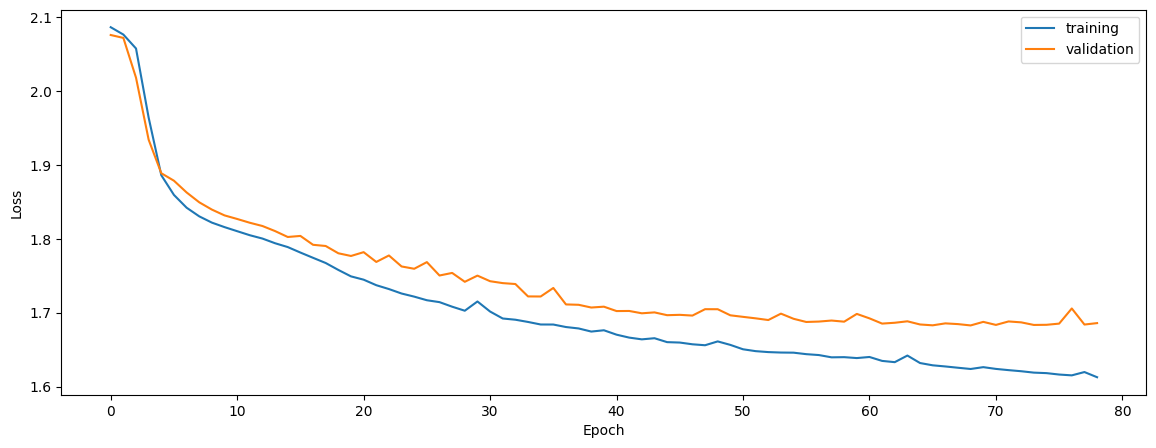

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.3675982746585262


0.34255915036984147


0.3168255490032922


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.3241022649065517


0.31398853598620136


0.2597948741910614


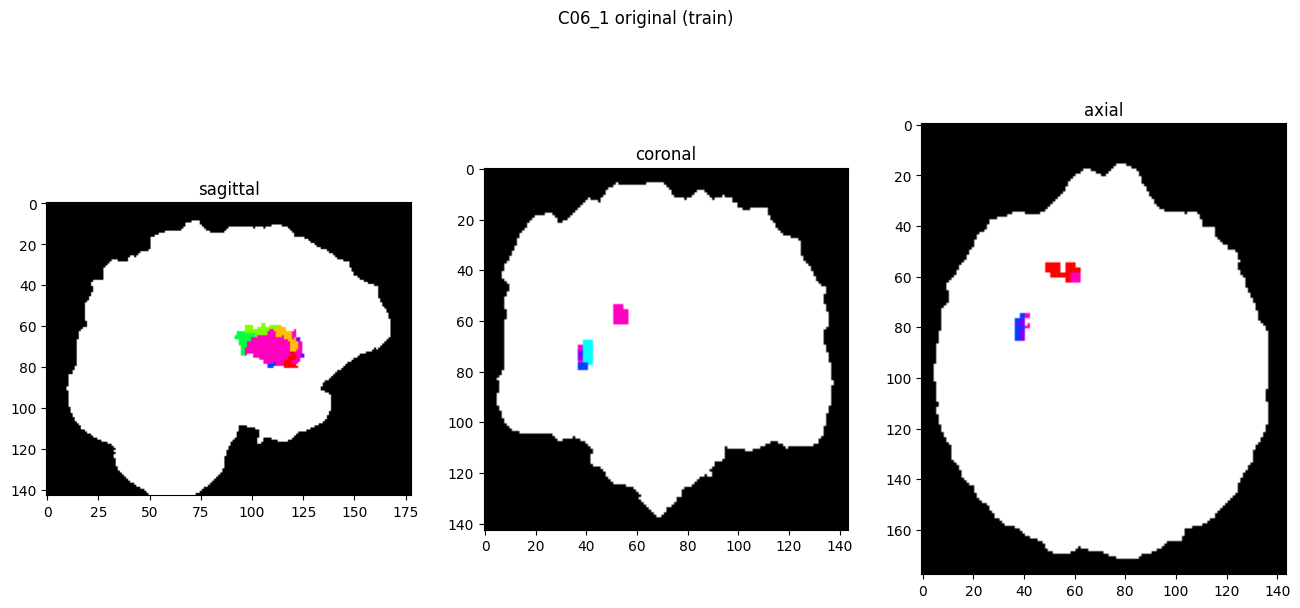

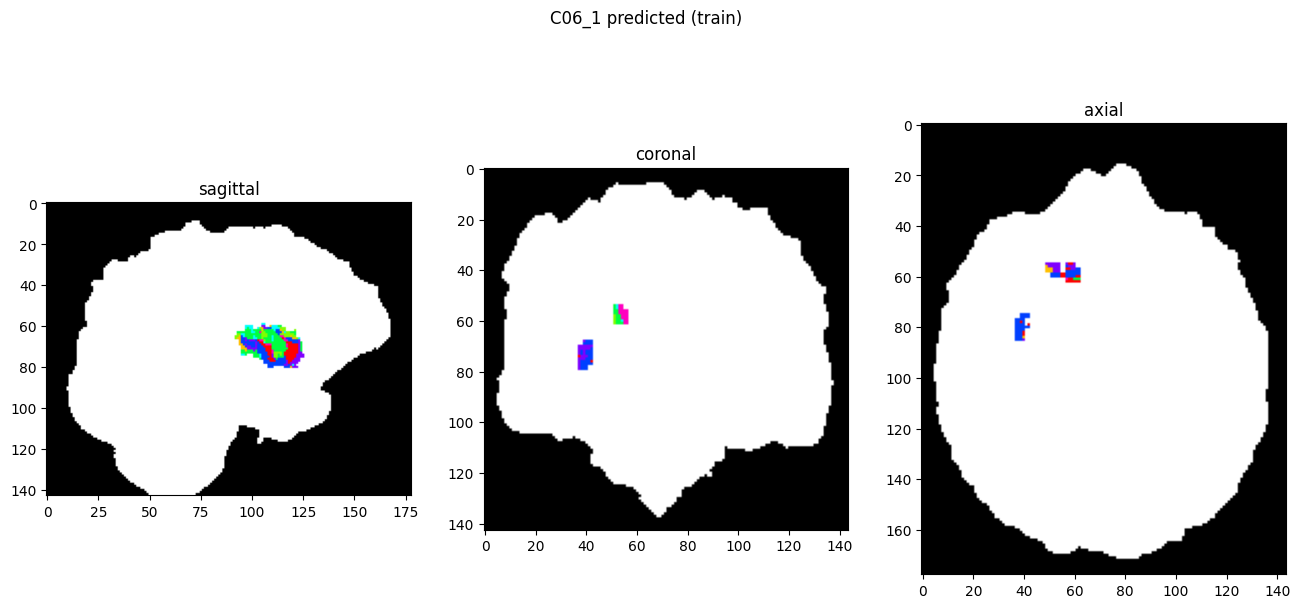

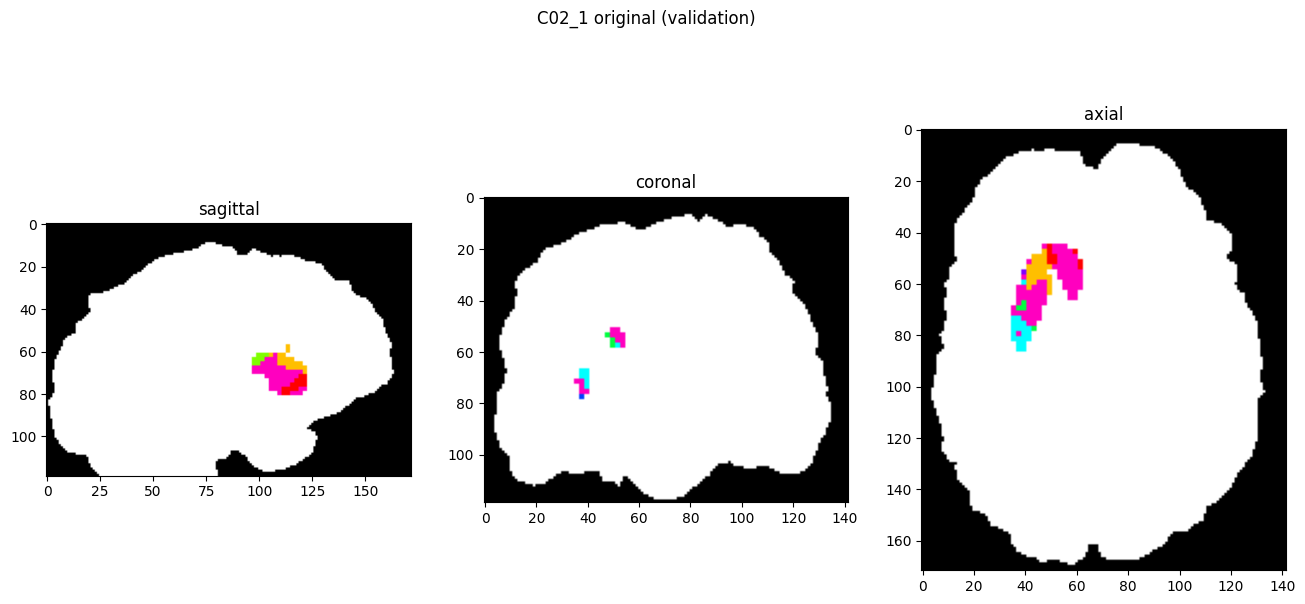

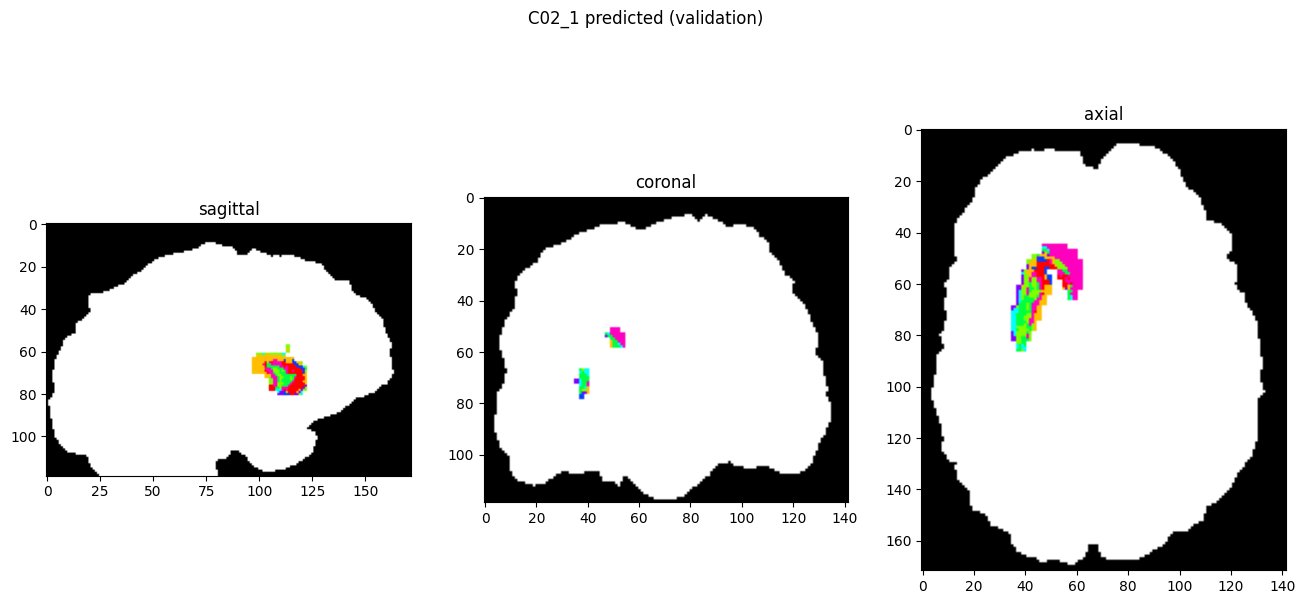

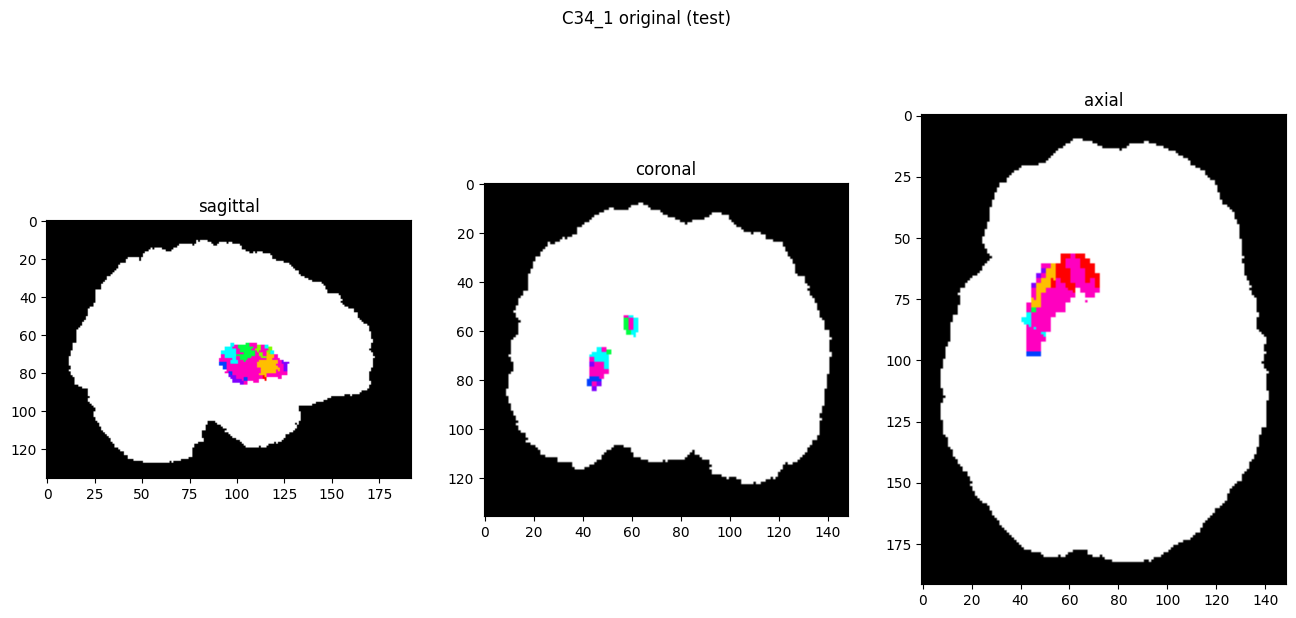

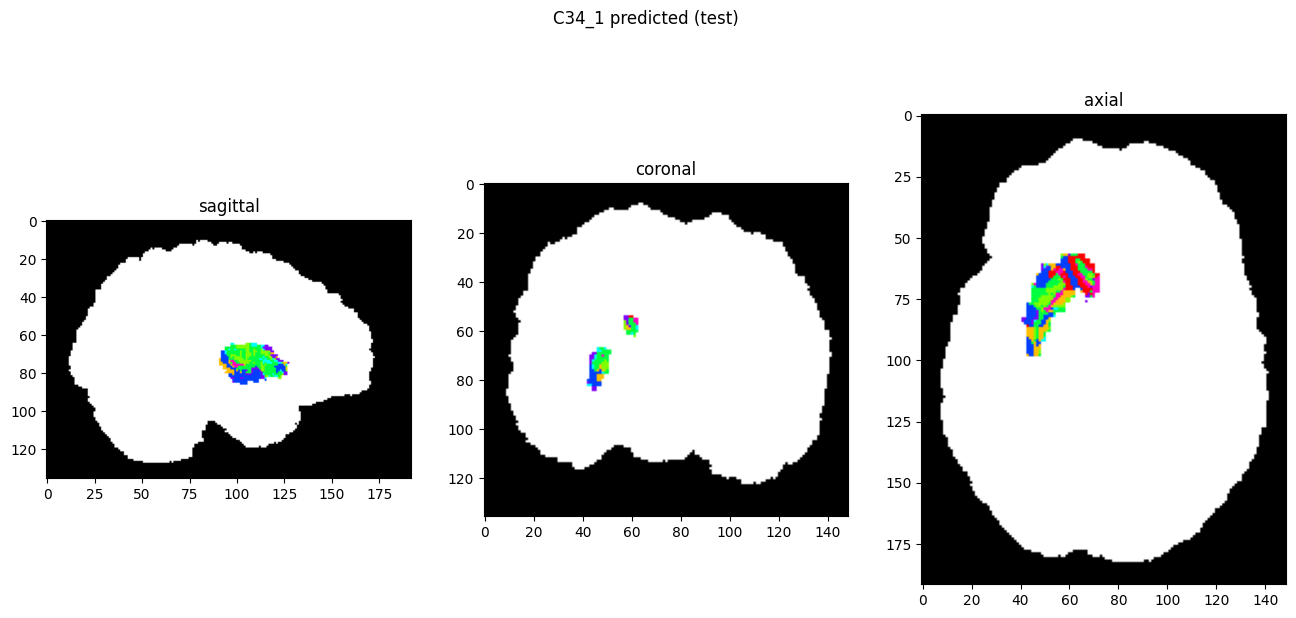

In [9]:
showResults(model, gen, threshold=0)